# Needed libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.vizier import Vizier
import sys
import scipy
from time import time
import healpy as hp
from itertools import product
from tqdm import tqdm
from scipy.stats import ks_2samp
from scipy.stats import binned_statistic_2d
import seaborn as sns
import pickle


In [2]:
# Directory setup for custom modules
module_path = 'EagleEye/eagleeye'
sys.path.append(module_path)
import EagleEye_v7_UPSILONPARAM_loc as EagleEye
#import EagleEye
import From_data_to_binary

# Custom Functions

In [3]:
##################################
####### EAGLEEYE FUNCTIONS #######
##################################
# Function to compute the Upsilon (𝛶) values from binary sequences
def compute_upsilon_values(binary_sequences, neighbor_range, num_cores):
    """Calculates the Upsilon values for anomaly detection using p-values across a range of neighbors."""
    # Create a PValueCalculatorParallel instance to access both pval_array_dict and smallest_pval_info
    p_value_calculator = EagleEye.PValueCalculatorParallel(binary_sequences, kstar_range=neighbor_range, num_cores=num_cores)
    
    # Calculate Upsilon values (𝛶) as the negative log of minimum p-values
    p_value_data = p_value_calculator.smallest_pval_info
    upsilon_values = -np.log(np.array(p_value_data['min_pval']))
    kstar_values = np.array(p_value_data['kstar_min_pval'])
    
    # Return both the calculator instance and the computed Upsilon values and k-star values
    return p_value_calculator, upsilon_values, kstar_values

# Function to retrieve Upsilon values for specific indices
def extract_upsilon_values(pval_info, indices, neighbor_range):
    """Extracts Upsilon values for given indices over a specified neighbor range."""
    return [[-np.log(pval_info.pval_array_dict[k][index, 0]) for k in neighbor_range] for index in indices]

# Function to find indices of interest based on Upsilon and k-star thresholds
def find_indices_by_threshold(upsilon_values, kstar_values, upsilon_thresh, kstar_thresh, condition='>'):
    """Finds indices where Upsilon and k-star values meet specified thresholds."""
    if condition == '>':
        indices = np.where((upsilon_values > upsilon_thresh) & (kstar_values < kstar_thresh))[0]
    else:
        indices = np.where((upsilon_values < upsilon_thresh) & (kstar_values > kstar_thresh))[0]
    return indices

In [4]:
# Function to plot the Upsilon sequences
def plot_nlpval(ax, nlpval1, nlpval2, nlpval3, label1, label2, label3,crit_v):
    ax.plot(range(4, len(nlpval1) + 4), nlpval1, color='limegreen', linewidth=2, label=label1)
    ax.plot(range(4, len(nlpval2) + 4), nlpval2, color='darkorange', linewidth=2, label=label2)
    ax.plot(range(4, len(nlpval3) + 4), nlpval3, color='magenta', linewidth=2, label=label2)
    # Apply logarithmic scale if necessary
    ax.set_yscale('log')
    # Highlight max values
    max_idx1 = np.argmax(nlpval1) + 4
    max_idx2 = np.argmax(nlpval2) + 4
    max_idx3 = np.argmax(nlpval3) + 4

    # ax.axvline(max_idx1, color='darkcyan', linestyle='--', linewidth=1.5, label=f'{label1} Kstar')
    # ax.axvline(max_idx2, color='red', linestyle='--', linewidth=1.5, label=f'{label2} Kstar')

    ax.axhline(y=crit_v, color='red', linestyle='--', linewidth=1.5, label='Crit. value')
    # ax.text(max_idx1, max(nlpval1), 'Kstar', color='darkcyan', verticalalignment='bottom', horizontalalignment='right', fontsize=17, fontweight='bold')
    # ax.text(max_idx2, max(nlpval2), 'Kstar', color='red', verticalalignment='bottom', horizontalalignment='right', fontsize=17, fontweight='bold')

    arrowprops_settings = dict(facecolor='darkcyan', edgecolor='darkcyan', shrink=0.05, width=2, headwidth=10, headlength=10)
    ax.annotate('', xy=(max_idx1, max(nlpval1)), xytext=(max_idx1, max(nlpval1) * 1.5),  # Slight adjustment for log scale
                arrowprops=arrowprops_settings)

    arrowprops_settings_red = dict(facecolor='chocolate', edgecolor='chocolate', shrink=0.05, width=2, headwidth=10, headlength=10)
    ax.annotate('', xy=(max_idx2, max(nlpval2)), xytext=(max_idx2, max(nlpval2) * 1.5),  # Slight adjustment for log scale
                arrowprops=arrowprops_settings_red)
    
    arrowprops_settings_mag = dict(facecolor='darkmagenta', edgecolor='darkmagenta', shrink=0.05, width=2, headwidth=10, headlength=10)
    ax.annotate('', xy=(max_idx3, max(nlpval3)), xytext=(max_idx3, max(nlpval3) * 1.5),  # Slight adjustment for log scale
                arrowprops=arrowprops_settings_mag)

    # Add 'Crit. value' text above the critical value line
    ax.text(395, crit_v * 1.1, 'Crit. line', color='red', fontsize=12, fontweight='bold',
            verticalalignment='bottom', horizontalalignment='right')


    ax.set_ylabel(r'$\Upsilon_i$', rotation=90)
    ax.set_xlim(0, 400-1)
    # ax.set_ylim(-5, max( [20, max(nlpval1), max(nlpval2)] )+10)
    ax.set_xlabel('K-nearest neighbors')
    # ax.legend(loc='upper right')

In [107]:
def LoadBkg(obs, glon_center, glat_center, eps_lon = 0, eps_lat = 0, row_limit = None, size = 2, 
            reference = 'sim', ref_par = 2, delta_long = 5, delta_lat = 0, center = True):
    
    gcenter = SkyCoord(frame="galactic", l = glon_center, b = glat_center, unit=(u.deg, u.deg))
    ra_center = gcenter.transform_to('icrs').ra.value
    dec_center = gcenter.transform_to('icrs').dec.value
    
    #%v = Vizier(columns=['RAICRS','DEICRS','pmRA','pmDE'],
    #%           column_filters={"Host":"1"}, row_limit = -1)
    
    v = Vizier(columns=['RAICRS','DEICRS','pmRA','pmDE'],
               column_filters={"Host":"1", 'Gmag':'<20', 'r':'>10000','logg':'>4'}, row_limit = -1)
    
    bkg = v.query_region(SkyCoord(ra = ra_center, dec=dec_center, unit=(u.deg, u.deg),frame='icrs'),
                            width= str(size) + "d",
                            catalog=["VI/137/gum_mw"])
    
    equatorial_coords = SkyCoord( ra  = bkg[0]['RAICRS'], 
                                  dec = bkg[0]['DEICRS'], 
                                  pm_ra_cosdec =  bkg[0]['pmRA'], 
                                  pm_dec = bkg[0]['pmDE'], 
                                  frame = 'icrs')
    
    # Transform to Galactic coordinates
    galactic_coords = equatorial_coords.transform_to('galactic')
    glon_full = galactic_coords.l.value
    glat_full = galactic_coords.b.value
    
    # Access proper motion in Galactic coordinates
    pmlon_full = galactic_coords.pm_l_cosb.to(u.mas/u.yr).value  # Proper motion in Galactic longitude (l)
    pmlat_full = galactic_coords.pm_b.to(u.mas/u.yr).value       # Proper motion in Galactic latitude (b)
    
    full = np.vstack((glon_full, glat_full, pmlon_full, pmlat_full)).T
        
    glon_dw = (obs[:,2] * 180/np.pi - 90) + glon_center + eps_lon # Just to center the dwarf galaxy
    glat_dw = (obs[:,3] * 180/np.pi - 30) + glat_center + eps_lat
    pmlon_dw = obs[:,5] / 1e3
    pmlat_dw = obs[:,6] / 1e3
    dw_data = np.vstack((glon_dw, glat_dw, pmlon_dw, pmlat_dw)).T

    # Remove dwarf stars outside patch
    ind = np.where( (dw_data[:,0] >= np.min(full[:,0])) &
                    (dw_data[:,0] <= np.max(full[:,0])) &
                    (dw_data[:,1] >= np.min(full[:,1])) &
                    (dw_data[:,1] <= np.max(full[:,1])) &
                    (dw_data[:,2] >= np.min(full[:,2])) &
                    (dw_data[:,2] <= np.max(full[:,2])) &
                    (dw_data[:,3] >= np.min(full[:,3])) &
                    (dw_data[:,3] <= np.max(full[:,3])) 
                  )[0]
    dw_data = dw_data[ind]
    
    if reference == 'sim':
        glon_ref = glon_center + delta_long
        glat_ref = glat_center + delta_lat
        gref = SkyCoord(frame="galactic", l = glon_ref, b = glat_ref, unit=(u.deg, u.deg))
        
        ra_ref = gref.transform_to('icrs').ra.value
        dec_ref = gref.transform_to('icrs').dec.value
        
        #v = Vizier(columns=['RAICRS','DEICRS','pmRA','pmDE'],
        #           column_filters={"Host":"1", 'Gmag':'<20', 'r':'>7500','logg':'>3.75'}, row_limit = -1)
                   #%column_filters={"Host":"1"}, row_limit = -1)
        
        ref = v.query_region(SkyCoord(ra = ra_ref, dec=dec_ref, unit=(u.deg, u.deg),frame='icrs'),
                                width= str(size + ref_par) + "d",
                                catalog=["VI/137/gum_mw"])
        
        equatorial_coords = SkyCoord( ra  = ref[0]['RAICRS'], 
                                      dec = ref[0]['DEICRS'], 
                                      pm_ra_cosdec =  ref[0]['pmRA'], 
                                      pm_dec = ref[0]['pmDE'], 
                                      frame = 'icrs')
        
        # Transform to Galactic coordinates
        galactic_coords = equatorial_coords.transform_to('galactic')
        if center:
            glon_ref = galactic_coords.l.value - glon_ref + glon_center # To center around the same longitud
            glat_ref = galactic_coords.b.value - glat_ref + glat_center # To center around the same latitud
        else:
            glon_ref = galactic_coords.l.value 
            glat_ref = galactic_coords.b.value
        
        # Access proper motion in Galactic coordinates
        pmlon_ref = galactic_coords.pm_l_cosb.to(u.mas/u.yr).value  # Proper motion in Galactic longitude (l)
        pmlat_ref = galactic_coords.pm_b.to(u.mas/u.yr).value       # Proper motion in Galactic latitude (b)
        
        ref = np.vstack((glon_ref, glat_ref, pmlon_ref, pmlat_ref)).T

        # If they are center we can remove the ones that are outside the patch
        if center:
            ind = np.where( (ref[:,0] >= np.min(full[:,0])) &
                            (ref[:,0] <= np.max(full[:,0])) &
                            (ref[:,1] >= np.min(full[:,1])) &
                            (ref[:,1] <= np.max(full[:,1])) &
                            (ref[:,2] >= np.min(full[:,2])) &
                            (ref[:,2] <= np.max(full[:,2])) &
                            (ref[:,3] >= np.min(full[:,3])) &
                            (ref[:,3] <= np.max(full[:,3])) 
                          )[0]
            ref = ref[ind]
        
    if reference == 'random':
        glon_ref = glon_center
        glat_ref = glat_center
        gref = SkyCoord(frame="galactic", l = glon_ref, b = glat_ref, unit=(u.deg, u.deg))
        
        ra_ref = gref.transform_to('icrs').ra.value
        dec_ref = gref.transform_to('icrs').dec.value

        # Query a zone 3 times bigger than the bkg
        ref = v.query_region(SkyCoord(ra = ra_ref, dec=dec_ref, unit=(u.deg, u.deg),frame='icrs'),
                                width= str(3*size) + "d",
                                catalog=["VI/137/gum_mw"])
        
        equatorial_coords = SkyCoord( ra  = ref[0]['RAICRS'], 
                                      dec = ref[0]['DEICRS'], 
                                      pm_ra_cosdec =  ref[0]['pmRA'], 
                                      pm_dec = ref[0]['pmDE'], 
                                      frame = 'icrs')
        
        # Transform to Galactic coordinates
        galactic_coords = equatorial_coords.transform_to('galactic')
        glon_ref = galactic_coords.l.value - glon_ref + glon_center # To center around the same longitud
        glat_ref = galactic_coords.b.value
        
        # Access proper motion in Galactic coordinates
        pmlon_ref = galactic_coords.pm_l_cosb.to(u.mas/u.yr).value  # Proper motion in Galactic longitude (l)
        pmlat_ref = galactic_coords.pm_b.to(u.mas/u.yr).value       # Proper motion in Galactic latitude (b)

        # Cut the bkg square where we will put the dwarf
        ref = np.vstack((glon_ref, glat_ref, pmlon_ref, pmlat_ref)).T
        ind = np.where( (ref[:,0] >= np.min(full[:,0])) &
                        (ref[:,0] <= np.max(full[:,0])) &
                        (ref[:,1] >= np.min(full[:,1])) &
                        (ref[:,1] <= np.max(full[:,1])) 
                      )[0]
        ref = np.delete(ref, ind, axis = 0)

        # pick len(full) random galaxies from the reference
        ind = np.random.choice(np.arange(len(ref)), size = len(full), replace = False)
        ref = ref[ind]
        ref[:,0] = np.random.uniform(np.min(full[:,0]), np.max(full[:,0]), size = len(ref))
        ref[:,1] = np.random.uniform(np.min(full[:,1]), np.max(full[:,1]), size = len(ref))
    if reference == 'noisy':
        ref = np.copy(full)
        ref[:,0] = ref[:,0] + np.random.normal(0, np.std(dw_data[:,0]) / ref_par, len(ref[:,0]))
        ref[:,1] = ref[:,1] + np.random.normal(0, np.std(dw_data[:,1]) / ref_par, len(ref[:,1]))
        ref[:,2] = ref[:,2] + np.random.normal(0, np.std(dw_data[:,2]) / ref_par, len(ref[:,2]))
        ref[:,3] = ref[:,3] + np.random.normal(0, np.std(dw_data[:,3]) / ref_par, len(ref[:,3]))

    if reference == 'shuffle':
        ref = np.copy(full)
        rand_ind = np.random.choice(np.arange(len(ref)), size = len(ref), replace = False)
        ref[:,2] = ref[rand_ind,2]
        ref[:,3] = ref[rand_ind,3]
        
    if row_limit is not None:
        np.random.shuffle(full)
        full = full[:row_limit]
        
        np.random.shuffle(ref)
        ref = ref[:row_limit]
        
    full = np.vstack((full, dw_data))

    return full, ref, dw_data

In [120]:
obs = np.loadtxt('../data/mocks/obs.lib96/UFGX_TEST96_lib/obs_960005.dat') # just to have something for the function to work
full, ref, dw_data = LoadBkg(obs, glon_center = 90, glat_center = 30,
                             eps_lat = 0, eps_lon = 0, row_limit = None, size = 2, reference = 'sim', 
                             center = True, ref_par = 0, delta_long = -2, delta_lat = 2)
bkg_data = full[:-len(dw_data)]

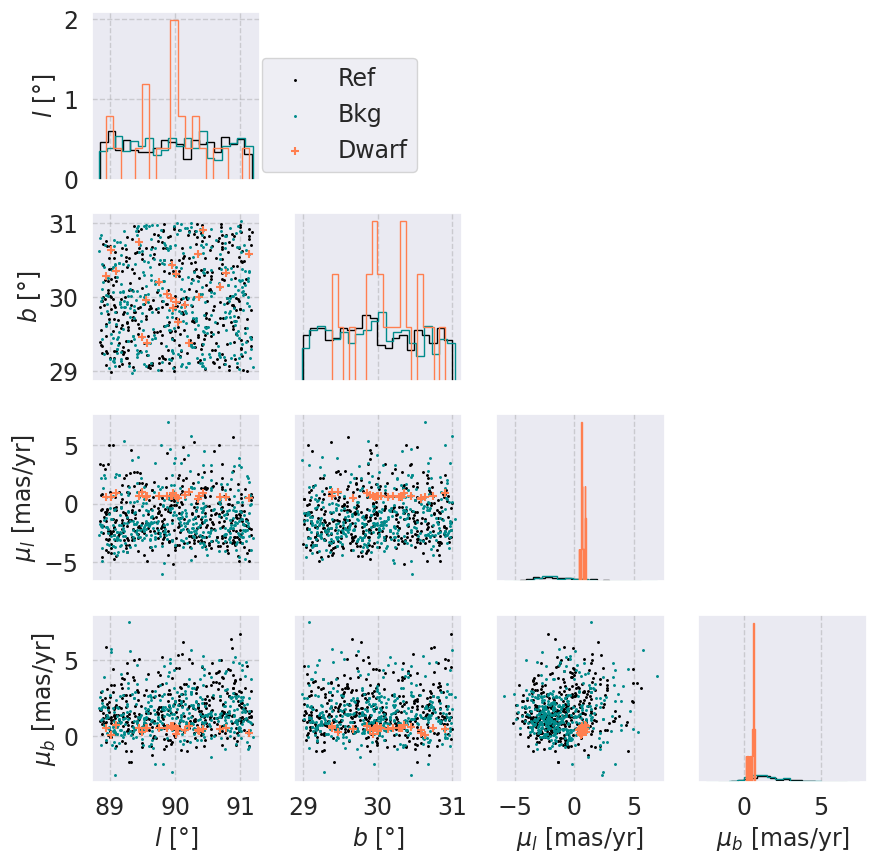

In [121]:
fig, ax  = plt.subplots(4,4, figsize = (10,10), sharex = 'col')

plt.subplots_adjust(hspace = 0.2, wspace = 0.2)

for i in range(4):
    for j in range(4):
        if i < j: ax[i,j].set_axis_off()
        if i > j:
            if ref is not None: ax[i,j].scatter(ref[:,j], ref[:,i], color = color_ref, label = 'Ref', marker = '.', s = 5)
            if full is not None: ax[i,j].scatter(full[:,j], full[:,i], color = color_full, label = 'Bkg', marker = '.', s = 5)
            ax[i,j].scatter(dw_data[:,j], dw_data[:,i], color = color_dw, label = 'Dwarf', marker = '+')
        if i == j:
            if ref is not None: ax[i,j].hist(ref[:,i], histtype = 'step', density = True, bins = 20, color = color_ref)
            if full is not None: ax[i,j].hist(full[:,i], histtype = 'step', density = True, bins = 20, color = color_full)
            ax[i,j].hist(dw_data[:,i], histtype = 'step', density = True, bins = 20, color = color_dw)
        if i == 3: 
            ax[i,j].set_xlabel(labels[j])
        if j == 0: 
            ax[i,j].set_ylabel(labels[i])
        else: 
            ax[i,j].set_yticks([])
    
#ax[0,0].set_xlim(lims[0])
#ax[3,1].set_xlim(lims[1])
#ax[3,2].set_xlim(lims[2])
#ax[3,3].set_xlim(lims[3])

ax[1,0].legend(loc = 'upper right', bbox_to_anchor = (2,2))

In [6]:
def purity(upsilon, ind, up_th = 20):
    '''
    Function to compute the purity of the cluster found by EE.

    Parameters
    ----------

    upsilon: (np.array) upsilon values of all the analized stars.
    ind: (np.array int) indices of the stars that trully belong to the dwarf galaxy.
    up_th: (float) upsilon threshold. default = 20

    Returns
    -------

    Purity defined as # dwarf stars (upsilon >= up_th) / # stars (upsilon >= up_th)
    '''
    return len(np.where(upsilon[ind] >= up_th)[0]) / len(np.where(upsilon >= up_th)[0])

def FPR(upsilon, ind, up_th = 20):
    '''
    Function to compute the false positive rate of the cluster found by EE.

    Parameters
    ----------

    upsilon: (np.array) upsilon values of all the analized stars.
    ind: (np.array int) indices of the stars that trully belong to the dwarf galaxy.
    up_th: (float) upsilon threshold. default = 20

    Returns
    -------

    False positive rate defined as # non-dwarf stars with upsilon >= up_th / # bkg stars
    '''
    ind_aux = np.arange(len(upsilon))
    ind_aux = np.delete(ind_aux, ind)
    return len(np.where(upsilon[ind_aux] >= up_th)[0]) / len(ind_aux)
    
def FNR(upsilon, ind, up_th = 20):
    '''
    Function to compute the dwarf stars missed by EE. (False Negative Rate)

    Parameters
    ----------

    upsilon: (np.array) upsilon values of all the analized stars.
    ind: (np.array int) indices of the stars that trully belong to the dwarf galaxy.
    up_th: (float) upsilon threshold. default = 20

    Returns
    -------

    FNR defined as # dwarf stars (upsilon < up_th) / # dwarf stars
    '''
    return len(np.where(upsilon[ind] < up_th)[0]) / len(ind)

def Delta(full, upsilon, ind, up_th = 20):
    '''
    Function to compute the distances (angular and peculiar velocity) between the center of the cluster found by EE
        and the dwarf galaxy.

    Parameters
    ----------

    full: (np.array) data of the analized stars.    
    upsilon: (np.array) upsilon values of all the analized stars.
    ind: (np.array int) indices of the stars that trully belong to the dwarf galaxy.
    up_th: (float) upsilon threshold. default = 20

    Returns
    -------

    Distances defined as 
        ang = np.sqrt( (l_{real} - <l>)^{2} + (b_{real} - <b>)^{2} )
        vpec = np.sqrt( (mul_{real} - <mul>)^{2} + (mub_{real} - <mub>)^{2} )
    '''
    l_real = np.mean(full[ind,0])
    b_real = np.mean(full[ind,1])
    mul_real = np.mean(full[ind,2])
    mub_real = np.mean(full[ind,3])

    ind_aux = np.where(upsilon >= up_th)[0]
    l_cluster = np.mean(full[ind_aux, 0])
    b_cluster = np.mean(full[ind_aux, 1])
    mul_cluster = np.mean(full[ind_aux, 2])
    mub_cluster = np.mean(full[ind_aux, 3])
    
    return np.sqrt( (l_real - l_cluster)**2 + (b_real - b_cluster)**2 ), \
           np.sqrt( (mul_real - mul_cluster)**2 + (mub_real - mub_cluster)**2 )

In [7]:
color_cl = 'red'
color_full = 'darkcyan'
color_dw = 'coral'
color_ref = 'black'

labels = ['$l$ [°]','$b$ [°]','$\mu_{l}$ [mas/yr]','$\mu_{b}$ [mas/yr]']



def plotDwarf(ax, dw_data, full = None, ref = None, indices = None, nbins = 20):
    bins = [np.linspace(np.mean(dw_data[:,0]) - 2, np.mean(dw_data[:,0]) + 2, nbins),
            np.linspace(np.mean(dw_data[:,1]) - 2, np.mean(dw_data[:,1]) + 2, nbins),
            np.linspace(np.mean(dw_data[:,2]) - 3, np.mean(dw_data[:,2]) + 3, nbins),
            np.linspace(np.mean(dw_data[:,3]) - 3, np.mean(dw_data[:,3]) + 3, nbins)]

    lims = [(np.mean(dw_data[:,0]) - 2, np.mean(dw_data[:,0]) + 2),
            (np.mean(dw_data[:,1]) - 2, np.mean(dw_data[:,1]) + 2),
            (np.mean(dw_data[:,2]) - 3, np.mean(dw_data[:,2]) + 3),
            (np.mean(dw_data[:,3]) - 3, np.mean(dw_data[:,3]) + 3)]

    if indices is not None: 
        cluster = full[indices,:] 
    else: 
        cluster = None
    
    for i in range(4):
        for j in range(4):
            if i < j: ax[i,j].set_axis_off()
            if i > j:
                #ax[i,j].set_xlim(lims[j])
                ax[i,j].set_ylim(lims[i])
                if cluster is not None: ax[i,j].scatter(cluster[:,j], cluster[:,i], edgecolor = color_cl, label = 'Cl', 
                                                        marker = 'o', s = 20, facecolor = 'none')
                if ref is not None: ax[i,j].scatter(ref[:,j], ref[:,i], color = color_ref, label = 'Ref', marker = '.', s = 5)
                if full is not None: ax[i,j].scatter(full[:,j], full[:,i], color = color_full, label = 'Bkg', marker = '.', s = 5)
                ax[i,j].scatter(dw_data[:,j], dw_data[:,i], color = color_dw, label = 'Dwarf', marker = '+')
            if i == j:
                if ref is not None: ax[i,j].hist(ref[:,i], histtype = 'step', density = True, bins = bins[i], color = color_ref)
                if full is not None: ax[i,j].hist(full[:,i], histtype = 'step', density = True, bins = bins[i], color = color_full)
                ax[i,j].hist(dw_data[:,i], histtype = 'step', density = True, bins = bins[i], color = color_dw)
                if cluster is not None: ax[i,j].hist(cluster[:,i], histtype = 'step', density = True, bins = bins[i], color = color_cl)
            if i == 3: 
                ax[i,j].set_xlabel(labels[j])
            #else:
             #   ax[i,j].set_xticks([])
            if j == 0: 
                ax[i,j].set_ylabel(labels[i])
            else: 
                ax[i,j].set_yticks([])
        
    ax[0,0].set_xlim(lims[0])
    ax[3,1].set_xlim(lims[1])
    ax[3,2].set_xlim(lims[2])
    ax[3,3].set_xlim(lims[3])
    
    ax[1,0].legend(loc = 'upper right', bbox_to_anchor = (2,2))
    return ax

# Let's start the analysis

In [8]:
# Let's load the true data for the galaxies
ifile = 96
data = np.loadtxt('../data/mocks/library.survey.UFGX_LIB' + str(ifile) + '.dat')

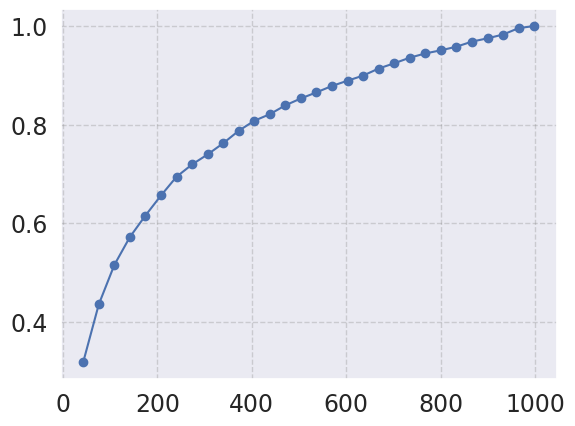

In [9]:
# Calcular el histograma
counts, bin_edges = np.histogram(data[:,12], bins=30, density=True)

# Calcular el histograma acumulado
cumulative_counts = np.cumsum(counts)  # Suma acumulativa

# Normalizar para que el acumulado llegue a 1
cumulative_counts /= cumulative_counts[-1]

# Graficar
plt.plot(bin_edges[1:], cumulative_counts, marker='o', linestyle='-')



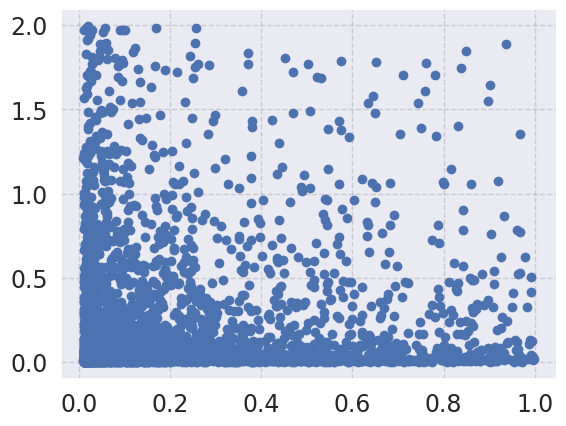

In [10]:
plt.scatter(data[:,13], data[:,14])

In [11]:
# Generate 100,000 Bernoulli sequences to determine the critical Upsilon threshold
num_sequences = 1000            # Number of Bernoulli sequences
K_M = 100                        # Length of each sequence
NUM_CORES = 100
NEIGHBOR_RANGE = range(4, K_M)
critical_quantile = 0.9999        # Quantile to calculate critical Upsilon threshold


validation  = None         # Number of samples to use for validation
kstar_range = range(20, K_M) # Range of kstar values to consider

In [12]:
nside = 1
NPIX = hp.nside2npix(nside)
glat, glon = np.degrees(hp.pix2ang(nside, np.arange(NPIX)))
glat = 90 - glat
len(np.where(np.abs(glat) > 20)[0])

8

In [13]:
glon

array([ 45., 135., 225., 315.,   0.,  90., 180., 270.,  45., 135., 225.,
       315.])

In [14]:
glon = glon[np.abs(glat) > 20]

In [15]:
glat = glat[np.abs(glat) > 20]

In [16]:
len(glon)

8

In [17]:
start0 = time()
glon = [90]
glat = [30]

counter = 0
results0 = []

niter = 1
for iiter in range(niter):
    obs = np.loadtxt('../data/mocks/obs.lib96/UFGX_TEST96_lib/obs_960005.dat') # just to have something for the function to work
    full_aux, ref, dw_data = LoadBkg(obs, glon_center = 90, glat_center = 30,
                                 eps_lat = 0, eps_lon = 0, row_limit = None, size = 5, reference = 'sim')
    bkg_data = full_aux[:-len(dw_data)]
    
    try:
        result_dictionary_na = EagleEye.Soar(
                            ref, bkg_data, result_dict_in = {}, K_M =100, critical_quantiles = None,
                            num_cores=1, validation=None, partition_size=1, Upsilon_stars=[10])
    except:
        result_dictionary_na = EagleEye.Soar(
                            ref, bkg_data, result_dict_in = {}, K_M =100, critical_quantiles = None,
                            num_cores=1, validation=None, partition_size=1, Upsilon_stars=None)
    for igal in tqdm(range(0, 1)):
        start = time()
        if data[igal,12] < 40000:
            
            obs = np.loadtxt('../data/mocks/obs.lib' + str(ifile) + '/UFGX_TEST' + str(ifile) + '_lib/obs_' + str(int(data[igal,0])) + '.dat')
            print(len(obs))

            glon_dw = (obs[:,2] * 180/np.pi - 90) + glon[iiter] # Just to center the dwarf galaxy
            glat_dw = (obs[:,3] * 180/np.pi - 30) + glat[iiter]
            pmlon_dw = obs[:,5] / 1e3
            pmlat_dw = obs[:,6] / 1e3
            dw_data = np.vstack((glon_dw, glat_dw, pmlon_dw, pmlat_dw)).T
            full = np.vstack((bkg_data, dw_data))
    
            # Begin calls to EagleEye (version 7)
            try:
                result_dictionary = EagleEye.Soar(
                    ref, full, result_dict_in = {}, K_M = K_M, critical_quantiles = None,
                    num_cores=NUM_CORES, validation=int(np.min((len(full), len(ref)))), partition_size=100,Upsilon_stars=[10] )
            except:
                result_dictionary = EagleEye.Soar(
                    ref, full, result_dict_in = {}, K_M = K_M, critical_quantiles = None,
                    num_cores=NUM_CORES, validation=int(np.min((len(full), len(ref)))), partition_size=100,Upsilon_stars=None)

            
            result_dictionary['Ids'] = int(data[igal,0])
            result_dictionary['ang_sizes'] = data[igal,13]
            result_dictionary['vpec_sizes'] = data[igal,14]
            result_dictionary['nstars'] = len(obs)
            result_dictionary['bkg'] = (len(full) - len(dw_data))
            result_dictionary['glat'] = glat[iiter]
            result_dictionary['glon'] = glon[iiter]
            
            results0.append(result_dictionary)
            
            counter = counter + 1
        stop = time()
        print('It takes {:.2f} hs to analyze a dwarf with {} stars at {} positions'.format((stop-start)/3600, len(dw_data), niter))
stop0 = time()

Computing unique elements for quantile/s.
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            


  0%|          | 0/1 [00:00<?, ?it/s]

371
Validation size is:  2392
Validation size is:  2392
Computing unique elements for quantile/s.


100%|██████████| 1/1 [00:04<00:00,  4.65s/it]

Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
It takes 0.00 hs to analyze a dwarf with 371 stars at 1 positions


In [344]:
print('It takes {:.2f} hs to analyze {} dwarfs'.format((stop0-start0)/3600, counter))


It takes 0.03 hs to analyze 2 dwarfs


In [58]:
Ids = np.zeros(len(results))
ang_sizes = np.zeros(len(results))
vpec_sizes = np.zeros(len(results))
nstars = np.zeros(len(results))
bkg = np.zeros(len(results))
glat = np.zeros(len(results))
glon = np.zeros(len(results))

for i in range(len(results)):
    Ids[i] = results[i]['Ids']
    ang_sizes[i] = results[i]['ang_sizes']
    vpec_sizes[i] = results[i]['vpec_sizes']
    nstars[i] = results[i]['nstars']
    bkg[i] = results[i]['bkg']
    glat[i] = results[i]['glat']
    glon[i] = results[i]['glon']

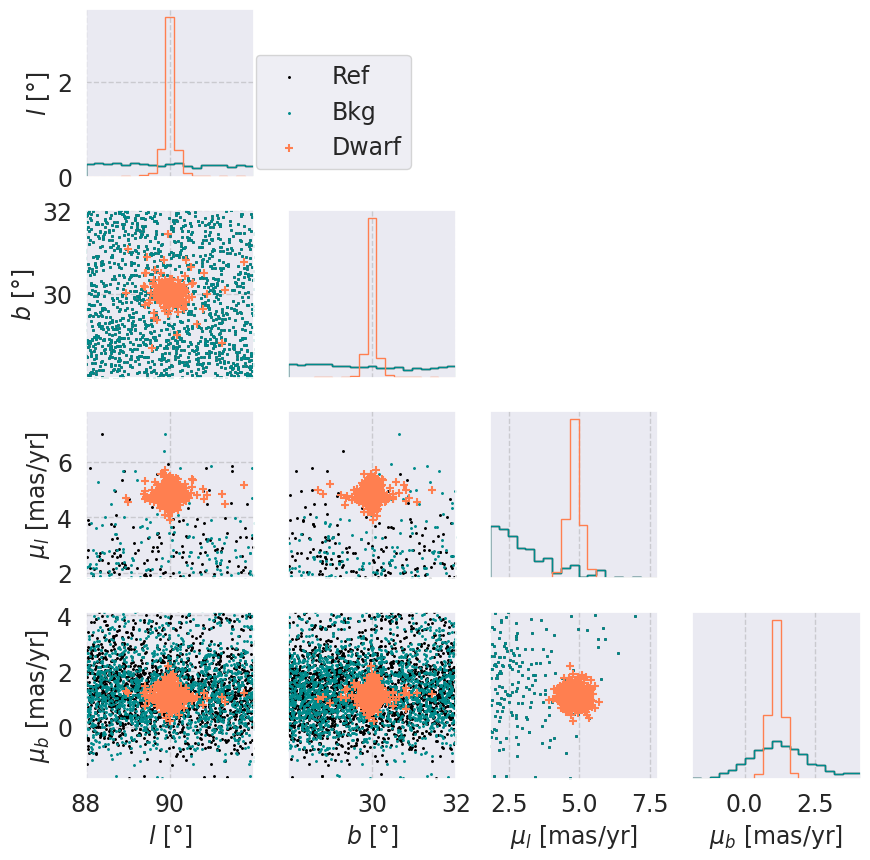

In [346]:
fig, ax  = plt.subplots(4,4, figsize = (10,10), sharex = 'col')

plt.subplots_adjust(hspace = 0.2, wspace = 0.2)

ax = plotDwarf(ax, dw_data, bkg_data, ref)

In [351]:
!ls ../data/*.json

../data/EEv7_bkg:2466_size_5_ref_2392.json


In [38]:
#Save in JSON file
#with open(f"../data/EEv7_bkg:{bkg[0]}_size_{5}_ref_shuffle.json", "wb") as file:
#    pickle.dump(results, file)

with open("../data/EEv7_bkg:2466_size_5_ref_2392.json", "rb") as file:
    results_sim = pickle.load(file)

In [63]:
nups = 100

aux_pur = np.zeros((len(results), nups))
aux_FNR = np.zeros((len(results), nups))
aux_FPR = np.zeros((len(results), nups))

stats = np.zeros((len(results), 3))
for ipos in range(len(results)):
    result = results[ipos]['stats']
    upsilon = result['Upsilon_i_plus'] #upsilons[ipos]
    upsilon = result['Upsilon_i_plus'] #upsilons[ipos]
    ind = np.arange(len(upsilon))[-results[ipos]['nstars']:]
    up_range = np.linspace(np.min(upsilon), np.max(upsilon), nups)
    for iups in range(nups):
        aux_pur[ipos, iups] = purity(upsilon, ind, up_th = up_range[iups])
        aux_FNR[ipos, iups] = FNR(upsilon, ind, up_th = up_range[iups])
        aux_FPR[ipos, iups] = FPR(upsilon, ind, up_th = up_range[iups])

    try:
        #overdensity_ind = np.asarray(results[ipos]['unique_elements_overdensities'][list(results[ipos]['unique_elements_overdensities'].keys())[0]])
        obs = np.loadtxt('../data/mocks/obs.lib' + str(ifile) + '/UFGX_TEST' + str(ifile) + '_lib/obs_' + str(int(results[ipos]['Ids'])) + '.dat')
        glon_dw = (obs[:,2] * 180/np.pi - 90) + glon[0] # Just to center the dwarf galaxy
        glat_dw = (obs[:,3] * 180/np.pi - 30) + glat[0]
        pmlon_dw = obs[:,5] / 1e3
        pmlat_dw = obs[:,6] / 1e3
        dw_data = np.vstack((glon_dw, glat_dw, pmlon_dw, pmlat_dw)).T
        full = np.vstack((bkg_data, dw_data))
        clusters = EagleEye.partitian_function(ref, full, results[ipos], results[ipos]['Upsilon_star_plus'][qt],
                                   results[ipos]['Upsilon_star_minus'][qt],K_M=K_M)
        IV_IE_dict = EagleEye.IV_IE_get_dict(clusters, results[ipos], full, ref, Upsilon_star = [10])
        overdensity_ind = IV_IE_dict['OVER_clusters'][0]['From_test']
        bkg_ind = np.delete(np.arange(len(upsilon)), overdensity_ind)
    except:        
        overdensity_ind = np.asarray(np.where(upsilon >= np.quantile(upsilon, 0.8))[0])
        bkg_ind = np.delete(np.arange(len(upsilon)), overdensity_ind)
    TP = len(np.where(overdensity_ind >= results[ipos]['bkg'])[0]) # True positives
    FP = len(np.where(overdensity_ind < results[ipos]['bkg'])[0]) # False positives
    TN = len(np.where(bkg_ind < results[ipos]['bkg'])[0]) # True negative
    FN = len(np.where(bkg_ind >= results[ipos]['bkg'])[0]) # False negative
    stats[ipos,0] = TP / (TP+FP) # purity/precision with equalization
    stats[ipos,1] = FP / results[ipos]['bkg'] # false positive rate
    stats[ipos,2] = TP / results[ipos]['nstars'] # true positive rate

Computation of distances started
Computation of the distances up to 100 NNs started
0.14 seconds for computing distances
ID estimation finished: selecting ID of 3.7033796018109886
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001251697540283203 sec
Clustering finished, 3 clusters found
total time is, 0.0030040740966796875
Cluster number  1
Cluster number  2
[585, 476, 453, 598]
----------------------------
[ 453  454  476  477  483  494  534  537  567  585  589  598  622  626
  638  647  744  752  822

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


Computation of distances started
Computation of the distances up to 89 NNs started
0.01 seconds for computing distances
ID estimation finished: selecting ID of 3.6723990614616446
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.606910705566406e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0012879371643066406
Cluster number  1
Cluster number  2
[492, 622, 534, 1882, 477]
----------------------------
[ 198  471  477  492  534  622 1534 1706 1882 2235 2901 2944 2945 3109
 3216 3280 3310 4461

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.8079187680063313
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012969970703125 sec
Clustering finished, 3 clusters found
total time is, 0.002726316452026367
Cluster number  1
Cluster number  2
[2153, 1801, 2158, 762, 636]
----------------------------
[  32  187  198  409  447  575  597  602  636  659  697  739  762  778
  816  973 1026 1153 1176 1395 1476 1534 1587 1801 1882 1963 2058 2059
 2153 2158 2235 2765 2818 2835 29

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.033348083496094e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010116100311279297
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.92465784044055
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.983585132316491
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.000133514404296875 sec
Clustering finished, 3 clusters found
total time is, 0.0032761096954345703
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2567, 2568, 2569, 2570, 2571, 2572, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 260

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.02 seconds for computing distances
ID estimation finished: selecting ID of 2.6416146367899938
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 5.269050598144531e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0008759498596191406
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1797, 1638, 1707, 1868, 1870, 2414, 1467, 156]
----------------------------
[ 156  769  772 1354 1424 1467 1484 1601 1638 1707 1732 1746 1766 1789
 1797 1868 1870 1930 2309 2337 2414 2969 3073 3121 3124 314

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.7502364525486582
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010013580322265625 sec
Clustering finished, 3 clusters found
total time is, 0.0026345252990722656
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2583, 2584, 2586, 2587, 2589, 2590, 2591, 2592, 2593, 2595, 2597, 2598, 2600, 2601, 2604, 2605, 2606, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.6713938024250137
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001392364501953125 sec
Clustering finished, 2 clusters found
total time is, 0.003531217575073242
Cluster number  1
Cluster number  2
[1601, 2337, 2147, 1638, 1707, 492, 1870, 2225, 156]
----------------------------
[ 156  492 1467 1601 1638 1706 1707 1811 1868 1870 2147 2225 2337 2414
 3500 3543 3879 4513 4514 4521 4652 4715 5038 5166 5229]
Computation of distan

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 29 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 1.9612726876637838
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.0531158447265625e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0005576610565185547
Cluster number  1
Cluster number  2
[1601, 769, 2337, 2309, 1638, 1707, 1868, 1870, 2414, 1467, 156]
----------------------------
[ 156  769 1354 1467 1484 1601 1638 1707 1746 1766 1

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 100 NNs started
0.13 seconds for computing distances
ID estimation finished: selecting ID of 4.258250614786886
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00018978118896484375 sec
Clustering finished, 2 clusters found
total time is, 0.004718303680419922
Cluster number  1
Cluster number  2
[652, 1819, 156, 2337, 1826, 1707, 435, 1601, 453, 457, 589, 462, 1870, 603, 477, 1638, 626, 1917, 638, 639]
----------------------------
[ 156  43

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 4.097722569808398
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.002 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011181831359863281 sec
Clustering finished, 3 clusters found
total time is, 0.003804922103881836
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.5229249154398645
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.655952453613281e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0022788047790527344
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1870, 2414, 156]
----------------------------
[ 156 1467 1601 1638 1707 1868 1870 2337 2414 3592 3764 4288 4398 4399
 4406 4469 4537 4600 4605 4607 5051 5114]
Cluster number  3
Computation of distances sta

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.742931851321163
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 6
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001709461212158203 sec
Clustering finished, 4 clusters found
total time is, 0.003362417221069336
Cluster number  1
Cluster number  2
[2688, 2563, 2692, 2564, 2566, 2693, 2822, 2829, 2703, 2839, 2584, 2841, 2842, 2587, 2720, 2721, 2722, 2595, 2848, 2731, 2732, 2739, 2613, 2490, 2620, 2750, 2496, 2626, 2628, 2758, 2504, 2633, 2507, 2768, 2641, 2646, 2651, 2654, 265

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 4.010315786608947
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001404285430908203 sec
Clustering finished, 3 clusters found
total time is, 0.003782033920288086
Cluster number  1
Cluster number  2
[647, 652, 783, 795, 1819, 1826, 435, 453, 457, 589, 462, 468, 470, 603, 477, 613, 490, 626, 1917, 638, 639]
----------------------------
[ 435  453  457  462  468  470  476  477  479  490  492  534  589  603
  613  622  626  638  6

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.706690219806351
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 6.4849853515625e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0016014575958251953
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2505

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Computation of distances started
Computation of the distances up to 25 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 1.88451986596014
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.100799560546875e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0005588531494140625
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1766, 1707, 1868, 589, 1870, 2414, 2257, 1467, 156, 477]
----------------------------
[ 156  291  477  589  769  957 13

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.3700024897060845
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.796287536621094e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0025832653045654297
Cluster number  1
Cluster number  2
[1601, 2337, 772, 1797, 1638, 1707, 1868, 1870, 2414, 1424, 156]
----------------------------
[ 156  517  772 1212 1424 1467 1546 1601 1638 1707 1797 1868 1870 1967
 2179 2337 2414 3011 3123 3130 3142 3234 3343 3421 3537 3592 3709

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.2479248046875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0009996891021728516
Cluster number  1
Computation of distances started
Computation of the distances up to 19 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kst

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.128715515136719e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0019769668579101562
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2570, 2571, 2572, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2475, 2476, 2477, 2478, 2480, 2481, 2482, 2483, 2485, 2486, 2487, 2488, 2489, 2490, 2492, 2493, 2494, 2495, 2496, 2499, 2500, 2501, 2502, 2504, 2505, 2506, 2507, 2508, 2509, 2511, 2512, 2513, 2514, 2516, 2517, 2518, 2519, 2522, 2523, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2540, 2541, 2542, 2543, 2544, 2546, 2547, 2549, 2550, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.692123040234544
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 7.295608520507812e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0038704872131347656
Cluster number  1
Cluster number  2
[2337, 1601, 643, 609, 1820, 484, 1638, 1707, 1870, 594, 156, 1823]
----------------------------
[ 156  437  453  476  483  484  487  490  494  585  587  594  598  609
  613  627  629  638  639  643  644  647  660  661  742  757  7

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.13158114190523
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 7.319450378417969e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0032579898834228516
Cluster number  1
Cluster number  2
[454]
----------------------------
[ 242  250  454  466  467  483  494  606  634  636  659  758  767  782
  788  799  810  816 1801 1879 1894 2153 2158 2922 2942 2949 2954 3074
 3097 3115 3117 3120 3128 3145 3150 3152 3154 3199 3234

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.04 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.315376281738281e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005667209625244141
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.99025043997862
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.2846469687296485
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010061264038085938 sec
Clustering finished, 2 clusters found
total time is, 0.003408193588256836
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 492, 589, 1870, 626, 603, 156, 477]
----------------------------
[ 156  435  453  457  468  476  477  479  492  534  589  603  613  622
  626  638  647  652  783  795 1467 1601 1638 1707 1787 1819 1826 183

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 100 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.1141815348806405
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 6.198883056640625e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0014989376068115234
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2490, 2491, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.25 seconds for computing distances
ID estimation finished: selecting ID of 3.0127135089915913
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001678466796875 sec
Clustering finished, 3 clusters found
total time is, 0.0032656192779541016
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.081031799316406e-05 sec
Clustering finished, 1 clusters found
total time is, 0.001024007797241211
Cluster number  1
Computation of distances started
Computation of the distances up to 19 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.3974702236355063
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.887580871582031e-05 sec
Clustering finished, 2 clusters found
total time is, 0.001004934310913086
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 709, 1638, 1766, 1707, 1868, 1870, 2414, 400, 2257, 599, 1467, 156]
----------------------------
[ 156  291  400  599  709  769  957 1354 1467 1484 1601 1638 1707 1746
 1766 1789 1868 1870 1930 2257 2309 233

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.09 seconds for computing distances
ID estimation finished: selecting ID of 2.5022075571286013
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012111663818359375 sec
Clustering finished, 2 clusters found
total time is, 0.0027496814727783203
Cluster number  1
Cluster number  2
[769, 2337, 1601, 1638, 1707, 1868, 1870, 2414, 1467, 156]
----------------------------
[ 156  250  426  454  471  477  534  597  622  636  752  769  782  816
  822  853 1354 1467 1484 1534 1542 1601 1638 1707 1746 1762 1766 1787

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.13 seconds for computing distances
ID estimation finished: selecting ID of 4.310738197164124
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.002 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00013065338134765625 sec
Clustering finished, 3 clusters found
total time is, 0.004364490509033203
Cluster number  1
Cluster number  2
[2579, 2708, 2709, 2719, 2592, 2729, 2732, 2735, 2481, 2741, 2491, 2492, 2749, 2499, 2630, 2631, 2781, 2783, 2529, 2785, 2662, 2790, 2665, 2814, 2559]
----------------------------
[2481 2491 2492 2499 2529 2559 2579 2592 2630 2631 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.1412863635187422
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00013947486877441406 sec
Clustering finished, 2 clusters found
total time is, 0.003432035446166992
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.572114703455042
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.894371032714844e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0020911693572998047
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2584, 2585, 2586, 2587, 2588, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.09 seconds for computing distances
ID estimation finished: selecting ID of 4.037993354355349
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.322166442871094e-05 sec
Clustering finished, 3 clusters found
total time is, 0.002052783966064453
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2568, 2570, 2571, 2572, 2573, 2574, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2593, 2594, 2595, 2596, 2598, 2599, 2600, 2601, 2602, 2603, 2606, 2607, 260

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.8394967193737064
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.000164031982421875 sec
Clustering finished, 3 clusters found
total time is, 0.004187107086181641
Cluster number  1
Cluster number  2
[1707, 1638]
----------------------------
[ 156 1601 1638 1707 1868 1870 3942 4576 4577 4584 4715 4778]
Cluster number  3
Computation of distances started
Computation of the distances up to 100 NNs started
0.11 seconds for computing

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.8525977596169416
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001647472381591797 sec
Clustering finished, 3 clusters found
total time is, 0.0031592845916748047
Cluster number  1
Cluster number  2
[1882, 483, 494]
----------------------------
[ 454  476  483  494  537  567  585  598  744  752  782  801  816  822
  853 1804 1820 1823 1879 1882 1884 2109 2993 3000 3005 3148 3155 3167
 3169 3171 3179 3182 3189 3196 3205 3278 3

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.4110949923050127
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001277923583984375 sec
Clustering finished, 2 clusters found
total time is, 0.0038156509399414062
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.2206626202320963
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.43865966796875e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002560138702392578
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2569, 2570, 2571, 2572, 2573, 2574, 2576, 2577, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 260

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.6057007369237217
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012636184692382812 sec
Clustering finished, 3 clusters found
total time is, 0.0034515857696533203
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.999707722652575
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00016760826110839844 sec
Clustering finished, 3 clusters found
total time is, 0.0032377243041992188
Cluster number  1
Cluster number  2
[]
----------------------------
[ 453  476  483  494  537  567  581  585  598  647  661  744  757  786
  796  801  802  822  843

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 4.138252267818917
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.002 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001308917999267578 sec
Clustering finished, 3 clusters found
total time is, 0.005015850067138672
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 250

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.10 seconds for computing distances
ID estimation finished: selecting ID of 2.6254567569585374
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.465217590332031e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002153158187866211
Cluster number  1
Cluster number  2
[769, 643, 644, 646, 653, 156, 2337, 1828, 1829, 1707, 1467, 1601, 1868, 461, 1870, 594, 609, 484, 485, 486, 615, 1638, 1893, 618, 2414, 499, 629, 632]
----------------------------
[ 156  445  448  461  484  485  486  487  497  499

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.530588589339022
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.059906005859375e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002474546432495117
Cluster number  1
Cluster number  2
[2560, 2564, 2567, 2568, 2571, 2572, 2576, 2578, 2580, 2582, 2583, 2584, 2585, 2588, 2589, 2595, 2596, 2597, 2599, 2601, 2602, 2605, 2607, 2611, 2614, 2618, 2619, 2623, 2624, 2626, 2627, 2628, 2629, 2630, 2633, 2635, 2638, 2639, 264

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Computation of distances started
Computation of the distances up to 100 NNs started
0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.278288819477629
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00014972686767578125 sec
Clustering finished, 2 clusters found
total time is, 0.0032672882080078125
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.9026549894200606
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012183189392089844 sec
Clustering finished, 2 clusters found
total time is, 0.0031838417053222656
Cluster number  1
Cluster number  2
[1601, 2337, 1732, 1638, 1707, 1870, 156]
----------------------------
[ 156  753 1424 1467 1601 1638 1707 1732 1797 1868 1870 2337 2414 3203
 3411 3541 3663 3718 3835 4359 4469 4470 4477 4608 4671 4676 4678 5122
 5185]
Computati

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 4.114026868973115
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012087821960449219 sec
Clustering finished, 2 clusters found
total time is, 0.003686666488647461
Cluster number  1
Cluster number  2
[652, 1811, 1819, 2337, 1707, 436, 443, 452, 457, 462, 1881, 603, 479, 610, 613, 1638, 1896, 617, 626, 630]
----------------------------
[ 156  436  443  452  457  459  460  462  468  470  477  479  488  490
  492  499  571  589  5

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 2.8222692139963965
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.489059448242188e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0022335052490234375
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.10 seconds for computing distances
ID estimation finished: selecting ID of 4.1019075166933945
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.002 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 9.441375732421875e-05 sec
Clustering finished, 3 clusters found
total time is, 0.004616975784301758
Cluster number  1
Cluster number  2
[622, 782, 816, 853, 250, 636]
----------------------------
[ 187  198  250  426  454  471  534  597  622  636  752  778  782  816
  853 1090 1395 1504 1534 1542 1762 1879 1882 1963 2109 2137 2146 2153
 2235 3049 3092 3093 3213 323

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.9288447796608774
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 5.555152893066406e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0011510848999023438
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1707, 1868, 1870, 2414, 1467, 156]
----------------------------
[ 156  453  476  477  492  589  603  613  626  638  647  652  769  795
 1354 1467 1484 1601 1638 1707 1746 1766 1787 1789 1838 1868 1870

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 2.394659254068879
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011324882507324219 sec
Clustering finished, 2 clusters found
total time is, 0.003165006637573242
Cluster number  1
Cluster number  2
[2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2490, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012826919555664062 sec
Clustering finished, 2 clusters found
total time is, 0.004006385803222656
Cluster number  1
Cluster number  2
[647, 652, 795, 1819, 2337, 1826, 805, 1707, 435, 457, 589, 462, 1870, 468, 470, 603, 477, 479, 1638, 626, 1917, 638, 639]
----------------------------
[ 156  435  453  457  462  468  470  476  477  479  487  490  492  499
  589  603  610  613  617  626  629  630  638  639  643  647  652  783
  795  802  805  808 1601 1638 1707 1808 1819 1826 1828 1829 1870 1889
 1902 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.24 seconds for computing distances
ID estimation finished: selecting ID of 3.6588225348683174
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00014543533325195312 sec
Clustering finished, 3 clusters found
total time is, 0.0033113956451416016
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.8726946450402235
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 7
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011515617370605469 sec
Clustering finished, 2 clusters found
total time is, 0.0032835006713867188
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.276076195933043
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.58306884765625e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0024580955505371094
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 260

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.0328151582716814
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.918212890625e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002511262893676758
Cluster number  1
Cluster number  2
[2337, 449, 1827, 1601, 1798, 1638, 1707, 1868, 1870, 2414, 628, 1878, 156, 797]
----------------------------
[ 156  227  372  446  449  525  587  600  607  621  628  644  650  706
  772  780  797  804  820  821  823  832  839  845 11

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.7498834326102095
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 6.151199340820312e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0014922618865966797
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2470, 2471, 2472, 2473, 2474, 2475, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.152557373046875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0011074542999267578
Cluster number  1
Computation of distances started
Computation of the distances up to 25 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 1.889106018033238
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.8432518818998433
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010037422180175781 sec
Clustering finished, 3 clusters found
total time is, 0.0022122859954833984
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.271766662597656e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010883808135986328
Cluster number  1
Computation of distances started
Computation of the distances up to 90 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.6278128933934073
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.4034940356095853
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010704994201660156 sec
Clustering finished, 2 clusters found
total time is, 0.002513408660888672
Cluster number  1
Cluster number  2
[2560, 2562, 2564, 2568, 2569, 2570, 2571, 2572, 2574, 2576, 2577, 2578, 2579, 2580, 2581, 2583, 2584, 2586, 2587, 2588, 2590, 2592, 2593, 2595, 2597, 2598, 2599, 2600, 2603, 2604, 2605, 2606, 2608, 2609, 2610, 2612, 2613, 2614, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.09 seconds for computing distances
ID estimation finished: selecting ID of 2.7592990728344446
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.106231689453125e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0018334388732910156
Cluster number  1
Cluster number  2
[647, 652, 156, 2337, 1707, 1467, 1601, 453, 1868, 589, 1870, 468, 603, 477, 613, 1638, 2414, 626, 638]
----------------------------
[ 156  435  453  457  468  470  476  477  479  492  534  589  603  613
  622  626  638  647  652 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.152557373046875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010797977447509766
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.01 seconds for computing distances
ID estimation finished: selecting ID of 3.580579988771244
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.2299902656362285
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 6.961822509765625e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0012903213500976562
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2478, 2479, 2480, 2482, 2483, 2484, 2485, 2486, 2489, 2490, 2491, 2492, 2494, 2495, 2496, 2498, 2499, 2500, 2501, 2502, 2504, 2505, 2506, 2507, 2509, 2511, 2512, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.531614072186106
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.678436279296875e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0028705596923828125
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2584, 2587, 2588, 2589, 2590, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2600, 2602, 2603, 2604, 2605, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.350707445268205
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.559226989746094e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002276182174682617
Cluster number  1
Cluster number  2
[1601, 2337, 609, 1638, 1707, 589, 1870, 622, 2414, 594, 626, 603, 156, 477]
----------------------------
[ 156  453  454  457  462  476  477  479  483  490  492  494  534  585
  589  594  598  603  609  613  622  626  636  638  639

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.767947847271252
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00017786026000976562 sec
Clustering finished, 3 clusters found
total time is, 0.0031414031982421875
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.09 seconds for computing distances
ID estimation finished: selecting ID of 2.92703710193127
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 6.747245788574219e-05 sec
Clustering finished, 2 clusters found
total time is, 0.003282308578491211
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.6914543467014758
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 7.43865966796875e-05 sec
Clustering finished, 2 clusters found
total time is, 0.003305196762084961
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 260

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.3458901675297876
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001518726348876953 sec
Clustering finished, 2 clusters found
total time is, 0.004235267639160156
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.291102841953091
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 5.316734313964844e-05 sec
Clustering finished, 1 clusters found
total time is, 0.00077056884765625
Cluster number  1
Computation of distances started
Computation of the distances up to 30 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.602626440389385
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 42 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.335083227953268
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 5.817413330078125e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0008401870727539062
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1707, 1868, 1870, 2414, 1467, 156]
----------------------------
[ 156  477  589  603  626  769 1354 1467 1484 1601 163

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.07833969664397
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.124641418457031e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005915164947509766
Cluster number  1
Computation of distances started
Computation of the distances up to 19 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kst

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 4.398399438640506
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00014925003051757812 sec
Clustering finished, 3 clusters found
total time is, 0.0036809444427490234
Cluster number  1
Cluster number  2
[2561, 2562, 2563, 2564, 2566, 2567, 2568, 2569, 2570, 2574, 2575, 2577, 2578, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2591, 2592, 2595, 2596, 2597, 2598, 2599, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.4837452824066197
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00016880035400390625 sec
Clustering finished, 3 clusters found
total time is, 0.0038607120513916016
Cluster number  1
Cluster number  2
[1826, 585, 598, 476, 638]
----------------------------
[ 435  453  476  477  483  490  494  537  567  585  589  598  603  613
  626  638  639  647  652  786  795  796  802  822 1787 1804 1820 1826
 1875 1889 3002 3029 3190 3209 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.875535157082686
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011539459228515625 sec
Clustering finished, 2 clusters found
total time is, 0.0029649734497070312
Cluster number  1
Cluster number  2
[2561, 2562, 2563, 2564, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2575, 2576, 2578, 2581, 2582, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2603, 2604, 2605, 2606, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.343292236328125e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010840892791748047
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.079558115098045
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.224082946777344e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0011031627655029297
Cluster number  1
Computation of distances started
Computation of the distances up to 24 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.6344513057993098
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.1826315723203136
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.987022399902344e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0029070377349853516
Cluster number  1
Cluster number  2
[]
----------------------------
[ 260  429  473  483  494  529  536  584  596  601  614  633  654  751
  758  799  801  810  817  818  819  833 1786 1816 1820 1823 1884 1886
 1887 1888 1894 1909 2954 2974 2975 2977 2988 2989 2992 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.6290362336362887
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00013065338134765625 sec
Clustering finished, 2 clusters found
total time is, 0.0034494400024414062
Cluster number  1
Cluster number  2
[2560, 2561, 2563, 2564, 2565, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2584, 2586, 2587, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.4809112548828125e-05 sec
Clustering finished, 1 clusters found
total time is, 0.00047469139099121094
Cluster number  1
Computation of distances started
Computation of the distances up to 97 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.3323325760267624
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 26 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.6704391531079796
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.200241088867188e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0009350776672363281
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1766, 1707, 1868, 1870, 2414, 2257, 1467, 156]
----------------------------
[ 156  291  769  957 1354 1467 1484 1601 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.48684760849401
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.441375732421875e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002145051956176758
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.26 seconds for computing distances
ID estimation finished: selecting ID of 3.8905314150715515
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 8.916854858398438e-05 sec
Clustering finished, 2 clusters found
total time is, 0.00463557243347168
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 250

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.89075503623091
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.870529174804688e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0027074813842773438
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 250

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.1268870214183964
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.465217590332031e-05 sec
Clustering finished, 2 clusters found
total time is, 0.003022909164428711
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 647, 476, 585, 1707, 1870, 598, 603, 156]
----------------------------
[ 156  435  453  457  462  470  476  477  484  487  490  585  589  594
  598  603  609  613  626  638  639  643  647  652  795  796  802  805

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.521944883464913
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001633167266845703 sec
Clustering finished, 2 clusters found
total time is, 0.004225492477416992
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 259

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.009506225585938e-05 sec
Clustering finished, 1 clusters found
total time is, 0.000995635986328125
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.01 seconds for computing distances
ID estimation finished: selecting ID of 3.1054726993701287
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 5.7220458984375e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010380744934082031
Cluster number  1
Computation of distances started
Computation of the distances up to 19 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kst

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.08 seconds for computing distances
ID estimation finished: selecting ID of 3.3353996432100326
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012087821960449219 sec
Clustering finished, 3 clusters found
total time is, 0.0023114681243896484
Cluster number  1
Cluster number  2
[1826, 453, 647, 490, 652, 626, 435, 603, 476, 638]
----------------------------
[ 435  453  457  462  468  470  476  477  490  589  598  603  613  626
  638  639  647  652  795  805 1787 1819 1826 1889 1902 1917 3106 3113
 3116 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.4760303413324722
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012612342834472656 sec
Clustering finished, 2 clusters found
total time is, 0.003143787384033203
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 43 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.8265735361530897
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.1961669921875e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0007140636444091797
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1766, 1707, 1868, 1870, 2414, 2257, 597, 471, 1467, 156]
----------------------------
[ 156  291  471  597  769  957 13

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 4.020342583041316
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 7.939338684082031e-05 sec
Clustering finished, 2 clusters found
total time is, 0.004036903381347656
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2597, 2598, 259

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.04 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.075599670410156e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0004124641418457031
Cluster number  1
Computation of distances started
Computation of the distances up to 54 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.5013728563759337
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1751076811284693
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.343292236328125e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0011196136474609375
Cluster number  1
Computation of distances started
Computation of the distances up to 47 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.394352736035613
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.364875588303491
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.130073547363281e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0023658275604248047
Cluster number  1
Cluster number  2
[454]
----------------------------
[ 250  426  454  471  477  534  622  636  752  782  816  822  853 1534
 1542 1762 1879 1882 2109 2137 2881 2924 2925 3068 3089 3099 3102 3109
 3116 3125 3198 3213 3229 3247 3256 3260 3276 4183 418

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.8383214154282754
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 8.249282836914062e-05 sec
Clustering finished, 3 clusters found
total time is, 0.004290580749511719
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2599, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.5236086425876247
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001823902130126953 sec
Clustering finished, 3 clusters found
total time is, 0.003282785415649414
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2480, 2481, 24

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.3237285497163565
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00019884109497070312 sec
Clustering finished, 2 clusters found
total time is, 0.004619598388671875
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 100 NNs started
0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.6280785056879328
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001277923583984375 sec
Clustering finished, 3 clusters found
total time is, 0.0029053688049316406
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2581, 2582, 2583, 2584, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.09 seconds for computing distances
ID estimation finished: selecting ID of 2.982849809511996
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.82012939453125e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0018875598907470703
Cluster number  1
Cluster number  2
[645, 1806, 1552, 1810, 156, 1821, 1824, 1825, 2337, 1707, 1467, 1601, 586, 1868, 1870, 464, 482, 1890, 1638, 488, 620, 2414, 497, 631]
----------------------------
[ 156  439  441  443  452  456  458  460  464  481  482  488  493  

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 5.555152893066406e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0007829666137695312
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.237928414799885
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.7181837386016023
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00014090538024902344 sec
Clustering finished, 2 clusters found
total time is, 0.0037441253662109375
Cluster number  1
Cluster number  2
[647, 652, 1808, 156, 2337, 1826, 1707, 435, 1601, 453, 457, 589, 462, 1870, 470, 603, 477, 613, 1638, 490, 626, 1917, 638, 639]
----------------------------
[ 156  435  453  457  462  468  470  476  477  479  487  490  492  528


/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.706422232653555
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 7.748603820800781e-05 sec
Clustering finished, 2 clusters found
total time is, 0.003655672073364258
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2566, 2567, 2568, 2569, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 260

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.152557373046875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010099411010742188
Cluster number  1
Computation of distances started
Computation of the distances up to 21 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1721603547638457
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.08 seconds for computing distances
ID estimation finished: selecting ID of 3.75114107592104
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 7.557868957519531e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0033354759216308594
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 259

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.1797850191901205
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.172325134277344e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0006396770477294922
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1766, 1707, 1868, 1870, 2414, 2257, 471, 1882, 1467, 156]
----------------------------
[ 156  291  471  769  957 1354 1467 1484 1601 1638 1707 1746 1766 1789
 1868 1870 1882 1930 2257 2309 2337 2414 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.5898835061287575
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00014829635620117188 sec
Clustering finished, 3 clusters found
total time is, 0.003991603851318359
Cluster number  1
Cluster number  2
[1870, 1707, 156, 1638]
----------------------------
[ 156 1601 1638 1707 1868 1870 4571 4572 4579 4710 4773]
Cluster number  3
Computation of distances started
Computation of the distances up to 78 NNs started
0.00 seconds for co

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 4.186215521691404
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00017952919006347656 sec
Clustering finished, 2 clusters found
total time is, 0.004520416259765625
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2502, 2503, 2504, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.10 seconds for computing distances
ID estimation finished: selecting ID of 4.137627986035522
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00015997886657714844 sec
Clustering finished, 2 clusters found
total time is, 0.0037419795989990234
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1756944617178986
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.128715515136719e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0015208721160888672
Cluster number  1
Computation of distances started
Computation of the distances up to 40 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.3972774263520096
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.7198466438960516
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.511543273925781e-05 sec
Clustering finished, 2 clusters found
total time is, 0.003378152847290039
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1870, 156]
----------------------------
[ 156  753 1467 1601 1638 1707 1732 1868 1870 2337 2414 3678 3850 4484
 4485 4492 4623 4686 4691 4693 5137 5200]
Computation of distances started
Computation of the d

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.3456603503404865
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001590251922607422 sec
Clustering finished, 3 clusters found
total time is, 0.0033893585205078125
Cluster number  1
Cluster number  2
[2337, 449, 1827, 845, 2414, 820, 821, 797]
----------------------------
[  75  227  449  517  525  600  628  650  706  772  780  797  820  821
  823  845 1146 1465 1545 1546 1754 1797 1798 1813 1827 1873 1878 1952
 1967 2123 2165

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.23 seconds for computing distances
ID estimation finished: selecting ID of 3.3218561055506055
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 7.343292236328125e-05 sec
Clustering finished, 2 clusters found
total time is, 0.003572225570678711
Cluster number  1
Cluster number  2
[2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2573, 2575, 2576, 2577, 2582, 2584, 2585, 2586, 2588, 2590, 2591, 2593, 2596, 2597, 2598, 2599, 2600, 2602, 2603, 2605, 2608, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.224082946777344e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010721683502197266
Cluster number  1
Computation of distances started
Computation of the distances up to 60 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.4806320088302956
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.7528884456681966
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001697540283203125 sec
Clustering finished, 3 clusters found
total time is, 0.003257274627685547
Cluster number  1
Cluster number  2
[1819, 589, 626, 468, 603, 477, 638, 479]
----------------------------
[ 453  468  476  477  479  492  534  589  603  613  622  626  638  647
  652  795 1787 1819 1826 1838 1840 1882 1902 2100 2936 3101 3114 3121
 3184 3208 3210 32

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Computation of distances started
Computation of the distances up to 100 NNs started
0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.4909377174887015
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012969970703125 sec
Clustering finished, 2 clusters found
total time is, 0.0038361549377441406
Cluster number  1
Cluster number  2
[614, 1638, 1894, 651, 1707, 654, 1870, 633, 594, 601, 634, 1882, 606, 1823]
----------------------------
[ 242  260  434  446  454  466  467  473  

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.9294144393043062
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012636184692382812 sec
Clustering finished, 3 clusters found
total time is, 0.0030858516693115234
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1870, 156]
----------------------------
[ 156 1467 1601 1638 1707 1868 1870 2337 2414 3656 3828 4352 4462 4463
 4470 4533 4601 4664 4669 4671 5115 5178]
Cluster number  3
Computation of distances started


/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Computation of distances started
Computation of the distances up to 45 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.324429344729034
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 5.2928924560546875e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0007128715515136719
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1707, 1868, 1870, 2414, 1467, 156]
----------------------------
[ 156  476  598  769 1354 1467 1484 1601 1638 1707 17

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.11 seconds for computing distances
ID estimation finished: selecting ID of 4.18165091221485
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00015282630920410156 sec
Clustering finished, 2 clusters found
total time is, 0.003785848617553711
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 250

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 2.685424841629758
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011920928955078125 sec
Clustering finished, 2 clusters found
total time is, 0.0036296844482421875
Cluster number  1
Cluster number  2
[1601, 2337, 483, 1820, 1638, 1707, 622, 1870, 494, 601, 634, 603, 156, 606, 1823]
----------------------------
[ 156  250  260  454  466  467  471  476  477  479  483  484  492  494
  534  585  589  594  596  598  601  603  606  

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.5831933010611774
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001068115234375 sec
Clustering finished, 2 clusters found
total time is, 0.002386331558227539
Cluster number  1
Cluster number  2
[641, 769, 261, 400, 156, 2337, 1707, 431, 1467, 1471, 1984, 577, 1601, 2120, 1868, 1485, 1870, 342, 599, 1125, 1638, 1766, 1897, 2154, 2414, 2426]
----------------------------
[  74  106  156  261  302  342  390  400  431  444  455  

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.8670873412944275
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011157989501953125 sec
Clustering finished, 2 clusters found
total time is, 0.002681255340576172
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2566, 2567, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2600, 2601, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.9821752947289175
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00020456314086914062 sec
Clustering finished, 3 clusters found
total time is, 0.004465818405151367
Cluster number  1
Cluster number  2
[1528, 1732]
----------------------------
[ 387  583  640  693  753  829 1424 1528 1732 1797 3135 3342 3343 3360
 3473 3650 4570 4650 4849]
Cluster number  3
Computation of distances started
Computation of the distances up to 19 N

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.3060784238858196
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.606910705566406e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002524852752685547
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.04 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 5.245208740234375e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0006320476531982422
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.09 seconds for computing distances
ID estimation finished: selecting ID of 2.7478444805572804
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.492499730748847
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.606910705566406e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0030558109283447266
Cluster number  1
Cluster number  2
[1826, 613, 598, 603, 476, 638]
----------------------------
[ 435  453  457  462  470  476  477  490  492  585  589  598  603  613
  626  638  639  647  652  795  796  802  805 1787 1819 1826 1889 1902
 2938 3133 3140 3143 3159 31

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.519839575084008
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00013494491577148438 sec
Clustering finished, 3 clusters found
total time is, 0.002811431884765625
Cluster number  1
Cluster number  2
[2560, 2563, 2564, 2566, 2571, 2573, 2574, 2575, 2576, 2578, 2580, 2583, 2584, 2586, 2587, 2588, 2589, 2591, 2593, 2594, 2595, 2597, 2598, 2602, 2603, 2604, 2605, 2607, 2615, 2619, 2623, 2624, 2625, 2628, 2629, 2630, 2631, 2632, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.00 seconds for computing distances
ID estimation finished: selecting ID of 1.872140550779133
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 5.030632019042969e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0008213520050048828
Cluster number  1
Cluster number  2
[2466, 2468, 2469, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2489, 2490, 2491, 2492, 2494, 2495, 2496, 2498, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2509, 2513, 2514, 2515]
--

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.873528322914736
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00013065338134765625 sec
Clustering finished, 2 clusters found
total time is, 0.0033409595489501953
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.2828836857971644
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001430511474609375 sec
Clustering finished, 2 clusters found
total time is, 0.003676891326904297
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2589, 2590, 2591, 2593, 2594, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.07 seconds for computing distances
ID estimation finished: selecting ID of 3.3927437718043145
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.846687316894531e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002187013626098633
Cluster number  1
Cluster number  2
[2561, 2562, 2565, 2566, 2567, 2569, 2571, 2573, 2576, 2578, 2579, 2581, 2582, 2584, 2586, 2587, 2589, 2590, 2595, 2596, 2598, 2599, 2601, 2469, 2470, 2471, 2472, 2474, 2475, 2476, 2479, 2480, 2481, 2482, 2483, 2484, 2487, 2488, 24

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.10 seconds for computing distances
ID estimation finished: selecting ID of 2.9610306586400417
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.965896606445312e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0022182464599609375
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2570, 2571, 2572, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.887580871582031e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0006475448608398438
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.10 seconds for computing distances
ID estimation finished: selecting ID of 2.4793351516796474
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.2913415991732786
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00021219253540039062 sec
Clustering finished, 3 clusters found
total time is, 0.003940582275390625
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 4.079318039629071
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00015616416931152344 sec
Clustering finished, 3 clusters found
total time is, 0.003072500228881836
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2573, 2574, 2575, 2576, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.239185474660632
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 8.034706115722656e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010724067687988281
Cluster number  1
Computation of distances started
Computation of the distances up to 19 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.8411239577854306
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010204315185546875 sec
Clustering finished, 3 clusters found
total time is, 0.002193450927734375
Cluster number  1
Cluster number  2
[483, 1820, 494, 799]
----------------------------
[ 242  246  429  454  466  467  476  483  494  537  567  579  581  585
  598  661  744  752  788  799  801  822 1780 1804 1816 1820 1823 1856
 1879 1884 1894 2112 2176 2861 3003 3

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.5137615923554923
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010085105895996094 sec
Clustering finished, 3 clusters found
total time is, 0.0020797252655029297
Cluster number  1
Cluster number  2
[638, 476, 598, 647]
----------------------------
[ 453  476  483  494  537  567  585  594  598  638  647  744  757  796
  801  802  822 1804 1809 1820 1823 1875 1879 1889 1910 2931 3099 3111
 3115 3123 3126 3133 3136 3140 3149 3

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 4.100934749450459
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00013208389282226562 sec
Clustering finished, 2 clusters found
total time is, 0.0035467147827148438
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2568, 2569, 2570, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.26 seconds for computing distances
ID estimation finished: selecting ID of 4.044582313701737
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00013756752014160156 sec
Clustering finished, 2 clusters found
total time is, 0.0031778812408447266
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1870, 2414, 156]
----------------------------
[ 156  709 1467 1601 1638 1707 1868 1870 2337 2414 3593 3765 4289 4399
 4400 4407 4470 4538 4601 4606 4608 5052 5115]
Computation of distances started
Computat

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.6380419086667355
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012111663818359375 sec
Clustering finished, 2 clusters found
total time is, 0.0032737255096435547
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.13 seconds for computing distances
ID estimation finished: selecting ID of 2.563007108586778
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001304149627685547 sec
Clustering finished, 2 clusters found
total time is, 0.0038292407989501953
Cluster number  1
Cluster number  2
[643, 647, 156, 2337, 1826, 1828, 1829, 1707, 1601, 1870, 594, 603, 476, 609, 610, 613, 1638, 487, 499, 629, 638]
----------------------------
[ 156  435  440  448  452  453  457  459  460  462  470  476  477  479
  481  484  487  

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Computation of distances started
Computation of the distances up to 20 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.17510523805562
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.838539123535156e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005123615264892578
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.3875

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 4.2486784899918195
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010967254638671875 sec
Clustering finished, 2 clusters found
total time is, 0.004736423492431641
Cluster number  1
Cluster number  2
[652, 795, 1819, 1826, 1707, 435, 436, 453, 457, 589, 462, 1870, 470, 603, 477, 479, 613, 1638, 492, 1902, 626, 638]
----------------------------
[ 435  436  453  457  462  468  470  476  477  479  490  492  534  589
  603  610  6

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 4.1263393529246315
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00013065338134765625 sec
Clustering finished, 2 clusters found
total time is, 0.0032875537872314453
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 589, 1870, 626, 156, 477]
----------------------------
[ 156  426  471  477  492  534  589  622  626  795  853 1467 1534 1601
 1638 1706 1707 1787 1838 1840 1868 1870 1882 1902 2100 2146 2337 2414
 3091 3

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.9042030315362943
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001819133758544922 sec
Clustering finished, 4 clusters found
total time is, 0.0032727718353271484
Cluster number  1
Cluster number  2
[198, 1963, 1395, 597, 471, 1882, 2235, 1534]
----------------------------
[ 198  471  597 1153 1395 1534 1882 1963 2235 2855 3008 3051 3455 3467
 3571 3589 3912 4917]
Cluster number  3
Cluster number  4
Computation of distances s

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.9205975945436364
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00015807151794433594 sec
Clustering finished, 4 clusters found
total time is, 0.003009319305419922
Cluster number  1
Cluster number  2
[1826, 613]
----------------------------
[ 453  492  613 1787 1819 1826 1838 1840 1902 3188 3195 3333 3376 4265
 4269 4271 4282 4477 4510 4517 4520 4522 4527 4528 4529 4530 4533 4572
 4580 4583 4587]
Cluster number  3
Cluster numb

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.131857312983536
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 9.131431579589844e-05 sec
Clustering finished, 2 clusters found
total time is, 0.004079580307006836
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 250

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.04 seconds for computing distances
ID estimation finished: selecting ID of 1.8933531631582126
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 6.937980651855469e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0009405612945556641
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.995443789486079
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.6763464146082723
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00015044212341308594 sec
Clustering finished, 2 clusters found
total time is, 0.003889322280883789
Cluster number  1
Cluster number  2
[2560, 2562, 2563, 2568, 2569, 2570, 2573, 2576, 2577, 2583, 2584, 2588, 2589, 2593, 2594, 2596, 2597, 2598, 2599, 2601, 2602, 2603, 2604, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2618, 2619, 2622, 2623, 2624, 2625, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.1664988684086
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001125335693359375 sec
Clustering finished, 2 clusters found
total time is, 0.003382444381713867
Cluster number  1
Cluster number  2
[2337, 453, 1638, 585, 1707, 589, 1870, 626, 598, 1787, 476, 477]
----------------------------
[ 156  435  453  476  477  492  534  567  585  589  598  603  613  622
  626  638  647  652  752  795  822 1601 1638 1707 1787 1804 1819 18

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 19 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.534027099609375e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010762214660644531
Cluster number  1
Computation of distances started
Computation of the distances up to 94 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.035

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.104873657226562e-05 sec
Clustering finished, 1 clusters found
total time is, 0.001003265380859375
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.5844244019448963
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.83406464968783
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00019168853759765625 sec
Clustering finished, 3 clusters found
total time is, 0.004689931869506836
Cluster number  1
Cluster number  2
[260, 651, 654, 810, 817, 818, 819, 833, 1872, 1876, 601, 1886, 606, 1888, 1887, 614, 1894, 751, 758]
----------------------------
[ 260  434  465  529  536  580  583  596  601  606  614  616  633  634
  640  651  654  659  751  758

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.811844961577967
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010704994201660156 sec
Clustering finished, 3 clusters found
total time is, 0.0030634403228759766
Cluster number  1
Cluster number  2
[2153, 1801, 2158, 597, 636, 606]
----------------------------
[  32  141  187  198  250  369  403  409  447  454  466  467  471  575
  597  602  606  634  636  659  697  739  762  778  782  816  853  973
 1026 1153 1176 1395 1476

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.4522737701486483
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010371208190917969 sec
Clustering finished, 2 clusters found
total time is, 0.002953052520751953
Cluster number  1
Cluster number  2
[2337, 1638, 1706, 1707, 492, 1870, 2225]
----------------------------
[ 156  492 1601 1638 1706 1707 1870 2147 2225 2337 3948 4101 4582 4583
 459

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.224082946777344e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0011131763458251953
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.8953694188412773
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.4915275891522413
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011944770812988281 sec
Clustering finished, 2 clusters found
total time is, 0.0032901763916015625
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1870, 156]
----------------------------
[ 156  250  426  453  454  476  477  492  534  589  622  626  752  782
  816  822  853 1467 1601 1638 1707 1787 1838 1868 1870 1879 1882 2109
 2337 2414 3122 3123 3

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.06 seconds for computing distances
ID estimation finished: selecting ID of 1.902545370374004
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.963180541992188e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0011410713195800781
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.11 seconds for computing distances
ID estimation finished: selecting ID of 2.7125935886511474
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.70076614134612
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001537799835205078 sec
Clustering finished, 3 clusters found
total time is, 0.004075527191162109
Cluster number  1
Cluster number  2
[1889, 483, 453, 647, 585, 494, 598, 476]
----------------------------
[ 435  453  476  477  483  490  494  537  567  585  589  594  598  603
  613  626  638  639  647  652  744  757  796  801  802  822  843 1787
 1804 1809 1820 1823

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

Cluster number  1
Cluster number  2
[2561, 2562, 2565, 2572, 2574, 2577, 2582, 2585, 2586, 2587, 2592, 2594, 2595, 2596, 2599, 2600, 2603, 2606, 2607, 2609, 2610, 2611, 2617, 2618, 2622, 2627, 2631, 2632, 2634, 2637, 2638, 2640, 2641, 2642, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2656, 2658, 2659, 2662, 2664, 2666, 2668, 2669, 2674, 2675, 2676, 2682, 2687, 2693, 2698, 2699, 2700, 2471, 2473, 2476, 2479, 2483, 2486, 2492, 2493, 2494, 2495, 2496, 2499, 2503, 2508, 2510, 2512, 2513, 2514, 2515, 2517, 2521, 2525, 2526, 2531, 2533, 2534, 2535, 2536, 2540, 2542, 2545, 2546, 2547, 2552, 2555, 2558]
----------------------------
[2469 2471 2473 2474 2476 2479 2483 2486 2487 2488 2489 2492 2493 2494
 2495 2496 2497 2499 2501 2502 2503 2505 2506 2508 2509 2510 2511 2512
 2513 2514 2515 2516 2517 2520 2521 2525 2526 2531 2533 2534 2535 2536
 2539 2540 2541 2542 2545 2546 2547 2550 2552 2555 2558 2560 2561 2562
 2563 2564 2565 2566 2569 2571 2572 2574 2576 2577 2581 2582 2584 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 19 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.982948303222656e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0006527900695800781
Cluster number  1
Computation of distances started
Computation of the distances up to 20 NNs started
0.04 seconds for computing distances
ID estimation finished: selecting ID of 2.175

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.4941292599238265
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00014519691467285156 sec
Clustering finished, 2 clusters found
total time is, 0.004189014434814453
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.8535095856601056
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00013256072998046875 sec
Clustering finished, 3 clusters found
total time is, 0.0036270618438720703
Cluster number  1
Cluster number  2
[1870, 1707, 1638]
----------------------------
[1601 1638 1707 1870 2337 3969 4603 4604 4611 4742 4805 5256 5319]
Cluster number  3
Computation of distances started
Computation of the distances up to 19 NNs started
0.04 seconds 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 4.12710701316034
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012087821960449219 sec
Clustering finished, 3 clusters found
total time is, 0.0028433799743652344
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.743171691894531e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005066394805908203
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.6735868234710427
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.152557373046875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010678768157958984
Cluster number  1
Computation of distances started
Computation of the distances up to 90 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.4332482202308072
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.07 seconds for computing distances
ID estimation finished: selecting ID of 2.9356272342778653
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00014972686767578125 sec
Clustering finished, 2 clusters found
total time is, 0.003342151641845703
Cluster number  1
Cluster number  2
[2337, 1601, 1638, 457, 1707, 652, 1868, 589, 1870, 2414, 626, 1467, 603, 1819, 156, 477, 479]
----------------------------
[ 156  436  457  462  468  470  477  479  492  589  603  613  622  626
  638  652  769  783  794  795  841

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.13 seconds for computing distances
ID estimation finished: selecting ID of 4.043031311911569
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00015735626220703125 sec
Clustering finished, 3 clusters found
total time is, 0.0036630630493164062
Cluster number  1
Cluster number  2
[613, 476, 453]
----------------------------
[ 453  476  492  534  585  598  613  822 1787 1819 1826 1902 3142 3169
 3351 3364 3371 3495 3509 4441 4445 4447 4458 4653 4669 4686 4693 4696
 4698 4703 4704 4705 4706 4709 4714 4728 47

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.04 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.863739013671875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0006573200225830078
Cluster number  1
Computation of distances started
Computation of the distances up to 20 NNs started


/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.22 seconds for computing distances
ID estimation finished: selecting ID of 2.1751110606615844
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.2438507080078125e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005660057067871094
Cluster number  1
Computation of distances started
Computation of the distances up to 19 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.165930716970408
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.343292236328125e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0011401176452636719
Cluster number  1
Computation of distances started
Computation of the distances up to 31 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.604861167270819
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kst

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.601478576660156e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0006225109100341797
Cluster number  1
Computation of distances started
Computation of the distances up to 61 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.257391724932575
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.085025965232615
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.179115295410156e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0018658638000488281
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.04 seconds for computing distances
ID estimation finished: selecting ID of 1.7358746919627648
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.5762786865234375e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0004603862762451172
Cluster number  1
Computation of distances started
Computation of the distances up to 80 NNs started
0.01 seconds for computing distances
ID estimation finished: selecting ID of 3.5281207869957094
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 29 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.7156791828797378
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.4332275390625e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005960464477539062
Cluster number  1
Computation of distances started
Computation of the distances up to 49 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.05297

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 2.308154248132761
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.036064147949219e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002520322799682617
Cluster number  1
Cluster number  2
[1806, 1552, 156, 1821, 2337, 1706, 1707, 436, 1601, 1868, 1870, 464, 1882, 603, 479, 2147, 1638, 617, 492]
----------------------------
[ 156  198  250  436  443  458  464  471  477  479  492  534  589  597
  598  603  613  617  62

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.59096269195244
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 5.316734313964844e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0007443428039550781
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.6833666520121797
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 4.025014322239703
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 9.584426879882812e-05 sec
Clustering finished, 3 clusters found
total time is, 0.003374814987182617
Cluster number  1
Cluster number  2
[739, 778, 1963, 597, 471, 1882, 636, 1534]
----------------------------
[  32  187  198  447  471  575  597  636  739  762  778  853 1026 1090
 1153 1176 1395 1534 1801 1882 1963 2158 2235 2834 2887 2904 2987 2999
 3030 3031 3162 3

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.881247877663775
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.608268737792969e-05 sec
Clustering finished, 3 clusters found
total time is, 0.002167224884033203
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2599, 260

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 1.6902965904334226
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.390975952148438e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0011181831359863281
Cluster number  1
Computation of distances started
Computation of the distances up to 20 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.2067341131776455
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.2374114199274957
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010204315185546875 sec
Clustering finished, 2 clusters found
total time is, 0.002413511276245117
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.175550755207251
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.7670135498046875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0004899501800537109
Cluster number  1
Computation of distances started
Computation of the distances up to 19 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.08 seconds for computing distances
ID estimation finished: selecting ID of 2.9005695521404755
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.104873657226562e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0027141571044921875
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1868, 589, 1870, 2414, 1467, 156, 477]
----------------------------
[ 156  468  477  479  492  534  589  603  622  626  652  769  795 1467
 1601 1638 1707 1787 1819 1840 1868 1870 1882 1902 2100 2309 2337 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.2063580755243177
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.271766662597656e-05 sec
Clustering finished, 1 clusters found
total time is, 0.001107931137084961
Cluster number  1
Computation of distances started
Computation of the distances up to 21 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 1.6902965904334226
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.756640326702025
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001010894775390625 sec
Clustering finished, 2 clusters found
total time is, 0.002886533737182617
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 492, 589, 1870, 156, 477]
----------------------------
[ 156  436  468  477  479  492  534  589  603  613  622  626  652  794
  795  841 1467 1601 1638 1706 1707 1819 1840 1868 1870 1882 1902 2100
 2337 2414

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.13 seconds for computing distances
ID estimation finished: selecting ID of 4.1221027323864075
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00014734268188476562 sec
Clustering finished, 2 clusters found
total time is, 0.003653287887573242
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.2479248046875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010123252868652344
Cluster number  1
Computation of distances started
Computation of the distances up to 82 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.9690714474235658
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kst

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.176373888131365
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.933906555175781e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005216598510742188
Cluster number  1
Computation of distances started
Computation of the distances up to 20 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1751051389120333
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.3725926496555583
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 6.842613220214844e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002831697463989258
Cluster number  1
Cluster number  2
[1824, 2337, 1601, 482, 1890, 1638, 488, 586, 1707, 1868, 619, 1870, 620, 2414, 1810, 1467, 156]
----------------------------
[ 156  439  441  443  452  456  458  459  460  464  481  482  488  495
  497  499  500  573  582  586  58

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 8.273124694824219e-05 sec
Clustering finished, 1 clusters found
total time is, 0.001012563705444336
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.13 seconds for computing distances
ID estimation finished: selecting ID of 2.578547125806558
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 100 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 4.079591214027859
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.153915405273438e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0014889240264892578
Cluster number  1
Cluster number  2
[477, 626, 476, 589]
----------------------------
[ 453  476  477  534  589  603  622  626  638  652 1787 1838 3036 3057
 3070 3077 3166 3181 3215 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.13 seconds for computing distances
ID estimation finished: selecting ID of 2.4453302023160846
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011539459228515625 sec
Clustering finished, 2 clusters found
total time is, 0.003069162368774414
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2574, 2575, 2577, 2578, 2579, 2580, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1756944617178986
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.744529724121094e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0006103515625
Cluster number  1
Computation of distances started
Computation of the distances up to 46 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.5470555539092357
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 5.888938903808594e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0008630752563476562
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.0381481722182877
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 100 NNs started
0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.479801427871946
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011682510375976562 sec
Clustering finished, 3 clusters found
total time is, 0.0027265548706054688
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1870, 156]
----------------------------
[ 156 1467 1601 1638 1707 1868 1870 2337 2414 3607 3779 4303 4413 4414
 4421 4484

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.343292236328125e-05 sec
Clustering finished, 1 clusters found
total time is, 0.001379251480102539
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.22445850065027
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kst

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.525439015132435
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010895729064941406 sec
Clustering finished, 2 clusters found
total time is, 0.002478361129760742
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 647, 1707, 1868, 1870, 2414, 156, 638]
----------------------------
[ 156  453  476  477  483  494  534  537  567  585  589  598  622  626
  638  647  752  822 1467 1601 1638 1707 1787 1804 1826 1838 1868 1870
 1

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.10 seconds for computing distances
ID estimation finished: selecting ID of 2.949216051142914
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001361370086669922 sec
Clustering finished, 2 clusters found
total time is, 0.003123760223388672
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 259

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 62 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.2010496942582596
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 5.435943603515625e-05 sec
Clustering finished, 2 clusters found
total time is, 0.001157999038696289
Cluster number  1
Cluster number  2
[769, 2337, 1826, 1601, 2309, 1638, 647, 1707, 1868, 1870, 2414, 1467, 156, 638]
----------------------------
[ 156  490  603  613  638  639  647  7

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.04 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 2.47955322265625e-05 sec
Clustering finished, 1 clusters found
total time is, 0.00030303001403808594
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.695037690455812
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.880979234035852
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 5.7697296142578125e-05 sec
Clustering finished, 2 clusters found
total time is, 0.001359701156616211
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2472, 2473, 2474, 2476, 2477, 2478, 2480, 2481, 2482, 2483, 2484, 2486, 2487, 2488, 2489, 2490, 2491, 2494, 2495, 2496, 2498, 2499, 2500, 2503, 2504, 2505, 2506, 2507, 2509, 2510, 2511, 2512, 2513, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.26 seconds for computing distances
ID estimation finished: selecting ID of 2.801341705637059
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.441375732421875e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002743244171142578
Cluster number  1
Cluster number  2
[2561, 2562, 2563, 2565, 2567, 2568, 2569, 2570, 2572, 2573, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2584, 2585, 2588, 2590, 2591, 2592, 2593, 2594, 2596, 2597, 2598, 2599, 2600, 2602, 2603, 2604, 2606, 2608, 2609, 2612, 261

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 1.7358746919627648
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.486343383789062e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010726451873779297
Cluster number  1
Computation of distances started
Computation of the distances up to 41 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.466399059539631
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.01 seconds for computing distances
ID estimation finished: selecting ID of 1.9922385184281974
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 6.103515625e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0009911060333251953
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.8506144181820363
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00014281272888183594 sec
Clustering finished, 3 clusters found
total time is, 0.0029447078704833984
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2566, 2567, 2568, 2569, 2570, 2571, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2587, 2588, 2589, 2590, 2591, 2592, 2594, 2595, 2596, 2597, 2598, 2600, 2601, 2602, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 1.605654752882539
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.724761962890625e-05 sec
Clustering finished, 1 clusters found
total time is, 0.001009225845336914
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.672503984253269
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kst

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.863739013671875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0006763935089111328
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.2171667523318916
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.95646915910339
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012230873107910156 sec
Clustering finished, 2 clusters found
total time is, 0.0035088062286376953
Cluster number  1
Cluster number  2
[2337, 483, 1820, 1638, 476, 490, 1707, 1870, 494, 822, 603, 156, 477]
----------------------------
[ 156  250  426  453  454  476  477  479  483  490  492  494  534  537
  567  585  589  594  598  603  613  622  626  636  638  639

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 2.9970579231759142
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010967254638671875 sec
Clustering finished, 2 clusters found
total time is, 0.002675294876098633
Cluster number  1
Cluster number  2
[1601, 2337, 1826, 613, 1638, 1707, 589, 1870, 2414, 626, 603, 156, 477, 638]
----------------------------
[ 156  435  453  457  462  468  470  47

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 5.1021575927734375e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0006902217864990234
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 4.117199972741132
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pr

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.6728286684826137
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 8.535385131835938e-05 sec
Clustering finished, 3 clusters found
total time is, 0.003674745559692383
Cluster number  1
Cluster number  2
[1820, 494]
----------------------------
[ 246  437  454  476  483  494  531  537  567  579  581  585  594  598
  647  661  744  752  757  796  799  801  802  822  930 1780 1804 1809
 1816 1820 1823 1856 1879 1884 1889 1894 2176 28

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.13 seconds for computing distances
ID estimation finished: selecting ID of 4.197113500646926
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011038780212402344 sec
Clustering finished, 2 clusters found
total time is, 0.0031290054321289062
Cluster number  1
Cluster number  2
[2337, 613, 1638, 1864, 1707, 652, 589, 1838, 1870, 626, 2100, 468, 470, 2104, 603, 795, 477, 638]
----------------------------
[ 156  426  435  453  457  468  470  476  477  479  492  534  589  603
  613  622  626  638  652  783 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00013637542724609375 sec
Clustering finished, 2 clusters found
total time is, 0.0027723312377929688
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 24

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.998403876349101
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.002 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012612342834472656 sec
Clustering finished, 3 clusters found
total time is, 0.004171609878540039
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.175550755207251
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.1961669921875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005810260772705078
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 4.09661152468516
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.554675139447624
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.131431579589844e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0026214122772216797
Cluster number  1
Cluster number  2
[2560, 2562, 2563, 2564, 2565, 2566, 2567, 2569, 2570, 2571, 2573, 2575, 2576, 2577, 2578, 2579, 2581, 2582, 2583, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2604, 2605, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.04 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 2.4080276489257812e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0003104209899902344
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.10 seconds for computing distances
ID estimation finished: selecting ID of 2.3798956194671863
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.152557373046875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0011203289031982422
Cluster number  1
Computation of distances started
Computation of the distances up to 19 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.2143793340222704
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001614093780517578 sec
Clustering finished, 2 clusters found
total time is, 0.0022907257080078125
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2570, 2571, 2572, 2573, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2602, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 2.9102828165458843
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.630752563476562e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0027027130126953125
Cluster number  1
Cluster number  2
[2337, 1826, 1601, 1638, 647, 1707, 652, 1868, 589, 1870, 2414, 626, 603, 156, 477, 638]
----------------------------
[ 156  453  457  468  476  477  479  492  534  589  603  613  622  626
  638  647  652  795 1467 1601 1638 1707 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.4063857018292287
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.703636169433594e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0034639835357666016
Cluster number  1
Cluster number  2
[2560, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2471, 2472, 2473, 2474, 2477, 2478, 2479, 2480, 2482, 2483, 2484, 2486, 2487, 2488, 2489, 2490, 2491, 2493, 2496, 2498, 2499, 2500, 2501, 2502, 2504, 2506, 2507, 2508, 2510, 2511, 2512, 2515, 2516, 2517, 2518, 2520, 2521, 2522, 2523, 2524]
----------------------------
[2466 2467 2468 2470 2471 2472 2473 2474 2477 2478 2479 2480 2481 2482
 2483 2484 2485 2486 2487 2488 2489 2490 2491 2493 2494 2496 2498 2499
 2500 2501 2502 2503 2504 2505 2506 2507 2508 2510 2511 2512 2513 2514
 2515 2516 2517 2518 2520 2521 2522 2523 2524]
Computation of distances started
Computation of the distances up to 19 NNs started
0.04 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Furthe

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 60 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.2208563578472065
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 5.6743621826171875e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0008502006530761719
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1707, 1868, 1870, 2414, 597, 471, 1467, 156]
----------------------------
[ 156  198  471  597  739  769 1153 1354 1

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.553794860839844e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0006113052368164062
Cluster number  1
Computation of distances started
Computation of the distances up to 21 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.2282267531210542
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.4946644498991026
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011944770812988281 sec
Clustering finished, 2 clusters found
total time is, 0.003275632858276367
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.7180335834895626
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012826919555664062 sec
Clustering finished, 3 clusters found
total time is, 0.0034825801849365234
Cluster number  1
Cluster number  2
[1601, 1638, 1707, 1870, 156]
----------------------------
[ 156 1467 1601 1638 1707 1868 1870 4333 4443 4444 4451 4514 4582 4645
 4650 4652]
Cluster number  3
Computation of distances started
Computation of the distances up to 1

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

Computation of distances started
Computation of the distances up to 100 NNs started
0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.7855588897748422
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00014281272888183594 sec
Clustering finished, 2 clusters found
total time is, 0.0035483837127685547
Cluster number  1
Cluster number  2
[641, 642, 156, 800, 2337, 1707, 431, 1467, 444, 2110, 1984, 1601, 451, 455, 1868, 1870, 464, 604, 605, 608, 1638, 1897, 619, 2414, 498]
--------

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.9641097168068256
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012636184692382812 sec
Clustering finished, 3 clusters found
total time is, 0.0032689571380615234
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2471, 2473, 2474, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.2087773169851137
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010395050048828125 sec
Clustering finished, 2 clusters found
total time is, 0.0023453235626220703
Cluster number  1
Cluster number  2
[2337, 1601, 609, 644, 1638, 1884, 1707, 1809, 156, 594, 1820, 1823]
----------------------------
[ 156  476  483  484  494  585  587  594  598  603  609  627  639  643
  644  647  757  796  802 1467 1601 1638 1707 1809 1820 1823

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.8022778753388597
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010013580322265625 sec
Clustering finished, 3 clusters found
total time is, 0.0020008087158203125
Cluster number  1
Cluster number  2
[2560, 2562, 2564, 2566, 2568, 2571, 2575, 2577, 2579, 2580, 2584, 2585, 2587, 2590, 2592, 2593, 2594, 2595, 2596, 2597, 2599, 2601, 2603, 2606, 2607, 2615, 2618, 2624, 2626, 2627, 2628, 2466, 2467, 2469, 2470, 2472, 2473, 2475, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.09 seconds for computing distances
ID estimation finished: selecting ID of 4.348544577489793
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.440017700195312e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002713918685913086
Cluster number  1
Cluster number  2
[2560, 2561, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2574, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2602, 2605, 2606, 2607, 260

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.07 seconds for computing distances
ID estimation finished: selecting ID of 2.248399164028611
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.772445678710938e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0011661052703857422
Cluster number  1
Computation of distances started
Computation of the distances up to 19 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.927435572782858
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010514259338378906 sec
Clustering finished, 3 clusters found
total time is, 0.0021882057189941406
Cluster number  1
Cluster number  2
[483, 585, 1804, 494, 1809, 598, 476, 1820, 1823]
----------------------------
[ 246  429  437  476  483  494  531  537  567  579  581  585  594  598
  661  744  757  796  799  801  822 1780 1804 1809 1816 1820 1823 1856
 1879 188

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.4104815769422765
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.319450378417969e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002405881881713867
Cluster number  1
Cluster number  2
[2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2489, 2490, 2494, 2495, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2510, 2511, 2512, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.617277579919532
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010085105895996094 sec
Clustering finished, 3 clusters found
total time is, 0.0020284652709960938
Cluster number  1
Cluster number  2
[752, 2137, 2109]
----------------------------
[ 250  426  454  476  483  494  534  537  567  585  622  744  752  782
  786  801  816  822  853  930 1498 1542 1743 1762 1780 1787 1804 1820
 1856 1875 1879 2109 2137 2176 2851 2960 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.283376172707551
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.036064147949219e-05 sec
Clustering finished, 3 clusters found
total time is, 0.002517223358154297
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 259

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.2366846495209876
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.320808410644531e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002435445785522461
Cluster number  1
Cluster number  2
[2466, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2504, 2505, 2506, 2507, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.7849292245601096
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012564659118652344 sec
Clustering finished, 2 clusters found
total time is, 0.003275156021118164
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2470, 2471, 2473, 2474, 2476, 2477, 2478, 2479, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2504, 2505, 2506, 2507, 2508, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.22 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.910064697265625e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005061626434326172
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.01 seconds for computing distances
ID estimation finished: selecting ID of 3.4231906870507727
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.6514753780079277
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 8.130073547363281e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0035665035247802734
Cluster number  1
Cluster number  2
[]
----------------------------
[ 446  473  584  587  594  609  614  633  644  650  745  780  804  823
  832  839 1784 1803 1823 1827 1836 1854 1873 1878 1909 1914 2139 2165
 2944 2969 2972 2980 2981 3123 3125 3161 3168 3264 3272 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.773881380994871
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001595020294189453 sec
Clustering finished, 3 clusters found
total time is, 0.0036079883575439453
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.471304585599173
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 9.298324584960938e-05 sec
Clustering finished, 2 clusters found
total time is, 0.004494190216064453
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 250

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.550139714451726
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001533031463623047 sec
Clustering finished, 3 clusters found
total time is, 0.004338979721069336
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2474, 2475, 2476, 2477, 2480, 2481, 2483, 2484, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2496, 2497, 2499, 2501, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 251

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.5609216334554485
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.012222290039062e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0028235912322998047
Cluster number  1
Cluster number  2
[625, 1667]
----------------------------
[  24   81  389  411  518  583  602  616  625  634  640  651  693  753
  888  955 1156 1667 1777 1781 1933 2662 2794 2801 2832 2955 3091 3165
 3178 3207 3272 3282 3340 3341 3403 3736 3914 4

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.137375624894762
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 9.226799011230469e-05 sec
Clustering finished, 1 clusters found
total time is, 0.001153707504272461
Cluster number  1
Computation of distances started
Computation of the distances up to 19 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kst

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 4.197937164261412
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011301040649414062 sec
Clustering finished, 2 clusters found
total time is, 0.0027816295623779297
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 492, 589, 1870, 622, 2414, 534, 156, 477]
----------------------------
[ 156  250  426  471  477  492  534  589  622  853  976 1467 1534 1601
 1638 1706 1707 1840 1868 1870 1882 2100 2109 2146 2189 2337 24

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.3517181904331608
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001652240753173828 sec
Clustering finished, 2 clusters found
total time is, 0.004580497741699219
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.615543058890444
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.893013000488281e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002107858657836914
Cluster number  1
Cluster number  2
[2337, 1601, 1638, 1707, 652, 1868, 589, 1870, 492, 2414, 626, 1467, 603, 795, 156, 477, 638, 479]
----------------------------
[ 156  457  462  468  477  479  492  534  589  603  613  622  626  638
  652  769  795 1467 1601 1638 17

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.2921708734632156
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 8.249282836914062e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0030236244201660156
Cluster number  1
Cluster number  2
[613, 647, 626, 603, 476, 638]
----------------------------
[ 435  453  457  476  477  490  567  585  589  598  603  613  626  638
  639  647  652  795  796  802  822 1787 1826 1889 1902 1917 2929 3124
 3131 3134 3150 3178 3193 31

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.774786523757253
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012874603271484375 sec
Clustering finished, 3 clusters found
total time is, 0.0041234493255615234
Cluster number  1
Cluster number  2
[1542, 454, 250, 782, 1879, 816, 622, 752, 853, 822, 534, 2137, 1882, 636, 2109]
----------------------------
[ 250  426  454  471  476  477  483  494  534  567  622  636  744  752
  782  816  822  853 1534 1542 1762 1787 1804 187

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.02085559969068
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010037422180175781 sec
Clustering finished, 2 clusters found
total time is, 0.002844572067260742
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 250

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.086687017892765
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 7.104873657226562e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0031785964965820312
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.727958379078362
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001246929168701172 sec
Clustering finished, 2 clusters found
total time is, 0.0032143592834472656
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.4079043679633254
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 6.794929504394531e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002857685089111328
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.09 seconds for computing distances
ID estimation finished: selecting ID of 2.4825604168020794
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.036064147949219e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0020668506622314453
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2466, 2467, 2468, 2469, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.656158495613639
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.608268737792969e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0025620460510253906
Cluster number  1
Cluster number  2
[2337, 1826, 1601, 613, 1638, 1707, 652, 1870, 2414, 626, 630, 603, 795, 156, 638]
----------------------------
[ 156  435  436  440  443  452  453  457  459  460  462  468  470  476
  477  479  481  487  488  490  492  499  589  5

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

Computation of distances started
Computation of the distances up to 19 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.295608520507812e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010900497436523438
Cluster number  1
Computation of distances started
Computation of the distances up to 20 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.175

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.528162572018731
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00020956993103027344 sec
Clustering finished, 3 clusters found
total time is, 0.0044023990631103516
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Computation of distances started
Computation of the distances up to 29 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.407299107867333
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.6716461181640625e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0006196498870849609
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.89

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.984905629059255
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010323524475097656 sec
Clustering finished, 2 clusters found
total time is, 0.0027887821197509766
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.03 seconds for computing distances
ID estimation finished: selecting ID of 3.646892473103907
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011801719665527344 sec
Clustering finished, 3 clusters found
total time is, 0.002282857894897461
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2568, 2569, 2570, 2571, 2467, 2468, 2469, 2471, 2473, 2474, 2475, 2476, 2477, 2479, 2481, 2482, 2483, 2484, 2485, 2487, 2488, 2489, 2490, 2491, 2493, 2494, 2495, 2496, 2497, 2499, 2500, 2501, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 100 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 3.6378091396716883
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001201629638671875 sec
Clustering finished, 3 clusters found
total time is, 0.002859354019165039
Cluster number  1
Cluster number  2
[640, 449, 1827, 1732, 1797, 1798, 227, 651, 820, 628, 1878, 1528, 829]
----------------------------
[ 227  385  387  434  446  449  580  583  616 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.07 seconds for computing distances
ID estimation finished: selecting ID of 3.746124965501164
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010514259338378906 sec
Clustering finished, 2 clusters found
total time is, 0.002856731414794922
Cluster number  1
Cluster number  2
[2560, 2561, 2563, 2565, 2566, 2567, 2569, 2571, 2574, 2575, 2578, 2581, 2582, 2583, 2585, 2588, 2593, 2594, 2595, 2599, 2601, 2603, 2605, 2607, 2608, 2610, 2612, 2615, 2616, 2617, 2618, 2620, 2468, 2469, 2471, 2472, 2476, 2477, 24

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.6600536091444926
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001556873321533203 sec
Clustering finished, 2 clusters found
total time is, 0.004351615905761719
Cluster number  1
Cluster number  2
[2337, 1826, 1601, 613, 1638, 457, 490, 1707, 652, 462, 1870, 2414, 435, 470, 630, 603, 156]
----------------------------
[ 156  435  436  443  452  457  459  460  462  468  470  477  479  487
  490  492  499  589  592  603  610  6

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.10 seconds for computing distances
ID estimation finished: selecting ID of 2.837600403571959
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.002 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.004 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00018668174743652344 sec
Clustering finished, 2 clusters found
total time is, 0.006409883499145508
Cluster number  1
Cluster number  2
[647, 652, 795, 156, 2337, 1826, 1829, 436, 1601, 453, 1868, 462, 1870, 603, 477, 479, 610, 613, 1638, 492, 622, 626, 499, 630, 638]
----------------------------
[ 156  435  436  443  452  453  457  459  460  462  468  470  476  47

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.21 seconds for computing distances
ID estimation finished: selecting ID of 2.3161174913058633
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.57763671875e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0006737709045410156
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1766, 1707, 1868, 1870, 2414, 2257, 1467, 156]
----------------------------
[ 156  291  609  769  957 1354 1467 1484 1601 1638 1707 1746 1766 1789
 1868 1870 1930 2257 2309 2337 2414 2772 3023 3094 3122 3

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]


0.20 seconds for computing distances
ID estimation finished: selecting ID of 2.9805818321530886
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.677078247070312e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0014238357543945312
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1707, 1868, 1870, 2414, 625, 753, 1467, 156]
----------------------------
[  81  156  389  518  625  753  769  888 1156 1354 1467 1484 1601 1638
 1667 1707 1746 1766 1789 1868 1870 1930 1933 2309 2337

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.31 seconds for computing distances
ID estimation finished: selecting ID of 3.7505191404272344
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00018143653869628906 sec
Clustering finished, 3 clusters found
total time is, 0.0041849613189697266
Cluster number  1
Cluster number  2
[730, 675, 667, 534]
----------------------------
[ 356  426  534  567  622  667  675  730  752  782  816  853  976 1090
 3052 3197 3273 3293 3308 3318 3347 3375 3396 3409 3423 3505 3567 3597
 3647]
Cluster number  3
Computation 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]


Computation of distances started
Computation of the distances up to 100 NNs started
0.14 seconds for computing distances
ID estimation finished: selecting ID of 3.786441705662265
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00013494491577148438 sec
Clustering finished, 3 clusters found
total time is, 0.0039865970611572266
Cluster number  1
Cluster number  2
[2337, 1707, 1638, 1870]
----------------------------
[ 156 1601 1638 1707 1868 1870 2337 2414 3920 4554 4555 4562 4693 4756
 5207 5270]
Cluster n

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 100 NNs started
0.03 seconds for computing distances
ID estimation finished: selecting ID of 2.764302309185699
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 6.437301635742188e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0011131763458251953
Cluster number  1
Cluster number  2
[769, 2337, 1601, 1732, 1638, 1707, 1868, 1870, 2414, 1467, 156]
----------------------------
[ 156  753  769 1354 1424 1467 1484 1601 1638 1707 17

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


Computation of distances started
Computation of the distances up to 100 NNs started
0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.549824934208017
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.002 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.559226989746094e-05 sec
Clustering finished, 2 clusters found
total time is, 0.003405332565307617
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 258

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.706518294341961
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.7738037109375e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002568960189819336
Cluster number  1
Cluster number  2
[1601, 2337, 2147, 1638, 648, 635, 1707, 1868, 1870, 156, 2427, 2428]
----------------------------
[ 156  635  648 1467 1601 1638 1707 1868 1870 2147 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


Computation of distances started
Computation of the distances up to 100 NNs started
0.14 seconds for computing distances
ID estimation finished: selecting ID of 4.14617297890692
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011658668518066406 sec
Clustering finished, 2 clusters found
total time is, 0.0037992000579833984
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2489, 2490, 2491, 24

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 100 NNs started
0.01 seconds for computing distances
ID estimation finished: selecting ID of 3.8955598272205036
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.43865966796875e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0017173290252685547
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 24

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.9206259323762045
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010561943054199219 sec
Clustering finished, 2 clusters found
total time is, 0.0024034976959228516
Cluster number  1
Cluster number  2
[1601, 2337, 610, 1829, 1638, 457, 490, 1707, 462, 1870, 499, 630, 603, 156]
----------------------------
[ 156  435  440  443  452  457  459  460  462  470  479  481  487  490
  499  589  591  592  603  610  613  617  626  629  

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.14 seconds for computing distances
ID estimation finished: selecting ID of 3.8439520001947955
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00013065338134765625 sec
Clustering finished, 2 clusters found
total time is, 0.003670930862426758
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.0746516965287873
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012493133544921875 sec
Clustering finished, 2 clusters found
total time is, 0.002974271774291992
Cluster number  1
Cluster number  2
[2337, 1826, 1601, 613, 1638, 1707, 1868, 1870, 2414, 626, 1467, 603, 1819, 156, 477, 638]
----------------------------
[ 156  435  453  457  468  470  476  477  479  490  492  534  589  603
  613  622  626  638  647  652  769  79

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.07 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.390975952148438e-05 sec
Clustering finished, 1 clusters found
total time is, 0.001201629638671875
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started


/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.796027112373608
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011682510375976562 sec
Clustering finished, 2 clusters found
total time is, 0.002746105194091797
Cluster number  1
Cluster number  2
[2560, 2563, 2565, 2566, 2567, 2568, 2570, 2571, 2572, 2575, 2576, 2577, 2578, 2579, 2580, 2582, 2583, 2584, 2586, 2588, 2589, 2590, 2591, 2592, 2594, 2595, 2597, 2598, 2601, 2603, 2604, 2605, 2606, 2609, 2610, 2612, 2614, 2615, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.3685214124074236
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001285076141357422 sec
Clustering finished, 4 clusters found
total time is, 0.0025758743286132812
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2579, 2580, 2581, 2582, 2583, 2585, 2586, 2587, 2588, 2589, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1751060876337425
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.100799560546875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005316734313964844
Cluster number  1
Computation of distances started
Computation of the distances up to 44 NNs started
0.01 seconds for computing distances
ID estimation finished: selecting ID of 2.9041637464476846
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]


Computation of distances started
Computation of the distances up to 100 NNs started
0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.4055653549758143
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 8.797645568847656e-05 sec
Clustering finished, 3 clusters found
total time is, 0.003416776657104492
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.716787631938251
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011873245239257812 sec
Clustering finished, 2 clusters found
total time is, 0.003220081329345703
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2495, 2496, 2498, 2499, 2501, 2502, 2503, 2504, 2505, 2506, 2508, 2509, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 6.246566772460938e-05 sec
Clustering finished, 2 clusters found
total time is, 0.001707315444946289
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1707, 1868, 1870, 2414, 1467, 156]
----------------------------
[ 156  457  462  476  487  490  594  603  613  626  638  639  643  647
  652  769  802  805 1354 1467 1484 1601 1638 1707 1746 1766 1789 1826
 1828 1829 1868 1870 1889 1930 2309 2337 2414 3039 3053 3069 3074 3097
 3112 3113 3141 3167 3174 3176 3187 3205 3221 3396 3398 3568 4092 4139
 4202 4203 4210 4234 4260 4273 4341 4364 4365 4375 4385 4387 4388 4404
 4409 4410 4411 4438 4473 4746 4829 4854

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.7687416093723733
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001277923583984375 sec
Clustering finished, 2 clusters found
total time is, 0.003368854522705078
Cluster number  1
Cluster number  2
[2560, 2561, 2563, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2578, 2580, 2581, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2594, 2595, 2596, 2597, 2599, 2601, 2602, 2604, 2607, 2608, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.297150622368957
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.002 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.153915405273438e-05 sec
Clustering finished, 2 clusters found
total time is, 0.003307819366455078
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 259

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.504753112792969e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0004878044128417969
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.593286554700517
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.03 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 2.1696090698242188e-05 sec
Clustering finished, 1 clusters found
total time is, 0.00028967857360839844
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.10 seconds for computing distances
ID estimation finished: selecting ID of 2.9529415068225298
kstar estimation started, Dthr = 23.92812698
0.01 seconds computin

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.743171691894531e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005471706390380859
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.0683404877587064
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.7444724950440627
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012373924255371094 sec
Clustering finished, 2 clusters found
total time is, 0.003296375274658203
Cluster number  1
Cluster number  2
[641, 137, 649, 400, 156, 1822, 2337, 1834, 1707, 709, 1869, 1870, 593, 342, 599, 1632, 1506, 1638, 754, 1918]
----------------------------
[  74  106  137  156  342  400  423  431  444  475  478  542  577  593
  599  641  649  70

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.1602926831617797
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00013017654418945312 sec
Clustering finished, 2 clusters found
total time is, 0.003113985061645508
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.9730434563100268
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.000102996826171875 sec
Clustering finished, 3 clusters found
total time is, 0.00202178955078125
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2574, 2576, 2577, 2578, 2579, 2581, 2582, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2597, 2598, 2599, 2600, 2601, 2602, 2603

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.3144059347030894
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.867813110351562e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0019421577453613281
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.778464307203279
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001742839813232422 sec
Clustering finished, 3 clusters found
total time is, 0.0036993026733398438
Cluster number  1
Cluster number  2
[2626, 2630, 2534, 2472, 2599, 2663, 2507, 2699, 2478, 2521, 2717, 2750]
----------------------------
[2472 2478 2507 2521 2534 2599 2626 2630 2654 2663 2699 2717 2750 2752
 2771]
Cluster number  3
Computation of distances started


/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.03 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.504753112792969e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0009076595306396484
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.6315815929679087
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.566071514285897
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.58306884765625e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0020189285278320312
Cluster number  1
Cluster number  2
[2562, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2576, 2577, 2578, 2579, 2582, 2583, 2584, 2585, 2587, 2588, 2589, 2590, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2602, 2604, 2605, 2607, 2608, 260

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 67 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.7997826321111847
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 6.699562072753906e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0011065006256103516
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1707, 1868, 1870, 2414, 1467, 156]
----------------------------
[  81  156  389  411  518  625  640  753  769  888 11

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.8714666602951477
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011515617370605469 sec
Clustering finished, 3 clusters found
total time is, 0.0030226707458496094
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2505, 2506, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.6089561008583666
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011754035949707031 sec
Clustering finished, 2 clusters found
total time is, 0.002725839614868164
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1868, 492, 1870, 622, 2414, 156, 477]
----------------------------
[ 156  250  426  471  477  492  534  589  622  853  976 1467 1534 1601
 1638 1706 1707 1840 1868 1870 1882 2100 2109 2146 2189 2337 2414 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.6258137208146786
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011038780212402344 sec
Clustering finished, 2 clusters found
total time is, 0.0032155513763427734
Cluster number  1
Cluster number  2
[2337, 1826, 1638, 647, 457, 585, 1707, 490, 1870, 626, 435, 598, 603, 476, 638]
----------------------------
[ 156  435  453  457  462  476  477

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.5766430483619596
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011587142944335938 sec
Clustering finished, 3 clusters found
total time is, 0.0031235218048095703
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.6587021789313696
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010085105895996094 sec
Clustering finished, 2 clusters found
total time is, 0.0027899742126464844
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 492, 589, 1870, 626, 468, 795, 156, 477, 479]
----------------------------
[ 156  453  457  468  477  479  492  534  589  603  613  622  626  638
  652  783  794  795  841 1467 1601 1638 1707 1787 1819 18

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.5886105505728887
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 7.963180541992188e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0033109188079833984
Cluster number  1
Cluster number  2
[2561, 2562, 2563, 2564, 2565, 2567, 2568, 2569, 2571, 2572, 2575, 2576, 2578, 2579, 2582, 2585, 2587, 2588, 2590, 2592, 2596, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2610, 2611, 2612, 2614, 2615, 2620, 2621, 2622, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.28 seconds for computing distances
ID estimation finished: selecting ID of 3.841405929594223
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001347064971923828 sec
Clustering finished, 2 clusters found
total time is, 0.0035190582275390625
Cluster number  1
Cluster number  2
[1601, 2337, 613, 1638, 1707, 589, 1870, 626, 603, 156, 477]
----------------------------
[ 156  435  453  457  468  470  476  477  479  490  492  534  589  603
  613  622  626  638  639  647  652  783  795 1467 1601 1638 1707 1787

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.224082946777344e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010912418365478516
Cluster number  1
Computation of distances started
Computation of the distances up to 52 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.3045400938792753
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.8098852246513557
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 0.000209808349609375 sec
Clustering finished, 3 clusters found
total time is, 0.004651784896850586
Cluster number  1
Cluster number  2
[198, 622, 1882, 2235, 1534]
----------------------------
[ 198  250  426  454  471  492  534  597  622  636  778  782  816  853
 1090 1395 1534 1663 1706 1762 1882 1963 2109 2146 2189 2235 3111 3120
 3154 3155 3231 3241 3298 3319 3

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.319450378417969e-05 sec
Clustering finished, 1 clusters found
total time is, 0.001100301742553711
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 4.000781968413291
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.03 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 2.2649765014648438e-05 sec
Clustering finished, 1 clusters found
total time is, 0.00029468536376953125
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.6612260929624094
kstar estimation started, Dthr = 23.92812698
0.00 seconds computin

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 2.662214508536477
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010609626770019531 sec
Clustering finished, 2 clusters found
total time is, 0.002951383590698242
Cluster number  1
Cluster number  2
[2560, 2561, 2563, 2564, 2565, 2566, 2567, 2569, 2570, 2571, 2573, 2574, 2575, 2576, 2578, 2580, 2581, 2582, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2604, 2605, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.10 seconds for computing distances
ID estimation finished: selecting ID of 4.151853912948495
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001513957977294922 sec
Clustering finished, 3 clusters found
total time is, 0.003198385238647461
Cluster number  1
Cluster number  2
[622]
----------------------------
[ 198  250  426  471  477  492  534  622  816  853 1090 1534 1706 1840
 1882 2100 2109 2146 2189 2235 2984 2993 3027 3171 3192 3205 3299 3301
 3316 3363 3393 3504 3521 4286 4288 4448 4527 4534 4539

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.08 seconds for computing distances
ID estimation finished: selecting ID of 2.8843530368089882
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.989738464355469e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0018868446350097656
Cluster number  1
Cluster number  2
[2560, 2561, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2485, 2486, 2487, 2488, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.7698413205300345
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010943412780761719 sec
Clustering finished, 2 clusters found
total time is, 0.0028679370880126953
Cluster number  1
Cluster number  2
[2337, 1601, 453, 613, 647, 1638, 457, 490, 1707, 652, 462, 1870, 435, 603, 156, 638, 639]
----------------------------
[ 156  435  453  457  462  468  470  476  477  479  487  490  492  499
  589  598  603  610  613  626  629  6

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.10 seconds for computing distances
ID estimation finished: selecting ID of 4.154449970031748
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00014662742614746094 sec
Clustering finished, 2 clusters found
total time is, 0.0030629634857177734
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2466, 2467, 2468, 2469, 2470, 2471, 2473, 2474, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.7702437162722924
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001742839813232422 sec
Clustering finished, 3 clusters found
total time is, 0.0034444332122802734
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.9098133200277903
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010704994201660156 sec
Clustering finished, 3 clusters found
total time is, 0.002171039581298828
Cluster number  1
Cluster number  2
[640, 580, 583, 616, 651, 753, 851, 634, 606]
----------------------------
[  81  389  411  434  518  551  580  583  602  606  616  625  634  640
  651  693  753  804  810  817  818  819  829  851  888  943  955 1635
 1732 1777 17

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.557868957519531e-05 sec
Clustering finished, 1 clusters found
total time is, 0.001117706298828125
Cluster number  1
Computation of distances started
Computation of the distances up to 28 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 1.4803365343219883
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 1.873688698268163
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.8623809814453125e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005235671997070312
Cluster number  1
Computation of distances started
Computation of the distances up to 28 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 1.912319093936416
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.175096789581003
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.743171691894531e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005154609680175781
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.11 seconds for computing distances
ID estimation finished: selecting ID of 2.90548422695263
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kst

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.295608520507812e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0011129379272460938
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.3969014891790406
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Computation of distances started
Computation of the distances up to 100 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.7456974708050828
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 6.866455078125e-05 sec
Clustering finished, 2 clusters found
total time is, 0.001628875732421875
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 492, 1868, 1870, 2414, 1467, 156]
----------------------------
[ 156  492  769 1467 1601 1638 1706 1707 1868 1870 1882 2225 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.9786676226840667
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011992454528808594 sec
Clustering finished, 2 clusters found
total time is, 0.003206968307495117
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.4076469788045385
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001461505889892578 sec
Clustering finished, 2 clusters found
total time is, 0.003970146179199219
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.899062784014092
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.002 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010633468627929688 sec
Clustering finished, 2 clusters found
total time is, 0.004172563552856445
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2474, 2475, 2476, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2503, 2505, 2506, 2507, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 2.8887679072388264
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.002 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.535385131835938e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0032792091369628906
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1756944617178986
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.510185241699219e-05 sec
Clustering finished, 1 clusters found
total time is, 0.001172780990600586
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.142805752824514
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.993201637507824
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011658668518066406 sec
Clustering finished, 2 clusters found
total time is, 0.003232240676879883
Cluster number  1
Cluster number  2
[2466, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2478, 2479, 2480, 2481, 2482, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2499, 2500, 2501, 2503, 2505, 2506, 2508, 2509, 2510, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.902770270085078
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00014829635620117188 sec
Clustering finished, 3 clusters found
total time is, 0.0037140846252441406
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.1251081770272506
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011992454528808594 sec
Clustering finished, 2 clusters found
total time is, 0.0033719539642333984
Cluster number  1
Cluster number  2
[2561, 2562, 2563, 2564, 2565, 2566, 2569, 2570, 2571, 2572, 2574, 2575, 2577, 2579, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2594, 2596, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.04 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.224082946777344e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010707378387451172
Cluster number  1
Computation of distances started
Computation of the distances up to 21 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 1.6902965904334226
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.10 seconds for computing distances
ID estimation finished: selecting ID of 2.843354992447992
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.462501525878906e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0030481815338134766
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.7060770978984556
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.512901306152344e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002511739730834961
Cluster number  1
Cluster number  2
[2561, 2562, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2575, 2576, 2577, 2582, 2583, 2584, 2585, 2586, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2597, 2598, 2600, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2614, 2615, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.04 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.076957702636719e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0007565021514892578
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.354497320371448
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Computation of distances started
Computation of the distances up to 19 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 6.151199340820312e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0009140968322753906
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.40

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.28 seconds for computing distances
ID estimation finished: selecting ID of 3.851708775661039
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00013780593872070312 sec
Clustering finished, 2 clusters found
total time is, 0.0038704872131347656
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2473, 2474, 2475, 2476, 2477, 2479, 2480, 2481, 2482, 2483, 2484, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.517726667980311
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00016832351684570312 sec
Clustering finished, 3 clusters found
total time is, 0.003255605697631836
Cluster number  1
Cluster number  2
[1826, 603, 638]
----------------------------
[ 435  453  457  462  468  470  476  477  479  490  492  589  603  613
  622  626  638  647  652  795 1787 1819 1826 1838 1840 1902 1917 3093
 3100 3103 3119 3124 3162 3163 3187 3204 32

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.414432486718223
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 8.273124694824219e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0033676624298095703
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.600992551523513
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010395050048828125 sec
Clustering finished, 2 clusters found
total time is, 0.0025637149810791016
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 37 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.9076606316603675
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.3392181396484375e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0006458759307861328
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1766, 1707, 1868, 1870, 2414, 2257, 626, 1467, 156]
----------------------------
[ 156  291  626  769  957 1354 1467

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 2.65172581099992
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011086463928222656 sec
Clustering finished, 2 clusters found
total time is, 0.0033533573150634766
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

Computation of distances started
Computation of the distances up to 100 NNs started
0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.695918396436002
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001049041748046875 sec
Clustering finished, 3 clusters found
total time is, 0.0020515918731689453
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.1280343129468475
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00016427040100097656 sec
Clustering finished, 2 clusters found
total time is, 0.003922224044799805
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.835308825061757
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.632110595703125e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0022826194763183594
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.8091608134152217
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00018310546875 sec
Clustering finished, 3 clusters found
total time is, 0.0037200450897216797
Cluster number  1
Cluster number  2
[453, 647, 786, 598, 476, 638]
----------------------------
[ 453  476  477  534  567  585  589  598  603  622  626  638  647  652
  786  795  822 1787 1804 1826 1838 1875 1902 2109 2940 2967 3128 3149
 3151 3159 3162 3169 3172 3176 32

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.5777735578774927
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001068115234375 sec
Clustering finished, 3 clusters found
total time is, 0.002343893051147461
Cluster number  1
Cluster number  2
[476, 598]
----------------------------
[ 453  476  477  483  494  537  567  585  589  598  626  638  647  744
  752  786  796  802  822 1787 1804 1820 1826 1875 1879 1889 2986 3013
 3174 3193 3195 3197 3205 3208 3215 3218 3222 3231 3

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.09 seconds for computing distances
ID estimation finished: selecting ID of 2.991233448952459
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00013208389282226562 sec
Clustering finished, 3 clusters found
total time is, 0.0026345252990722656
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.5314796304670786
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.002 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010991096496582031 sec
Clustering finished, 3 clusters found
total time is, 0.0037724971771240234
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.615596551301064
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.226799011230469e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0029075145721435547
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2601, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.462501525878906e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010921955108642578
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.9089397071149303
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.5905464234549913
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.249282836914062e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0020716190338134766
Cluster number  1
Cluster number  2
[2561, 2562, 2563, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2600, 2602, 2604, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 4.148442848765204
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00017762184143066406 sec
Clustering finished, 3 clusters found
total time is, 0.003526449203491211
Cluster number  1
Cluster number  2
[]
----------------------------
[ 426  453  454  476  477  534  567  589  622  626  752  782  822 1787
 1838 1875 1879 2109 2918 2945 2962 3106 3127 3129 3137 3140 3147 3154
 3163 3236 3251 3267 3285 3294 3298 3419 3439 3456 4221 4

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.6577819719205005
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.002 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.000232696533203125 sec
Clustering finished, 3 clusters found
total time is, 0.0038836002349853516
Cluster number  1
Cluster number  2
[2819, 2563, 2569, 2575, 2711, 2722, 2723, 2474, 2480, 2611, 2742, 2500, 2628, 2558, 2631, 2506, 2763, 2765, 2512, 2774, 2775, 2652, 2526, 2787, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.259814586568424
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 5.1021575927734375e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0009713172912597656
Cluster number  1
Computation of distances started
Computation of the distances up to 19 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.7493098372146854
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00016045570373535156 sec
Clustering finished, 2 clusters found
total time is, 0.004494667053222656
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.6440990163376012
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 8.58306884765625e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0034554004669189453
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1870, 2414, 156]
----------------------------
[ 156 1467 1601 1638 1707 1868 1870 2337 2414 3559 3731 4255 4365 4366
 4373 4423 4436 4504 4567 4572 4574 4636 5018 5081]
Cluster number  3
Computation of dist

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 4.042197337765027
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010895729064941406 sec
Clustering finished, 2 clusters found
total time is, 0.0026001930236816406
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2583, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2597, 2598, 2599, 2600, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.271766662597656e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010833740234375
Cluster number  1
Computation of distances started
Computation of the distances up to 20 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 1.6807822767701013
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ksta

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.3949106287285553
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00014853477478027344 sec
Clustering finished, 2 clusters found
total time is, 0.003126382827758789
Cluster number  1
Cluster number  2
[2337, 1601, 1638, 617, 1707, 1868, 1870, 2414, 1811, 1467, 156, 479]
----------------------------
[ 156  249  252  436  443  452  458  479  488  535  571  592  617  635
  648  748  769 1354 1467 1551 1552 1601 1638 1707 1766 1792

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.081031799316406e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0009980201721191406
Cluster number  1
Computation of distances started
Computation of the distances up to 34 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.5167963755078504
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.743171691894531e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0009870529174804688
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.09 seconds for computing distances
ID estimation finished: selecting ID of 2.968369808507335
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.7435425225095162
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001418590545654297 sec
Clustering finished, 3 clusters found
total time is, 0.003841876983642578
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.08 seconds for computing distances
ID estimation finished: selecting ID of 3.3992915627973965
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00015783309936523438 sec
Clustering finished, 3 clusters found
total time is, 0.0031304359436035156
Cluster number  1
Cluster number  2
[1826, 647, 589, 626, 468, 603, 477, 638]
----------------------------
[ 435  453  457  468  470  476  477  479  492  534  589  603  613  622
  626  638  647  652  795 1787 1819 1826 1838 1840 1902 1917 3100 3113
 3120 3123 3139 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.04 seconds for computing distances
ID estimation finished: selecting ID of 1.6902965904334226
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 9.179115295410156e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0009620189666748047
Cluster number  1
Computation of distances started
Computation of the distances up to 21 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 1.6902965904334226
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010991096496582031 sec
Clustering finished, 2 clusters found
total time is, 0.0023398399353027344
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1766, 1707, 1868, 1870, 2414, 2257, 1467, 156]
----------------------------
[ 156  291  650  769  820  821  823  957 1354 1467 1484 1601 1638 1707
 1746 1766 1789 1827 1868 1870 1873 1930 2123 2257 2309 2337 2414 2777
 3099 3150 3185 3331 3354 3356 3526 4050 4160 4161 4168 4192 4218 4231
 4299 4336 4352 4362 4367 4368 4369 4401 4431 4513 4624 4654 4704 4750
 4787 4812 4813 4815 4876]
Computation of distances started
Computation of the distances up to 19 NNs started


/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.21 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 5.030632019042969e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0006172657012939453
Cluster number  1
Computation of distances started
Computation of the distances up to 19 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.9745789638850098
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010991096496582031 sec
Clustering finished, 3 clusters found
total time is, 0.004371166229248047
Cluster number  1
Cluster number  2
[585, 494, 598, 567, 537, 476]
----------------------------
[ 246  250  426  453  454  476  477  483  494  534  537  567  579  581
  585  589  598  622  647  744  752  782  786  799  801  816  822  853
  930 1542 1741 1743 1780 17

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496]
----------------------------
[2466 2467 2468 2469 2470 2471 2472 2473 2474 2475 2476 2477 2478 2479
 2480 2481 2482 2483 2484 2485 2486 2487 2488 2489 2490 2491 2492 2493
 2494 2495 2496]
Computation of distances started
Computation of the distances up to 100 NNs started
0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.496033975534165
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before m

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.5416450677371265
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012040138244628906 sec
Clustering finished, 2 clusters found
total time is, 0.003350973129272461
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.9461359858423615
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.002 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011444091796875 sec
Clustering finished, 3 clusters found
total time is, 0.0045473575592041016
Cluster number  1
Cluster number  2
[2337, 1707, 1638, 1870]
----------------------------
[ 156 1601 1638 1707 1870 2337 3955 4589 4590 4597 4728 4791 5242 5305]
Cluster number  3
Computation of distances started
Computation of the distances up to 48 NNs started
0.00 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 4.147913876949332
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.320808410644531e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002886056900024414
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2568, 2570, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2580, 2583, 2584, 2585, 2587, 2588, 2589, 2590, 2591, 2593, 2594, 2595, 2596, 2597, 2599, 2600, 2601, 2602, 2604, 2606, 2607, 2608, 260

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.12 seconds for computing distances
ID estimation finished: selecting ID of 4.118790874440437
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001308917999267578 sec
Clustering finished, 2 clusters found
total time is, 0.003293752670288086
Cluster number  1
Cluster number  2
[2337, 1826, 1601, 610, 1829, 613, 1638, 457, 1707, 462, 1870, 2414, 499, 630, 603, 156]
----------------------------
[ 156  435  440  443  452  457  459  460  462  468  470  477  479  481
  487  490  499  589  591  592  603  610  6

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 2.6644755936746765
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00013375282287597656 sec
Clustering finished, 2 clusters found
total time is, 0.0037457942962646484
Cluster number  1
Cluster number  2
[2561, 2563, 2564, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2593, 2594, 2595, 2596, 2598, 2599, 2600, 2602, 2604, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 4.058932027923831
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.34600830078125e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0022156238555908203
Cluster number  1
Cluster number  2
[1882, 622, 534]
----------------------------
[ 250  426  454  471  477  492  534  589  622  752  782  816  822  853
 1498 1534 1542 1663 1762 1764 1787 1838 1840 1879 1882 1965 2100 2109
 2137 2146 2189 2843 2968 2969 2978 3012 309

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.319450378417969e-05 sec
Clustering finished, 1 clusters found
total time is, 0.001081228256225586
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.821417644205633
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.1375393720095714
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012040138244628906 sec
Clustering finished, 3 clusters found
total time is, 0.0024614334106445312
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 4.1667054362634355
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012087821960449219 sec
Clustering finished, 2 clusters found
total time is, 0.003204822540283203
Cluster number  1
Cluster number  2
[652, 783, 795, 156, 2337, 1826, 1707, 435, 453, 457, 589, 462, 1870, 470, 603, 477, 479, 613, 1638, 626, 630, 638]
----------------------------
[ 156  435  453  457  462  468  470  476  477  479  487  490  492  589
  603  610  61

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.963251688421764
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001087188720703125 sec
Clustering finished, 2 clusters found
total time is, 0.0035872459411621094
Cluster number  1
Cluster number  2
[2337, 1638, 647, 652, 589, 1838, 1870, 492, 622, 1902, 626, 603, 795, 477, 638, 1787]
----------------------------
[ 156  435  453  457  468  476  477  479  492  534  589  603  613  622
  626  638  647  652  795 1601 1638 1707 178

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

Computation of distances started
Computation of the distances up to 19 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.271766662597656e-05 sec
Clustering finished, 1 clusters found
total time is, 0.001096963882446289
Cluster number  1
Computation of distances started
Computation of the distances up to 19 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.5013993408655146
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.869171142578125e-05 sec
Clustering finished, 3 clusters found
total time is, 0.002503633499145508
Cluster number  1
Cluster number  2
[1826, 610, 1828, 1829, 613, 647, 490, 652, 626, 499, 630, 603, 638]
----------------------------
[ 435  453  457  462  468  470  476  477  479  484  487  490  499  585
  589  594  598  603  609  610  613  626  627  629  630  638  

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 6.437301635742188e-05 sec
Clustering finished, 2 clusters found
total time is, 0.001840353012084961
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1707, 1868, 589, 1870, 2414, 626, 1467, 603, 795, 156, 477]
----------------------------
[ 156  457  468  477  479  492  589  603  613  622  626  638  652  769
  783  794  795 1354 1467 1484 1601 1638 1707 1746 1766 1789 1819 1840
 1868 1870 1902 1930 2309 2337 2414 3069 3090 3108 3132 3136 3149 3185
 3203 3226 3337 3353 3354 3391 3393 3563

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


Computation of distances started
Computation of the distances up to 100 NNs started
0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.420000177238956
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012063980102539062 sec
Clustering finished, 2 clusters found
total time is, 0.003693103790283203
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2487, 2488, 2489, 2490, 24

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.757219498834636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 7.510185241699219e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0042705535888671875
Cluster number  1
Cluster number  2
[2337, 1601, 1638, 1707, 652, 1868, 589, 1870, 2414, 626, 436, 468, 603, 156, 477, 479]
----------------------------
[ 156  435  436  457  462  468  470  477  479  490  492  589  603  610
  613  617  626  630  638  639  647  652  7

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.658620210353977
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011873245239257812 sec
Clustering finished, 2 clusters found
total time is, 0.0038607120513916016
Cluster number  1
Cluster number  2
[645, 646, 653, 1805, 1811, 1821, 1824, 2337, 1828, 1707, 441, 1868, 1870, 462, 478, 607, 608, 479, 1890, 611, 615, 488, 618, 619, 620, 491, 495, 497, 498, 500, 631, 632]
----------------------------
[ 156  252  259  261  438  441

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 4.060345142601632
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010561943054199219 sec
Clustering finished, 2 clusters found
total time is, 0.0036487579345703125
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 1.9219985285626315
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 6.961822509765625e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010533332824707031
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.9697359443273634
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.08 seconds for computing distances
ID estimation finished: selecting ID of 3.0605469904435676
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 7.581710815429688e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0032007694244384766
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2466, 2467, 2468, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.09 seconds for computing distances
ID estimation finished: selecting ID of 4.390930111088782
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 0.000179290771484375 sec
Clustering finished, 3 clusters found
total time is, 0.0041217803955078125
Cluster number  1
Cluster number  2
[477, 626, 589]
----------------------------
[ 426  453  468  476  477  492  534  589  603  622  626  638  652  786
  795  822  883 1787 1819 1838 1840 1902 2100 2109 2146 2914 2958 3102
 3123 3136 3143 3206 3230 3232 3247 3294 3324

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.187717427435672
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 6.747245788574219e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0035293102264404297
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 647, 1707, 1868, 1870, 2414, 156]
----------------------------
[ 156  453  476  484  487  490  585  594  598  603  609  613  627  629
  638  639  643  647  660  742  757  796  802 1467 1601 1638 1707 1809
 1820 1

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.7670135498046875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005323886871337891
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.7395975730831954
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1751067330329876
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.2438507080078125e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0006542205810546875
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.01 seconds for computing distances
ID estimation finished: selecting ID of 3.3144117381047615
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 44 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 1.8240431103130201
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 4.887580871582031e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0009009838104248047
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1707, 1868, 1870, 2414, 436, 1467, 156, 479]
----------------------------
[ 156  436  479  492  769 1354 1467 1484 16

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00014281272888183594 sec
Clustering finished, 2 clusters found
total time is, 0.003345966339111328
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 267

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 2.3907911328165277
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011229515075683594 sec
Clustering finished, 2 clusters found
total time is, 0.003930807113647461
Cluster number  1
Cluster number  2
[2466, 2467, 2469, 2470, 2471, 2472, 2474, 2475, 2476, 2477, 2479, 2480, 2482, 2483, 2484, 2485, 2486, 2487, 2489, 2490, 2491, 2492, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2504, 2506, 2507, 2508, 2509, 2510, 2511, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.26 seconds for computing distances
ID estimation finished: selecting ID of 3.839578650434641
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00017833709716796875 sec
Clustering finished, 4 clusters found
total time is, 0.004090070724487305
Cluster number  1
Cluster number  2
[661]
----------------------------
[661]
Cluster number  3
Cluster number  4
Computation of distances started
Computation of the distances up to 81 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.6913622037012725
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011277198791503906 sec
Clustering finished, 3 clusters found
total time is, 0.0027430057525634766
Cluster number  1
Cluster number  2
[2561, 2562, 2563, 2565, 2566, 2569, 2570, 2572, 2573, 2574, 2575, 2576, 2577, 2579, 2580, 2582, 2583, 2584, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2599, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.920975518294214
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010275840759277344 sec
Clustering finished, 2 clusters found
total time is, 0.003420114517211914
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Computation of distances started
Computation of the distances up to 19 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.200241088867188e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010104179382324219
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.71

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


Computation of distances started
Computation of the distances up to 100 NNs started
0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.6628586472520657
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 7.915496826171875e-05 sec
Clustering finished, 3 clusters found
total time is, 0.003304004669189453
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2565, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2586, 2587, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.96946361370492
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00015091896057128906 sec
Clustering finished, 2 clusters found
total time is, 0.0041196346282958984
Cluster number  1
Cluster number  2
[156, 1821, 1824, 2337, 1829, 1707, 436, 1601, 457, 589, 1870, 603, 479, 610, 1891, 613, 1638, 1895, 626, 499, 630, 1913, 638]
----------------------------
[ 156  436  443  452  457  458  459  460  462  464  468  470  477  479
  48

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.10 seconds for computing distances
ID estimation finished: selecting ID of 2.7426697423151123
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.679794311523438e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0025658607482910156
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.7619452316012936
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011348724365234375 sec
Clustering finished, 2 clusters found
total time is, 0.0031037330627441406
Cluster number  1
Cluster number  2
[2337, 1707, 1638, 1870]
----------------------------
[ 156 1601 1638 1707 1868 1870 2147 2337 2414 2427 2428 3935 4356 4357
 4569 4570 4577 4708 4771 5222 5285]
Computation of distances started
Computation of the distances up to

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.7297750511111634
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.298324584960938e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0020580291748046875
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.5010325254719454
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.002 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 8.869171142578125e-05 sec
Clustering finished, 2 clusters found
total time is, 0.004269838333129883
Cluster number  1
Cluster number  2
[2337, 2147, 1638, 648, 1706, 1707, 492, 1868, 1870, 2225, 1811, 2427, 2428]
----------------------------
[ 156  492  635  648 1601 1638 1706 1707 1811 1868 1870 2147 2225 2337
 2427 2428 3410 3479 3520 3541 3568 3947 4368 4369 458

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 2.629526318351609
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.179115295410156e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002292156219482422
Cluster number  1
Cluster number  2
[2337, 1601, 613, 1638, 647, 1707, 652, 1868, 1870, 2414, 603, 156, 638]
----------------------------
[ 156  435  453  457  462  468  470  476  477  479  490  492  534  589
  603  613  622  626  638  639  647  652  783  795  805 146

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 100 NNs started
0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.673122211648129
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 7.700920104980469e-05 sec
Clustering finished, 2 clusters found
total time is, 0.004148960113525391
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2571, 2572, 2573, 2574, 2576, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 258

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.12 seconds for computing distances
ID estimation finished: selecting ID of 2.6337534618846448
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010251998901367188 sec
Clustering finished, 2 clusters found
total time is, 0.003715991973876953
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2500, 2501, 2502, 2503, 2504, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.05718994140625e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010063648223876953
Cluster number  1
Computation of distances started
Computation of the distances up to 72 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.7707680665897425
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.6567438880366216
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010919570922851562 sec
Clustering finished, 2 clusters found
total time is, 0.0032606124877929688
Cluster number  1
Cluster number  2
[2337, 1638, 1707, 1870, 81, 625, 753, 888]
----------------------------
[  81  156  625  640  693  753  888 1601 1638 1707 1732 1868 1870 1933
 2337 2414 2991 3469 3600 3894 4528 4529 4536 4667 4730 5085 5181 5244]
Computation o

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.8256268953755286
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00015974044799804688 sec
Clustering finished, 3 clusters found
total time is, 0.0038840770721435547
Cluster number  1
Cluster number  2
[2337, 1707, 1638, 1870]
----------------------------
[ 156 1601 1638 1707 1868 1870 2337 2414 3927 4561 4562 4569 4700 4763
 5214 5277]
Cluster number  3
Computation of distances started
Computation of the distances up to 33 NNs

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.04 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.553794860839844e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005629062652587891
Cluster number  1
Computation of distances started
Computation of the distances up to 48 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 1.9992153347345385
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.7708271645290163
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00013756752014160156 sec
Clustering finished, 2 clusters found
total time is, 0.004024028778076172
Cluster number  1
Cluster number  2
[2560, 2562, 2563, 2564, 2565, 2566, 2567, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 19 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0006148815155029297 sec
Clustering finished, 1 clusters found
total time is, 0.001833200454711914
Cluster number  1
Computation of distances started
Computation of the distances up to 28 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.2832

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.3165770117233957
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001251697540283203 sec
Clustering finished, 2 clusters found
total time is, 0.0034933090209960938
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.200241088867188e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0014715194702148438
Cluster number  1
Computation of distances started
Computation of the distances up to 43 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.556585670884716
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Computation of distances started
Computation of the distances up to 100 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.769733419102351
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.176399230957031e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0010867118835449219
Cluster number  1
Cluster number  2
[1601, 769, 2147, 1638, 1707, 1868, 1870, 2414, 2225, 1467, 156]
----------------------------
[ 156  769 1354 1467 1484 1601 1638 1707 1746 1766 18

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.2698925906803593
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.249282836914062e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0017921924591064453
Cluster number  1
Cluster number  2
[2337, 1601, 1828, 1638, 647, 1707, 1868, 1870, 2414, 1467, 156]
----------------------------
[ 156  453  476  484  487  490  585  594  598  603  609  613  627  629
  638  639  643  647  660  769  796  802  805 1354 1467 1601 1638

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.514456573710088
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010514259338378906 sec
Clustering finished, 3 clusters found
total time is, 0.002628326416015625
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2566, 2567, 2568, 2569, 2570, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.04 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.271766662597656e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010962486267089844
Cluster number  1
Computation of distances started
Computation of the distances up to 58 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.2419149653912864
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.7457974548139057
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00014925003051757812 sec
Clustering finished, 3 clusters found
total time is, 0.0039331912994384766
Cluster number  1
Cluster number  2
[2466, 2467, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Computation of distances started
Computation of the distances up to 37 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.6809017911498367
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 6.961822509765625e-05 sec
Clustering finished, 2 clusters found
total time is, 0.001020193099975586
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1766, 1707, 1868, 1870, 2414, 2257, 1467, 156, 606]
----------------------------
[ 156  291  606  769  957 1354 1467 1

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


Preliminary assignation finished:  0.002 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00015592575073242188 sec
Clustering finished, 3 clusters found
total time is, 0.0035724639892578125
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2610, 2611, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.743171691894531e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005147457122802734
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.7796293450318252
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.26 seconds for computing distances
ID estimation finished: selecting ID of 2.7505563845621976
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001285076141357422 sec
Clustering finished, 3 clusters found
total time is, 0.003573894500732422
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2482, 2483, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.206149885896031
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.744529724121094e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0007154941558837891
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.13 seconds for computing distances
ID estimation finished: selecting ID of 2.849022124584407
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 4.230616941621648
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00020599365234375 sec
Clustering finished, 3 clusters found
total time is, 0.004717826843261719
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504,

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.01 seconds for computing distances
ID estimation finished: selecting ID of 3.800533362314706
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.130073547363281e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0017077922821044922
Cluster number  1
Cluster number  2
[]
----------------------------
[ 454  476  483  494  537  567  585  598  744  752  782  801  822 1787
 1804 1820 1879 2887 2893 2900 3048 3067 3069 3071 3079 3082 3089 3096
 3105 3178 3193 3209 3213 3227 3236 3240 3411 4163 4165 4

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.104873657226562e-05 sec
Clustering finished, 1 clusters found
total time is, 0.001003265380859375
Cluster number  1
Computation of distances started
Computation of the distances up to 21 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.206799505912668
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kst

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.4272940151937217
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.083747863769531e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0026040077209472656
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.5453861494747336
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 7.104873657226562e-05 sec
Clustering finished, 2 clusters found
total time is, 0.003846883773803711
Cluster number  1
Cluster number  2
[2561, 2562, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2603, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.1484832763671875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005650520324707031
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.74822052112553
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.8777570625714466
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.34600830078125e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002725362777709961
Cluster number  1
Cluster number  2
[2560, 2561, 2563, 2564, 2565, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2588, 2589, 2590, 2591, 2593, 2594, 2595, 2596, 2597, 2599, 2600, 2601, 2602, 260

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.5317954762977912
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011873245239257812 sec
Clustering finished, 2 clusters found
total time is, 0.003426074981689453
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2501, 2502, 2503, 2504, 2505, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.933906555175781e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005235671997070312
Cluster number  1
Computation of distances started
Computation of the distances up to 88 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.642840288341648
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.11 seconds for computing distances
ID estimation finished: selecting ID of 4.010734446574951
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00013971328735351562 sec
Clustering finished, 3 clusters found
total time is, 0.003298044204711914
Cluster number  1
Cluster number  2
[2560, 2561, 2564, 2565, 2566, 2567, 2569, 2571, 2572, 2573, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2596, 2597, 2598, 2599, 2601, 2602, 2603, 2604, 2605, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.08 seconds for computing distances
ID estimation finished: selecting ID of 3.944703354205192
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.036064147949219e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0018770694732666016
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2483, 2484, 24

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.409620933730099
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 7.724761962890625e-05 sec
Clustering finished, 3 clusters found
total time is, 0.003361225128173828
Cluster number  1
Cluster number  2
[]
----------------------------
[ 250  426  454  476  483  494  534  537  567  585  622  636  744  752
  782  801  816  822  853 1542 1762 1787 1804 1879 2109 2137 2176 2812
 2921 2948 2954 2961 2966 3109 3116 3128 3130 3132 3140 31

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Computation of distances started
Computation of the distances up to 100 NNs started
0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.822784550070334
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00014972686767578125 sec
Clustering finished, 2 clusters found
total time is, 0.0042572021484375
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.197668819116719
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001266002655029297 sec
Clustering finished, 3 clusters found
total time is, 0.003218412399291992
Cluster number  1
Cluster number  2
[1826, 613, 647, 589, 626, 603, 477, 638]
----------------------------
[ 435  453  457  468  476  477  479  492  534  589  603  613  622  626
  638  647  652  795 1787 1819 1826 1838 1840 1902 1917 2993 3137 3158
 3171 3178 3181 324

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1751100910485794
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 6.961822509765625e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010373592376708984
Cluster number  1
Computation of distances started
Computation of the distances up to 77 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.905573457119749
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.547961422498479
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 6.890296936035156e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0017464160919189453
Cluster number  1
Cluster number  2
[795, 769, 2337, 1601, 1638, 457, 1707, 652, 589, 1868, 1870, 2414, 626, 1467, 603, 1819, 156, 477]
----------------------------
[ 156  453  457  468  477  479  492  534  589  603  613  622  626  638
  652  769  783  795 1354 1467 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 53 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.366092565753892
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.083747863769531e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0011508464813232422
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1707, 1868, 589, 1870, 2414, 626, 1467, 156, 477]
----------------------------
[ 156  477  492  589  626  769 1354 146

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.645024658265851
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 9.703636169433594e-05 sec
Clustering finished, 3 clusters found
total time is, 0.003752470016479492
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 260

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Computation of distances started
Computation of the distances up to 100 NNs started
0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.8842580077259683
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011539459228515625 sec
Clustering finished, 3 clusters found
total time is, 0.004300832748413086
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2473, 2474, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2485, 2486, 2487, 2489, 2490, 2491, 2493, 2495, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.963180541992188e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010914802551269531
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.847009948504995
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.13 seconds for computing distances
ID estimation finished: selecting ID of 4.164385077811573
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00013518333435058594 sec
Clustering finished, 2 clusters found
total time is, 0.0036170482635498047
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.8776699739071128
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001678466796875 sec
Clustering finished, 2 clusters found
total time is, 0.003929615020751953
Cluster number  1
Cluster number  2
[2560, 2561, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600,

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.967009955320376
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.942054748535156e-05 sec
Clustering finished, 3 clusters found
total time is, 0.002830982208251953
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1870, 2414, 156]
----------------------------
[ 156 1467 1601 1638 1707 1868 1870 2337 2414 3594 3766 4290 4400 4401
 4408 4471 4539 4602 4607 4609 5053 5116]
Cluster number  3
Computation of distances start

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 100 NNs started
0.01 seconds for computing distances
ID estimation finished: selecting ID of 2.3850166050429733
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 6.67572021484375e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0016303062438964844
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1868, 1870, 2414, 471, 1882, 1467, 156]
----------------------------
[ 156  198  471  769 1467 1601 1638 1706 1707 1868 18

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.814697265625e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005059242248535156
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.01 seconds for computing distances
ID estimation finished: selecting ID of 2.0974128978060778
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kst

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

Computation of distances started
Computation of the distances up to 19 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.76837158203125e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0006392002105712891
Cluster number  1
Computation of distances started
Computation of the distances up to 19 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.295608520507812e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0015354156494140625
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.10 seconds for computing distances
ID estimation finished: selecting ID of 2.6842064892036337
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.175550755207251
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.1484832763671875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005660057067871094
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.01 seconds for computing distances
ID estimation finished: selecting ID of 3.2098904149284304
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.9376186758123155
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011992454528808594 sec
Clustering finished, 2 clusters found
total time is, 0.0033206939697265625
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.9029097573490446
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010228157043457031 sec
Clustering finished, 3 clusters found
total time is, 0.0020399093627929688
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.9269359486374915
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.000156402587890625 sec
Clustering finished, 2 clusters found
total time is, 0.004126071929931641
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 250

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.31 seconds for computing distances
ID estimation finished: selecting ID of 3.5765113635814716
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.002 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.58306884765625e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0033979415893554688
Cluster number  1
Cluster number  2
[2337, 1601, 709, 1638, 1707, 1870, 400, 156]
----------------------------
[ 156  193  400  600  709  735  772 1046 1244 1410 1467 1545 1601 1638
 1707 1868 1870 1911 1967 2155 2179 2337 2414 3243 3463 3657 3829 4353
 4463 4464 447

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.534027099609375e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0011289119720458984
Cluster number  1
Computation of distances started
Computation of the distances up to 50 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 1.9618753154444428
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.01 seconds for computing distances
ID estimation finished: selecting ID of 2.827768048199145
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 6.008148193359375e-05 sec
Clustering finished, 2 clusters found
total time is, 0.001676797866821289
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2492, 2493, 2494, 2495, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 250

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.192292203820017
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011134147644042969 sec
Clustering finished, 2 clusters found
total time is, 0.00250244140625
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.841814389793553
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011706352233886719 sec
Clustering finished, 3 clusters found
total time is, 0.0030672550201416016
Cluster number  1
Cluster number  2
[585, 589, 622, 626, 1875, 534, 598, 603, 476, 477, 1787]
----------------------------
[ 426  453  454  476  477  492  534  567  585  589  598  603  613  622
  626  638  647  652  752  782  786  795  822 1787 1819 1826 1838 1875
 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.5554449809257647
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010538101196289062 sec
Clustering finished, 2 clusters found
total time is, 0.0022516250610351562
Cluster number  1
Cluster number  2
[2337, 1601, 613, 1638, 1707, 652, 1868, 1870, 2414, 603, 1467, 156, 638]
----------------------------
[ 156  435  443  457  462  468  470  477  479  487  490  499  589  603
  610  613  617  626  630  638  639  647  652  769  783

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.6670686340793117
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010752677917480469 sec
Clustering finished, 2 clusters found
total time is, 0.0027589797973632812
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2571, 2572, 2573, 2574, 2575, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2590, 2591, 2592, 2593, 2594, 2595, 2598, 2600, 2601, 2602, 2603, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.699001887467116
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001480579376220703 sec
Clustering finished, 2 clusters found
total time is, 0.003909587860107422
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 250

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.1799533716497344
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.510185241699219e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0028984546661376953
Cluster number  1
Cluster number  2
[2337, 1601, 1638, 1707, 1868, 1870, 2414, 1467, 156, 1823]
----------------------------
[ 156  446  473  494  584  594  596  598  601  609  614  633  654  661
  745  751  769  804  810  819  833 1467 1601 1638 1707 1786 1809 1816

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.4498530247932657
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.002 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.58306884765625e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0033512115478515625
Cluster number  1
Cluster number  2
[652, 795, 1819, 156, 2337, 1707, 435, 1601, 457, 589, 1870, 468, 470, 603, 477, 479, 613, 1638, 2414, 626, 638]
----------------------------
[ 156  435  453  457  462  468  470  476  477  479  492  534  589  603
  613  622  626  6

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.862392795715785
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.486343383789062e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0026988983154296875
Cluster number  1
Cluster number  2
[2337, 1601, 1638, 457, 1707, 652, 1868, 589, 1870, 2414, 626, 468, 603, 1819, 156, 477]
----------------------------
[ 156  457  468  477  479  492  534  589  603  613  622  626  638  652
  783  794  795  841 1467 1601 1638 1707 1

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.577544688623602
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001423358917236328 sec
Clustering finished, 2 clusters found
total time is, 0.003414154052734375
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2576, 2577, 2578, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2595, 2596, 2598, 2599, 2600, 2601, 260

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1756944617178986
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.43865966796875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0011208057403564453
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.3268029453082284
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.901007853520932
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.002 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 9.751319885253906e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0038568973541259766
Cluster number  1
Cluster number  2
[2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 1.8513473686107518
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 6.961822509765625e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010285377502441406
Cluster number  1
Computation of distances started
Computation of the distances up to 73 NNs started
0.01 seconds for computing distances
ID estimation finished: selecting ID of 2.2624290944404013
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 2.9621862578580913
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001361370086669922 sec
Clustering finished, 2 clusters found
total time is, 0.0033643245697021484
Cluster number  1
Cluster number  2
[652, 156, 2337, 1826, 1707, 1467, 1601, 1868, 589, 1870, 468, 603, 477, 613, 1638, 2414, 626, 1917, 638]
----------------------------
[ 156  435  453  457  462  468  470  476  477  479  490  492  534  589
  603  613  622  626  63

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.5012897082232
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.58306884765625e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0019030570983886719
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1868, 1870, 2414, 1467, 156]
----------------------------
[ 156  453  476  477  534  589  598  603  613  622  626  638  647  652
  769  795  822 1354 1467 1601 1638 1707 1766 1787 1826 1838 1868 1870
 1902 230

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.6868943634295555
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010466575622558594 sec
Clustering finished, 2 clusters found
total time is, 0.0026581287384033203
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.9014670457551857
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010657310485839844 sec
Clustering finished, 3 clusters found
total time is, 0.0023136138916015625
Cluster number  1
Cluster number  2
[2560, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2570, 2573, 2574, 2578, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2605, 2606, 2607, 2609, 2610, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 2.8051310488990984
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 9.560585021972656e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0036280155181884766
Cluster number  1
Cluster number  2
[2337, 1707, 1638, 1870]
----------------------------
[ 156 1601 1638 1707 1868 1870 2147 2225 2337 2414 2427 2428 3889 4523
 4524 4531 4662 4725 5176 5239]
Computation of distances started
Computation of the distances up to 100 N

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 6.413459777832031e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0009546279907226562
Cluster number  1
Computation of distances started
Computation of the distances up to 69 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.27277821372066
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kst

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.7748387347598142
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00014162063598632812 sec
Clustering finished, 3 clusters found
total time is, 0.003031015396118164
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1870, 2414, 156]
----------------------------
[ 156 1467 1601 1638 1707 1868 1870 2337 2414 3549 3721 4245 4355 4356
 4363 4413 4426 4494 4557 4562 4564 4626 5008 5071]
Cluster number  3
Computation of dis

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.09 seconds for computing distances
ID estimation finished: selecting ID of 2.7048087264694587
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.319450378417969e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002191305160522461
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 24

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.904769180788044
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010967254638671875 sec
Clustering finished, 2 clusters found
total time is, 0.0027642250061035156
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.4391937071679775
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.797645568847656e-05 sec
Clustering finished, 3 clusters found
total time is, 0.002819538116455078
Cluster number  1
Cluster number  2
[]
----------------------------
[ 454  476  483  494  537  567  585  598  744  752  801  822 1804 1820
 1823 1879 2921 2927 2934 3082 3089 3101 3103 3105 3113 3116 3123 3130
 3139 3212 3227 3243 3247 3261 3269 3270 3274 3445 4197 4

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.814697265625e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005121231079101562
Cluster number  1
Computation of distances started
Computation of the distances up to 21 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1916366749563663
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ksta

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.987027997190213
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011587142944335938 sec
Clustering finished, 2 clusters found
total time is, 0.0031523704528808594
Cluster number  1
Cluster number  2
[2560, 2561, 2563, 2565, 2568, 2569, 2571, 2572, 2575, 2576, 2577, 2578, 2581, 2583, 2584, 2585, 2586, 2587, 2589, 2590, 2592, 2593, 2594, 2595, 2598, 2600, 2603, 2604, 2605, 2608, 2609, 2611, 2612, 2613, 2614, 2615, 2617, 2620, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.267692565917969e-05 sec
Clustering finished, 1 clusters found
total time is, 0.000568389892578125
Cluster number  1
Computation of distances started
Computation of the distances up to 21 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 1.6902965904334226
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.235633023158734
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012230873107910156 sec
Clustering finished, 2 clusters found
total time is, 0.0030782222747802734
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.04 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.57763671875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0006363391876220703
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.11 seconds for computing distances
ID estimation finished: selecting ID of 4.06261593307266
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar


/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.22 seconds for computing distances
ID estimation finished: selecting ID of 2.4933427304203617
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.506111145019531e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0006046295166015625
Cluster number  1
Computation of distances started
Computation of the distances up to 19 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 22 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.231163632333918
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.343292236328125e-05 sec
Clustering finished, 1 clusters found
total time is, 0.001135110855102539
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started


/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.7226132611522065
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001518726348876953 sec
Clustering finished, 2 clusters found
total time is, 0.003863096237182617
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1870, 603, 156]
----------------------------
[ 156  435  436  453  457  462  468  470  477  479  490  492  499  589
  603  610  613  617  626  630  638  639  647  652  783  794  795  805
  808  841 1467 160

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2588, 2589, 2590, 2591, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2653, 2654, 2655, 2656, 2657, 2658, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 253

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.13 seconds for computing distances
ID estimation finished: selecting ID of 2.8115392698156505
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 9.846687316894531e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0035920143127441406
Cluster number  1
Cluster number  2
[2337, 1826, 1601, 613, 1638, 647, 1707, 492, 1870, 622, 603, 156, 477, 638]
----------------------------
[ 156  250  426  435  453  454  457  468  471  476  477  479  483  490
  492  494  534  537  567  585  589  598  603  613  6

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 100 NNs started
0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.7940722017131048
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011539459228515625 sec
Clustering finished, 2 clusters found
total time is, 0.0031189918518066406
Cluster number  1
Cluster number  2
[2337, 1611, 1707, 2221, 1870]
----------------------------
[ 156  342  400 1601 1611 1638 1707 1868 1870 2221 2337 2414 3186 3935
 4569 4570 457

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.2895045031763694
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010919570922851562 sec
Clustering finished, 3 clusters found
total time is, 0.002520322799682617
Cluster number  1
Cluster number  2
[483, 494]
----------------------------
[ 242  260  429  465  466  467  483  494  529  601  606  614  633  634
  651  654  659  744  751  758  799  801  810  817  818  819  833 1772
 1816 1820 1823 1876 1884 1886 1887 1888 1894 21

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 45 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.050738200382772
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.814697265625e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0005888938903808594
Cluster number  1
Cluster number  2
[1601, 769, 2337, 2309, 1638, 647, 1707, 1868, 1870, 2414, 1467, 156]
----------------------------
[ 156  647  769 1354 1467 1484 1601 1638 1707 1746 1

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 100 NNs started
0.01 seconds for computing distances
ID estimation finished: selecting ID of 3.0936602617667663
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 6.222724914550781e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0012199878692626953
Cluster number  1
Cluster number  2
[2337, 1601, 1638, 457, 1707, 652, 1868, 462, 1870, 2414, 1811, 436, 603, 1467, 156, 479]
----------------------------
[ 156  436  443  452  457  

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.07 seconds for computing distances
ID estimation finished: selecting ID of 1.6902965904334226
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 6.0558319091796875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0008242130279541016
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.825425986418588
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 19 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 6.67572021484375e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0008609294891357422
Cluster number  1
Computation of distances started
Computation of the distances up to 19 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 19 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.8160552978515625e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0006482601165771484
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001518726348876953 sec
Clustering finished, 2 clusters found
total time is, 0.002410888671875
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.295608520507812e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0011179447174072266
Cluster number  1
Computation of distances started
Computation of the distances up to 92 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.1179652346370594
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.0444722496532837
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.647804260253906e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0004875659942626953
Cluster number  1
Computation of distances started
Computation of the distances up to 42 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.5634427633115546
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.13 seconds for computing distances
ID estimation finished: selecting ID of 4.013694689485272
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00017786026000976562 sec
Clustering finished, 2 clusters found
total time is, 0.004498004913330078
Cluster number  1
Cluster number  2
[643, 1825, 2337, 1828, 1829, 1707, 1870, 594, 609, 610, 484, 1893, 612, 487, 1638, 618, 1898, 497, 499, 629]
----------------------------
[ 156  440  445  448  460  461  462  481  484  485  486  487  490  497
  499  591  594  603 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.157224317630764
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.00543212890625e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005476474761962891
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.10 seconds for computing distances
ID estimation finished: selecting ID of 4.16638171212939
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ksta

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.4317521839862346
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 6
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00014662742614746094 sec
Clustering finished, 2 clusters found
total time is, 0.0040738582611083984
Cluster number  1
Cluster number  2
[2337, 1638, 1707, 492, 589, 1870, 622, 1840, 534, 603, 477]
----------------------------
[ 156  468  471  477  479  492  534  589  603  613  622  626  638  652
  795  841 1534 1601 1638 1706 1707 1787 1819 1840 1868 1870 1882 19

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.175106680355796
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.43865966796875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0011332035064697266
Cluster number  1
Computation of distances started
Computation of the distances up to 19 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kst

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.9241554062351707
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.679794311523438e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0020766258239746094
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 492, 1870, 2414, 156]
----------------------------
[ 156  471  492 1467 1601 1638 1706 1707 1868 1870 1882 2090 2225 2337
 2414 3015 3381 3546 3718 4242 4352 4353 4360 4410 4423 4491 4554 4559
 4561 4623 5

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.7915281280986988
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 5.364418029785156e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0012843608856201172
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1868, 589, 1870, 492, 622, 2414, 1467, 156, 477]
----------------------------
[ 156  426  471  477  492  534  589  622  626  769  853 1354 1467 1534
 1601 1638 1706 1707 1766 1840 1868 1870 1882 2100 2109 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 4.044943071926116
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 9.202957153320312e-05 sec
Clustering finished, 3 clusters found
total time is, 0.004235982894897461
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2595, 2596, 2597, 2598, 259

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.08 seconds for computing distances
ID estimation finished: selecting ID of 3.2545527512180863
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.510185241699219e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0018475055694580078
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2564, 2565, 2568, 2570, 2571, 2572, 2578, 2581, 2582, 2585, 2586, 2590, 2591, 2594, 2595, 2596, 2597, 2599, 2600, 2601, 2602, 2603, 2604, 2606, 2608, 2612, 2614, 2615, 2616, 2617, 2618, 2466, 2467, 2469, 2470, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.10 seconds for computing distances
ID estimation finished: selecting ID of 2.3842191386189926
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.653236389160156e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002429962158203125
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2466, 2467, 2468, 24

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.838539123535156e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0004916191101074219
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.13 seconds for computing distances
ID estimation finished: selecting ID of 4.618406197498408
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.8045093892800756
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010442733764648438 sec
Clustering finished, 2 clusters found
total time is, 0.002920866012573242
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.743255353020455
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00019431114196777344 sec
Clustering finished, 3 clusters found
total time is, 0.004407167434692383
Cluster number  1
Cluster number  2
[822, 1879]
----------------------------
[ 198  250  426  454  471  477  534  597  622  636  752  778  782  816
  822  853 1534 1542 1762 1787 1879 1882 2109 2137 2146 3115 3158 3159
 3302 3323 3325 3333 3336 3343 3350 3359 3432 34

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.962731668700799
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012111663818359375 sec
Clustering finished, 2 clusters found
total time is, 0.0033473968505859375
Cluster number  1
Cluster number  2
[2337, 471, 1638, 1870, 622, 816, 853, 534, 822, 250, 1534]
----------------------------
[ 156  198  250  426  454  471  477  492  534  597  622  636  752  778
  782  816  822  853 1090 1395 1534 1542 1601 1638 1663 1707 1762 1764

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 4.464766466732578
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011157989501953125 sec
Clustering finished, 3 clusters found
total time is, 0.0024292469024658203
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1870, 2414, 156]
----------------------------
[ 156 1467 1601 1638 1707 1868 1870 2337 2414 3589 3761 4285 4395 4396
 4403 4466 4534 4597 4602 4604 5048 5111]
Cluster number  3
Computation of distances sta

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

Computation of distances started
Computation of the distances up to 100 NNs started
0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.5513432413002413
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.605552673339844e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002053499221801758
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2565, 2566, 2567, 2569, 2570, 2573, 2574, 2575, 2576, 2577, 2578, 2580, 2581, 2582, 2583, 2584, 2586, 2587, 2588, 2589, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 5.316734313964844e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0007994174957275391
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.01 seconds for computing distances
ID estimation finished: selecting ID of 3.2580747393547846
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.27 seconds for computing distances
ID estimation finished: selecting ID of 3.954505160517514
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00019550323486328125 sec
Clustering finished, 3 clusters found
total time is, 0.004157543182373047
Cluster number  1
Cluster number  2
[752]
----------------------------
[ 453  454  476  477  483  494  534  537  567  585  589  598  622  638
  647  744  752  782  786  822 1787 1804 1820 1838 1875 1879 2109 2176
 2948 2975 2981 3136 3155 3157 3159 3167 3170 3177 318

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 2.9428224033901205
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.630752563476562e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0021712779998779297
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.3783213703435013
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010800361633300781 sec
Clustering finished, 3 clusters found
total time is, 0.0028133392333984375
Cluster number  1
Cluster number  2
[609, 802, 1889, 484, 647, 585, 490, 1809, 594, 627, 598, 476, 796, 639]
----------------------------
[ 435  453  476  484  487  490  585  594  5

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.068600141078964
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.814697265625e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005319118499755859
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 4.5436085301081
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 100 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.660552785455914
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 6.175041198730469e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0014789104461669922
Cluster number  1
Cluster number  2
[2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 24

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

ID estimation finished: selecting ID of 3.9827005832338664
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00015854835510253906 sec
Clustering finished, 3 clusters found
total time is, 0.002899646759033203
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2569, 2570, 2571, 2573, 2574, 2575, 2576, 2577, 2579, 2580, 2581, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2607, 2608, 2609, 2610, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.08 seconds for computing distances
ID estimation finished: selecting ID of 3.301299648090944
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.224082946777344e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002269744873046875
Cluster number  1
Cluster number  2
[769, 2337, 1601, 1638, 1707, 1868, 589, 1870, 2414, 626, 468, 603, 1467, 156, 477]
----------------------------
[ 156  453  457  468  477  479  492  534  589  603  613  622  626  638
  652  769  783  795 1354 1467 1484 1601 1638 17

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Computation of distances started
Computation of the distances up to 19 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.176262532240415
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 6.413459777832031e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0009171962738037109
Cluster number  1
Computation of distances started
Computation of the distances up to 19 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.011808032172841
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 5.269050598144531e-05 sec
Clustering finished, 2 clusters found
total time is, 0.001241922378540039
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 250

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.538366748352651
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00013494491577148438 sec
Clustering finished, 2 clusters found
total time is, 0.003194570541381836
Cluster number  1
Cluster number  2
[1601, 1638, 648, 1707, 1868, 492, 1870, 2414, 1811, 635, 156]
----------------------------
[ 156  252  458  464  479  492  571  617  635  648  748  855 1467 1494
 1551 1552 1601 1638 1707 1792 1805 1811 1821 1868 1870 1881 2105 21

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.9789734297105204
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 8.58306884765625e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0033478736877441406
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.02 seconds for computing distances
ID estimation finished: selecting ID of 3.357472317933827
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 5.1975250244140625e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0011973381042480469
Cluster number  1
Cluster number  2
[2561, 2563, 2564, 2466, 2467, 2470, 2471, 2472, 2474, 2476, 2478, 2479, 2480, 2482, 2484, 2485, 2486, 2490, 2491, 2492, 2494, 2495, 2496, 2498, 2500, 2503, 2504, 2506, 2508, 2512, 2513, 2515, 2516, 2517, 2518, 2522, 2524, 2525, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.04 seconds for computing distances
ID estimation finished: selecting ID of 1.9219985285626315
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.4345855712890625e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0006959438323974609
Cluster number  1
Computation of distances started
Computation of the distances up to 89 NNs started
0.01 seconds for computing distances
ID estimation finished: selecting ID of 2.6553384368467015
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.2061512554115206
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.744529724121094e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0007076263427734375
Cluster number  1
Computation of distances started
Computation of the distances up to 23 NNs started
0.03 seconds for computing distances
ID estimation finished: selecting ID of 2.2380540191407245
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.175104135003923
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.2479248046875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.001497507095336914
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.66077976539847
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar


/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.4400825619246014
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00015354156494140625 sec
Clustering finished, 2 clusters found
total time is, 0.004514932632446289
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]


0.24 seconds for computing distances
ID estimation finished: selecting ID of 2.4301798657380553
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.009506225585938e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0013828277587890625
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1707, 652, 1868, 1870, 2414, 626, 603, 1467, 156]
----------------------------
[ 156  477  479  589  603  626  638  652  769 1354 1467 1484 1601 1638
 1707 1746 1766 1789 1868 1870 1902 1930 2309 2337

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.14 seconds for computing distances
ID estimation finished: selecting ID of 3.919746632497053
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 6.651878356933594e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0013980865478515625
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2466, 2467, 2468, 2469, 2471, 2472, 2473, 2474, 2475, 2476, 2478, 2479, 2480, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 24

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 3.6020776490424598
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.605552673339844e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0017559528350830078
Cluster number  1
Cluster number  2
[638, 476, 598, 647]
----------------------------
[ 453  476  477  483  494  537  567  585  589  598  603  626  638  639
  647  786  796  802  822 1787 1804 1820 1826 1875 1879 1889 2946 2973
 3134 3153 3155 3157 3165 3168 3175 31

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.271766662597656e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0013539791107177734
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 4.336819073855011
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Computation of distances started
Computation of the distances up to 49 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.414369201648401
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001308917999267578 sec
Clustering finished, 2 clusters found
total time is, 0.001986980438232422
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1766, 1707, 1868, 1870, 2414, 1467, 156]
----------------------------
[ 156  291  477  622  769 1354 1467 1484 1601 163

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.11 seconds for computing distances
ID estimation finished: selecting ID of 4.55204063039845
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001575946807861328 sec
Clustering finished, 3 clusters found
total time is, 0.0028755664825439453
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 259

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


Computation of distances started
Computation of the distances up to 100 NNs started
0.01 seconds for computing distances
ID estimation finished: selecting ID of 4.223860094777095
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 6.794929504394531e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0011584758758544922
Cluster number  1
Cluster number  2
[]
----------------------------
[ 476  483  494  537  567  585  598  647  744  796  801  822 1804 1820
 1823 1889 2855 3023 3035 3039 3047 3050 305

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.499141509002302
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00019097328186035156 sec
Clustering finished, 3 clusters found
total time is, 0.003597736358642578
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2584, 2585, 2586, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.11 seconds for computing distances
ID estimation finished: selecting ID of 2.3546176405075157
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.560585021972656e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0022203922271728516
Cluster number  1
Cluster number  2
[1824, 2337, 1601, 646, 1638, 488, 1707, 1868, 653, 1870, 619, 492, 2414, 436, 156, 479]
----------------------------
[ 156  436  443  452  458  462  464  477  479  488  490  492  589  603
  609  613  617  619  620  626  635  638 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Computation of distances started
Computation of the distances up to 45 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.9617512143363367
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.891654968261719e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0011868476867675781
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1766, 1707, 1868, 1870, 2414, 2257, 1467, 156]
----------------------------
[ 156  291  606  769  957 1354 1467 1484 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Computation of distances started
Computation of the distances up to 19 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 2.7894973754882812e-05 sec
Clustering finished, 1 clusters found
total time is, 0.00032830238342285156
Cluster number  1
Computation of distances started
Computation of the distances up to 20 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


Computation of distances started
Computation of the distances up to 41 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.3764362133041326
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.34600830078125e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0012962818145751953
Cluster number  1
Cluster number  2
[1601, 769, 2337, 2309, 1638, 647, 1707, 1868, 1870, 2414, 1467, 156]
----------------------------
[ 156  647  769 1354 1467 1484 1601 1638 1707 174

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Computation of distances started
Computation of the distances up to 51 NNs started
0.01 seconds for computing distances
ID estimation finished: selecting ID of 2.3732284148380423
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 5.602836608886719e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0011081695556640625
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1707, 1868, 1870, 2414, 1467, 156]
----------------------------
[ 156  454  769 1354 1467 1484 1601 1638 1707 1746 17

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.770657198359613
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.000110626220703125 sec
Clustering finished, 3 clusters found
total time is, 0.0026137828826904297
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2583, 2584, 2585, 2586, 2587, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 260

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.14 seconds for computing distances
ID estimation finished: selecting ID of 4.1464100583045935
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012874603271484375 sec
Clustering finished, 3 clusters found
total time is, 0.00312042236328125
Cluster number  1
Cluster number  2
[1826, 453, 647, 585, 490, 598, 476, 638, 639]
----------------------------
[ 435  453  457  462  470  476  477  484  487  490  567  585  589  594
  598  603  609  613  626  627  629  638  639  643  647  652  757  786
  795  796  8

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Computation of distances started
Computation of the distances up to 19 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.05718994140625e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010313987731933594
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started


/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.14 seconds for computing distances
ID estimation finished: selecting ID of 3.8294292945872126
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00016498565673828125 sec
Clustering finished, 3 clusters found
total time is, 0.00395512580871582
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 4.309056692739579
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 8.511543273925781e-05 sec
Clustering finished, 3 clusters found
total time is, 0.003766775131225586
Cluster number  1
Cluster number  2
[2561, 2562, 2563, 2564, 2565, 2566, 2567, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2579, 2584, 2587, 2589, 2593, 2595, 2596, 2598, 2600, 2601, 2604, 2607, 2610, 2611, 2612, 2613, 2614, 2616, 2618, 2619, 2620, 2621, 262

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.607450043743071
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00015044212341308594 sec
Clustering finished, 2 clusters found
total time is, 0.0034008026123046875
Cluster number  1
Cluster number  2
[2561, 2565, 2566, 2567, 2568, 2570, 2571, 2572, 2573, 2574, 2577, 2578, 2579, 2580, 2581, 2582, 2584, 2585, 2586, 2587, 2590, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2466, 2467, 2468, 2469, 2471, 2472, 2473, 2474, 2476, 2477, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.1287295553377446
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.059906005859375e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002368927001953125
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1868, 589, 1870, 492, 622, 2414, 626, 598, 603, 156, 638]
----------------------------
[ 156  250  426  454  457  462  471  476  477  479  490  492  534  589
  598  603  613  622  626  638  647  652  795  8

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.6884077203350176
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.965896606445312e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0021703243255615234
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.6371360350999358
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.059906005859375e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0025169849395751953
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.28 seconds for computing distances
ID estimation finished: selecting ID of 3.779554986344583
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 8.344650268554688e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0043392181396484375
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.450662787930481
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.152557373046875e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0033257007598876953
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1868, 1870, 2414, 603, 156, 638]
----------------------------
[ 156  250  426  471  476  477  492  534  589  603  622  626  638  795
  853 1467 1534 1601 1638 1706 1707 1787 1840 1868 1870 1882 1902 2109
 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 4.186741676101815
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010275840759277344 sec
Clustering finished, 2 clusters found
total time is, 0.002752542495727539
Cluster number  1
Cluster number  2
[2560, 2561, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2577, 2578, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2598, 2600, 2601, 2603, 2604, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.452521547520816
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001220703125 sec
Clustering finished, 3 clusters found
total time is, 0.002589702606201172
Cluster number  1
Cluster number  2
[1826, 613, 457, 490, 652, 589, 462, 626, 603, 795, 638]
----------------------------
[ 435  453  457  462  468  470  476  477  479  487  490  499  589  603
  610  613  626  630  638  639  647  652  783  795  805  808 1808 1819
 1826 1828

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.748603820800781e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0011067390441894531
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.4358688778484456
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.04 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.100799560546875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005590915679931641
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.09 seconds for computing distances
ID estimation finished: selecting ID of 2.750079816532469
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 88 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.864648502837307
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 5.340576171875e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0009758472442626953
Cluster number  1
Cluster number  2
[1601, 769, 2337, 1638, 1707, 1868, 1870, 2414, 625, 1467, 156]
----------------------------
[ 156  625  769 1354 1467 1484 1601 1638 1707 1746 1766 18

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.842312595991096
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001575946807861328 sec
Clustering finished, 2 clusters found
total time is, 0.003481626510620117
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2565, 2566, 2567, 2569, 2571, 2572, 2574, 2576, 2577, 2578, 2580, 2581, 2582, 2587, 2590, 2591, 2595, 2599, 2600, 2603, 2605, 2607, 2608, 2609, 2610, 2614, 2615, 2616, 2618, 2625, 2626, 2627, 2628, 2630, 263

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.319450378417969e-05 sec
Clustering finished, 1 clusters found
total time is, 0.001123666763305664
Cluster number  1
Computation of distances started
Computation of the distances up to 60 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.4530990892195357
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.803744993905981
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00015687942504882812 sec
Clustering finished, 3 clusters found
total time is, 0.0032172203063964844
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2579, 2580, 2581, 2582, 2584, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2597, 2599, 2600, 2601, 2602, 2603, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.06 seconds for computing distances
ID estimation finished: selecting ID of 1.92600001004558
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.867813110351562e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010721683502197266
Cluster number  1
Computation of distances started
Computation of the distances up to 38 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.079420436148916
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ksta

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


Cluster number  1
Cluster number  2
[769, 2337, 1601, 609, 1638, 1707, 1868, 1870, 2414, 594, 1467, 156]
----------------------------
[ 156  462  476  484  487  490  499  585  594  598  603  609  613  627
  629  638  639  643  647  660  769  796  802 1354 1467 1484 1601 1638
 1707 1746 1766 1809 1823 1826 1828 1829 1847 1868 1870 1889 1893 1898
 1910 1930 2309 2337 2414 2902 2905 2906 3065 3085 3099 3115 3143 3158
 3184 3187 3213 3220 3222 3226 3233 3251 3267 3275 3407 3442 3444 3614
 4138 4185 4248 4249 4256 4306 4319 4377 4387 4410 4414 4433 4434 4450
 4455 4456 4457 4460 4484 4491 4519 4792 4875 4901 4964]
Computation of distances started
Computation of the distances up to 100 NNs started
0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.2816440408480783
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the p

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.82012939453125e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0017664432525634766
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538]
----------------------------
[2466 2467 2468 2469 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.015264821820769
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011420249938964844 sec
Clustering finished, 2 clusters found
total time is, 0.002459287643432617
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2466, 2467, 2468, 2469, 2470, 2471, 24

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.4536600517597638
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012040138244628906 sec
Clustering finished, 3 clusters found
total time is, 0.0023207664489746094
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2490, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.08 seconds for computing distances
ID estimation finished: selecting ID of 3.2361611707548685
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 6.389617919921875e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0032122135162353516
Cluster number  1
Cluster number  2
[2337, 1601, 453, 1638, 647, 1707, 1868, 1870, 2414, 1467, 156, 638]
----------------------------
[ 156  453  476  477  483  494  534  537  567  585  589  598  622  626
  638  647  752  769  822 1467 1601 1638 1707 1787 1804 1868 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

Computation of distances started
Computation of the distances up to 19 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.390975952148438e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0011022090911865234
Cluster number  1
Computation of distances started
Computation of the distances up to 19 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.143

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.900932594709899
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001087188720703125 sec
Clustering finished, 2 clusters found
total time is, 0.002883434295654297
Cluster number  1
Cluster number  2
[652, 795, 156, 2337, 1829, 1707, 436, 1601, 1868, 589, 1870, 598, 603, 476, 477, 479, 610, 1638, 617, 2414, 626, 499, 638]
----------------------------
[ 156  435  436  443  452  453  457  462  468  470  476  477  479  487
  490  4

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 100 NNs started
0.11 seconds for computing distances
ID estimation finished: selecting ID of 2.8134465351713764
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.940696716308594e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0025544166564941406
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2565, 2566, 2567, 2568, 2570, 2571, 2572, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.176047295878739
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.076957702636719e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005629062652587891
Cluster number  1
Computation of distances started
Computation of the distances up to 19 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.8652468540527622
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.002 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 9.1552734375e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0036470890045166016
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2497, 2498, 2499, 2501, 2502, 2503, 2504, 2505, 2507, 2508, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.581710815429688e-05 sec
Clustering finished, 1 clusters found
total time is, 0.001003265380859375
Cluster number  1
Computation of distances started
Computation of the distances up to 25 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 1.9051817275851244
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.4781256129324167
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001347064971923828 sec
Clustering finished, 3 clusters found
total time is, 0.0032618045806884766
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1870, 156]
----------------------------
[ 156 1467 1601 1638 1707 1868 1870 2337 2414 3669 3841 4475 4476 4483
 4614 4677 4682 4684 5128 5191]
Cluster number  3
Computation of distances started
Computation

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 2.6567186507636658
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012803077697753906 sec
Clustering finished, 2 clusters found
total time is, 0.003139495849609375
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 457, 1707, 1868, 589, 1870, 2414, 626, 603, 1819, 156, 477]
----------------------------
[ 156  453  457  468  476  477  479  492  534  589  603  613  622  626
  638  647  652  795  822 1467 1601 1638 1707 1787 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.8976527694417156
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.939338684082031e-05 sec
Clustering finished, 3 clusters found
total time is, 0.001613616943359375
Cluster number  1
Cluster number  2
[640, 625, 411, 616]
----------------------------
[  24   81  389  411  518  551  583  602  606  616  625  634  640  651
  693  753  829  888  955 1156 1635 1667 1777 1781 1872 1933 2572 2704
 2711 2742 2743 2865 2950 3001 3066 307

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.74279058299276
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010275840759277344 sec
Clustering finished, 3 clusters found
total time is, 0.002946615219116211
Cluster number  1
Cluster number  2
[603, 613, 638, 647]
----------------------------
[ 435  453  457  462  476  477  484  490  585  589  594  598  603  609
  613  626  638  639  643  647  652  757  796  802  805  843 1809 1820
 1823 1826 1828 1889 1910 1917 3118 3129

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.3392181396484375e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005941390991210938
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.909603281874252
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.8912223880612284
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00015783309936523438 sec
Clustering finished, 2 clusters found
total time is, 0.003705739974975586
Cluster number  1
Cluster number  2
[1601, 2337, 1732, 1638, 1707, 1870, 156]
----------------------------
[ 156  753 1424 1467 1601 1638 1707 1732 1797 1868 1870 2337 2414 3143
 3351 3368 3481 3603 3658 3775 4299 4409 4410 4417 4480 4548 4611 4616
 4618 5062 5125]


/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.291505627951042
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.5367431640625e-05 sec
Clustering finished, 2 clusters found
total time is, 0.003099679946899414
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506,

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.29 seconds for computing distances
ID estimation finished: selecting ID of 3.9634398665664508
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010919570922851562 sec
Clustering finished, 2 clusters found
total time is, 0.0026967525482177734
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.0174873110357487
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001125335693359375 sec
Clustering finished, 2 clusters found
total time is, 0.002928018569946289
Cluster number  1
Cluster number  2
[1601, 2337, 1826, 1638, 1707, 589, 1870, 2414, 626, 603, 156, 477]
----------------------------
[ 156  435  453  457  462  468  470  476  477  479  490  492  534  589
  603  613  622  626  638  647  652  783  795 1467 1601 1638 17

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.625814030108696
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.822845458984375e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0026001930236816406
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 589, 1870, 626, 156, 477]
----------------------------
[ 156  250  426  471  477  492  534  589  622  626  782  853 1467 1534
 1601 1638 1707 1787 1838 1840 1868 1870 1882 2109 2146 2337 2414 3078
 3087 312

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.206697215722821
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.124641418457031e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005884170532226562
Cluster number  1
Computation of distances started
Computation of the distances up to 82 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.5758326679174846
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 4.008756669432119
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012302398681640625 sec
Clustering finished, 3 clusters found
total time is, 0.0026688575744628906
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1870, 2414, 156]
----------------------------
[ 156 1467 1601 1638 1707 1868 1870 2337 2414 3572 3744 4268 4378 4379
 4386 4436 4449 4517 4580 4585 4587 5031 5094]
Cluster number  3
Computation of distance

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 4.061728759964622
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.002 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.940696716308594e-05 sec
Clustering finished, 2 clusters found
total time is, 0.003423929214477539
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2567, 2568, 2569, 2570, 2571, 2572, 2574, 2575, 2576, 2578, 2579, 2580, 2581, 2582, 2583, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2594, 2595, 2597, 2599, 2600, 2602, 2603, 2604, 2605, 2614, 261

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.5110351913923465
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.344650268554688e-05 sec
Clustering finished, 3 clusters found
total time is, 0.002122640609741211
Cluster number  1
Cluster number  2
[2562, 2563, 2564, 2565, 2566, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2587, 2588, 2589, 2590, 2591, 2593, 2594, 2595, 2596, 2597, 2600, 2602, 2604, 2605, 2606, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 4.0331111413385266
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 7.581710815429688e-05 sec
Clustering finished, 2 clusters found
total time is, 0.004203319549560547
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.5657309996180544
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011301040649414062 sec
Clustering finished, 3 clusters found
total time is, 0.002473115921020508
Cluster number  1
Cluster number  2
[609, 1889, 484, 1809, 594, 598, 1820, 1823]
----------------------------
[ 437  476  484  490  585  594  598  609  627  639  643  647  660  661
  742  757  796  802 1804 1809 1820 1823 1828 1847 1884 1889 1910 2116
 3012 3177 318

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.009506225585938e-05 sec
Clustering finished, 1 clusters found
total time is, 0.000990152359008789
Cluster number  1
Computation of distances started
Computation of the distances up to 92 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.0839350930659655
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.355305316097344
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.821487426757812e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0028738975524902344
Cluster number  1
Cluster number  2
[1801]
----------------------------
[ 369  409  447  466  467  575  597  602  606  616  634  636  659  697
  739  762 1476 1777 1801 2058 2059 2153 2158 2818 2940 2947 2948 2980
 3111 3141 3143 3150 3178 3192 3225 3248 3267 3274 33

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.836335860031957
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00015783309936523438 sec
Clustering finished, 2 clusters found
total time is, 0.002443552017211914
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.8879145819483854
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.839897155761719e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0007467269897460938
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1707, 1868, 1870, 2414, 603, 1467, 156]
----------------------------
[ 156  477  589  603  626  638  769 1354 1467 1484 1601 1638 1707 1746
 1766 1789 1868 1870 1930 2309 2337 2414 2781 3103 3335 3358

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.5980018677030974
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 7.677078247070312e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0034203529357910156
Cluster number  1
Cluster number  2
[2560, 2561, 2563, 2564, 2565, 2566, 2567, 2570, 2571, 2572, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2585, 2587, 2588, 2589, 2590, 2592, 2593, 2596, 2597, 2598, 2599, 2600, 2601, 2604, 2605, 2606, 2607, 2608, 2610, 2611, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.3992480072580236
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011157989501953125 sec
Clustering finished, 2 clusters found
total time is, 0.003269195556640625
Cluster number  1
Cluster number  2
[2337, 449, 1827, 1798, 1638, 1707, 1870, 820, 821, 1878, 823, 628, 797, 446]
----------------------------
[  75  156  193  227  372  446  449  517  525  600  621  628  650  706
  735  772  780  797  804  820  821  823  832  839  

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.12 seconds for computing distances
ID estimation finished: selecting ID of 4.145946435344394
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.002 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 9.560585021972656e-05 sec
Clustering finished, 2 clusters found
total time is, 0.004212141036987305
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 250

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.3979670634417136
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010132789611816406 sec
Clustering finished, 3 clusters found
total time is, 0.0023565292358398438
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 41 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.006359867544362
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.601478576660156e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0006620883941650391
Cluster number  1
Cluster number  2
[2337, 1601, 2309, 1638, 1707, 1868, 1870, 2414, 603, 1467, 156, 479]
----------------------------
[ 156  462  479  603  769 1354 1467 1484 1601 163

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 100 NNs started
0.01 seconds for computing distances
ID estimation finished: selecting ID of 3.9047479219625476
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001342296600341797 sec
Clustering finished, 4 clusters found
total time is, 0.002092123031616211
Cluster number  1
Cluster number  2
[2498, 2499, 2471, 2472, 2475, 2477, 2478, 2512, 2517, 2551, 2488, 2523, 2492]
----------------------------
[2471 2472 2475 2477 2478 2488 2492 249

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.002 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 9.751319885253906e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0043468475341796875
Cluster number  1
Cluster number  2
[2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2479, 2480, 2481, 2482, 2483, 2485, 2487, 2488, 2489, 2490, 2491, 2493, 2496, 2497, 2499, 2500, 2501, 2503, 2504, 2509, 2510, 2512, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2529, 2530, 2532, 2536, 2537, 2538, 2539, 2540, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2556, 2562, 2564, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.04 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 8.082389831542969e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010416507720947266
Cluster number  1
Computation of distances started
Computation of the distances up to 82 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 4.010076805062302
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.5468122286946535
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.886222839355469e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005459785461425781
Cluster number  1
Computation of distances started
Computation of the distances up to 49 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 1.8689614946494164
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.757108943456071
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00013113021850585938 sec
Clustering finished, 3 clusters found
total time is, 0.003091096878051758
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2572, 2573, 2575, 2577, 2578, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2588, 2595, 2596, 2598, 2602, 2603, 2604, 2605, 2606, 2607, 2610, 2611, 2614, 2615, 2617, 2618, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.7707718723547665
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.608268737792969e-05 sec
Clustering finished, 2 clusters found
total time is, 0.003236532211303711
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 589, 1870, 626, 603, 156, 477]
----------------------------
[ 156  435  453  457  468  476  477  479  492  534  589  603  613  622
  626  638  647  652  783  795  822 1467 1601 1638 1707 1787 1819 1826
 183

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1751065709986888
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.319450378417969e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010380744934082031
Cluster number  1
Computation of distances started
Computation of the distances up to 21 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 1.6902965904334226
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.22 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 6.151199340820312e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0009794235229492188
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.100789566707222
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.2975071060910928
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010800361633300781 sec
Clustering finished, 2 clusters found
total time is, 0.00266265869140625
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1868, 1870, 2414, 156, 477, 638]
----------------------------
[ 156  426  435  453  454  457  468  476  477  479  490  492  534  585
  589  598  603  613  622  626  638  639  647  652  752  795  822  853
 1

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.2517021565429265
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001556873321533203 sec
Clustering finished, 2 clusters found
total time is, 0.004005908966064453
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 647, 1707, 492, 1870, 622, 2414, 156, 477, 479]
----------------------------
[ 156  198  250  426  453  454  457  468  471  476  477  479  492  534
  589  603  613  622  626  638  647  652  795  816  853 1467 153

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.7174065756839982
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.893013000488281e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0020422935485839844
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2567, 2568, 2569, 2571, 2572, 2574, 2575, 2576, 2577, 2579, 2581, 2582, 2583, 2585, 2586, 2589, 2590, 2591, 2594, 2597, 2598, 2599, 2601, 2602, 2605, 2607, 2608, 2612, 2614, 2616, 2617, 2619, 2621, 2624, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.514100759329134
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011086463928222656 sec
Clustering finished, 2 clusters found
total time is, 0.002559661865234375
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 4.2211758129948205
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011801719665527344 sec
Clustering finished, 2 clusters found
total time is, 0.003308534622192383
Cluster number  1
Cluster number  2
[2337, 1826, 453, 1638, 457, 1707, 589, 1870, 626, 435, 603, 156, 638, 639]
----------------------------
[ 156  435  453  457  462  468  470  476  477  479  490  492  585  589
  598  603  613  626  638  639  647  652  783  786  79

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.1961669921875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005645751953125
Cluster number  1
Computation of distances started
Computation of the distances up to 79 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.3628174733564253
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar


/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.410743713378906e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0011372566223144531
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506]
----------------------------
[2466 2467 2468 2469 2470 2471 2472 2473 2474 2475 2476 2477 2478 2479
 2480 2481 2482 2483 2484 2485 2486 2487 2488 2489 2490 2491 2492 2493
 2494 2495 2496 2497 2498 2499 2500 2501 2502 2503 2504 2505 2506]
Computation of distances started
Computation of the distances up to 34 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.5740352628712664
kstar 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 79 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.4802134182997184
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 5.53131103515625e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0009622573852539062
Cluster number  1
Cluster number  2
[769, 2337, 1601, 2309, 1638, 1706, 1707, 1868, 492, 1870, 2414, 2225, 1467, 156]
----------------------------
[ 156  492  769 1354 1467 1484 1601 1

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.344650268554688e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0025954246520996094
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2600, 2601, 2603, 2604, 2606, 2607, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2631, 2632, 2633, 2634, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2645, 2646, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2494, 2495, 2496, 2497, 2498, 2500, 250

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.8389344878783254
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00020265579223632812 sec
Clustering finished, 4 clusters found
total time is, 0.0029523372650146484
Cluster number  1
Cluster number  2
[2564, 2632, 2578, 2546, 2523, 2520, 2619, 2621]
----------------------------
[2520 2523 2546 2564 2578 2619 2621 2632]
Cluster number  3
Cluster number  4
Computation of distances started
Computation of the distances up to 100 N

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 2.92761266307196
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001347064971923828 sec
Clustering finished, 2 clusters found
total time is, 0.0030722618103027344
Cluster number  1
Cluster number  2
[1601, 2337, 1826, 613, 1638, 1707, 1868, 1870, 2414, 603, 156, 638]
----------------------------
[ 156  453  476  477  492  534  589  603  613  622  626  638  647  652
  795  822 1467 1601 1638 1707 1787 1819 1826 1838 1840 1868 18

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.1800224547509774
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.059906005859375e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002642393112182617
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2564, 2566, 2568, 2569, 2570, 2571, 2572, 2574, 2579, 2581, 2583, 2585, 2586, 2587, 2588, 2591, 2592, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2607, 2608, 2609, 2611, 2612, 2613, 2614, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.5475510291676704
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012683868408203125 sec
Clustering finished, 2 clusters found
total time is, 0.0031995773315429688
Cluster number  1
Cluster number  2
[2560, 2562, 2563, 2564, 2568, 2569, 2570, 2572, 2574, 2575, 2576, 2577, 2579, 2580, 2581, 2582, 2584, 2585, 2589, 2591, 2592, 2594, 2596, 2597, 2598, 2599, 2600, 2601, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.224082946777344e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0011081695556640625
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 4.823920096902819
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.2227242867398234
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011277198791503906 sec
Clustering finished, 2 clusters found
total time is, 0.0023539066314697266
Cluster number  1
Cluster number  2
[769, 2337, 1601, 1638, 647, 476, 1707, 1868, 1870, 2414, 1467, 156]
----------------------------
[ 156  453  476  477  483  494  537  567  585  589  598  626  638  647
  752  769  786  796  802  822  843  930 1467 1601 1638 1707

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.6436355590789677
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001461505889892578 sec
Clustering finished, 3 clusters found
total time is, 0.0034236907958984375
Cluster number  1
Cluster number  2
[2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.430865376728819
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 5
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001239776611328125 sec
Clustering finished, 2 clusters found
total time is, 0.0034623146057128906
Cluster number  1
Cluster number  2
[2466, 2468, 2469, 2470, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2493, 2494, 2495, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.1508307300700116
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.036064147949219e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0023903846740722656
Cluster number  1
Cluster number  2
[2337, 1601, 2147, 1638, 648, 1706, 1707, 1868, 492, 1870, 622, 1811, 436, 635, 156, 479]
----------------------------
[ 156  436  471  477  479  492  617  622  635  648 1467 1534 1601 1638
 1706 1707 1811 1821 1868 1870 1882 2147

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.10 seconds for computing distances
ID estimation finished: selecting ID of 2.8043891970666817
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 6.198883056640625e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0033087730407714844
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.421409606317526
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001399517059326172 sec
Clustering finished, 3 clusters found
total time is, 0.003902912139892578
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 250

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.1803701606121524
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010776519775390625 sec
Clustering finished, 2 clusters found
total time is, 0.0030219554901123047
Cluster number  1
Cluster number  2
[2337, 2147, 1638, 648, 1706, 1707, 1868, 492, 1870, 635]
----------------------------
[ 156  261  464  492  635  648 1552 1601 1638 1706 1707 1806 1811 1821
 1868 1870 2147 2225 2337 2414 2427 2428 3150 3362 3368 3431 3472 3493


/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.8881642016981224
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.822845458984375e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0025818347930908203
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1868, 1870, 2414, 156]
----------------------------
[ 156 1467 1601 1638 1707 1868 1870 2337 2414 3540 3712 4236 4346 4347
 4354 4404 4417 4485 4548 4553 4555 4617 4890 4999 5062]
Cluster number  3
Computa

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.810671072307381
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 8.487701416015625e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0032622814178466797
Cluster number  1
Cluster number  2
[2561, 2563, 2568, 2570, 2577, 2578, 2579, 2580, 2582, 2583, 2584, 2585, 2586, 2589, 2590, 2596, 2597, 2600, 2609, 2611, 2614, 2615, 2616, 2631, 2632, 2633, 2634, 2640, 2641, 2643, 2646, 2647, 2650, 2653, 2654, 2659, 2662, 2663, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.9577484130859375e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005319118499755859
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.0525968763378986
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.6341108064595655
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012922286987304688 sec
Clustering finished, 3 clusters found
total time is, 0.002665996551513672
Cluster number  1
Cluster number  2
[795, 652, 589, 626, 468, 603, 476, 477, 638]
----------------------------
[ 435  453  457  468  470  476  477  492  534  589  603  613  622  626
  638  647  652  783  786  795  883 1787 1819 1826 1838 1840 1902 1917
 2100 2104 29

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.741860811552003
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010561943054199219 sec
Clustering finished, 2 clusters found
total time is, 0.0027816295623779297
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2566, 2567, 2569, 2570, 2572, 2573, 2574, 2576, 2577, 2579, 2584, 2586, 2587, 2589, 2590, 2591, 2593, 2594, 2595, 2596, 2597, 2600, 2604, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2617, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.6728528171897237
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00014734268188476562 sec
Clustering finished, 2 clusters found
total time is, 0.0034406185150146484
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2577, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 19 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.796287536621094e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010881423950195312
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.11 seconds for computing distances
ID estimation finished: selecting ID of 2.86

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 100 NNs started
0.01 seconds for computing distances
ID estimation finished: selecting ID of 3.1776814630289167
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 5.9604644775390625e-05 sec
Clustering finished, 3 clusters found
total time is, 0.001241445541381836
Cluster number  1
Cluster number  2
[1601, 769, 2337, 1638, 1707, 1868, 1870, 2414, 1467, 156]
----------------------------
[ 156  769 1354 1467 1601 1638 1707 1766 1868 1870 2309 23

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


Computation of distances started
Computation of the distances up to 100 NNs started


/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.27 seconds for computing distances
ID estimation finished: selecting ID of 3.790432459980622
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00013756752014160156 sec
Clustering finished, 3 clusters found
total time is, 0.0036516189575195312
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.289435881787922
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.250640869140625e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0020093917846679688
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1868, 589, 1870, 2414, 626, 468, 1467, 156, 477]
----------------------------
[ 156  453  468  476  477  492  534  589  603  613  622  626  638  647
  652  769  795 1467 1601 1638 1707 1787 1819 1826 1838 1

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.206791202400664
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.367134094238281e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0011217594146728516
Cluster number  1
Computation of distances started
Computation of the distances up to 19 NNs started
0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.12 seconds for computing distances
ID estimation finished: selecting ID of 2.69427153664362
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011754035949707031 sec
Clustering finished, 2 clusters found
total time is, 0.003319263458251953
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2494, 2495, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2506, 250

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.7670135498046875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005040168762207031
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.10 seconds for computing distances
ID estimation finished: selecting ID of 3.225823285627422
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.175109843989431
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.600120544433594e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0004889965057373047
Cluster number  1
Computation of distances started
Computation of the distances up to 79 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.604537069198531
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kst

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 2.4318767131244834
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.153915405273438e-05 sec
Clustering finished, 2 clusters found
total time is, 0.002832174301147461
Cluster number  1
Cluster number  2
[2560, 2562, 2564, 2565, 2566, 2567, 2568, 2570, 2571, 2573, 2575, 2576, 2577, 2578, 2579, 2580, 2583, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2594, 2596, 2597, 2598, 2599, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2610, 2612, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 5.602836608886719e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0007848739624023438
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 4.099033835347791
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1751055810369704
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.504753112792969e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0004961490631103516
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.0452831640456095
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.102556454496946
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 9.703636169433594e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0037670135498046875
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 25

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.08 seconds for computing distances
ID estimation finished: selecting ID of 3.703655088468127
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00011301040649414062 sec
Clustering finished, 3 clusters found
total time is, 0.002123117446899414
Cluster number  1
Cluster number  2
[477, 626, 589]
----------------------------
[ 426  471  477  492  534  589  622  626  795 1787 1819 1838 1840 1882
 1902 2100 2898 2932 3076 3097 3110 3117 3204 3206 3221 3268 3298 3409
 3426 4191 4193 4353 4432 4439 4442 4444 444

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.234557396115854
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010895729064941406 sec
Clustering finished, 2 clusters found
total time is, 0.0024526119232177734
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.904578722073889
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010395050048828125 sec
Clustering finished, 2 clusters found
total time is, 0.002832174301147461
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 650, 2123, 1870, 2414, 2165, 1784, 156]
----------------------------
[ 156  227  446  449  473  525  587  600  628  650  780  797  804  820
  821  823  832  839  845 1467 1515 1533 1546 1601 1638 1707 1754 1784
 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 19 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.2479248046875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0011031627655029297
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.9701

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012564659118652344 sec
Clustering finished, 3 clusters found
total time is, 0.003330230712890625
Cluster number  1
Cluster number  2
[1601, 2337, 1638, 1707, 1870, 156]
----------------------------
[ 156 1467 1601 1638 1707 1868 1870 2337 2414 3663 3835 4359 4469 4470
 4477 4608 4671 4676 4678 5122 5185]
Cluster number  3
Computation of distances started
Computation of the distances up to 37 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.2732602405583084
k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.1100809681757915
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010848045349121094 sec
Clustering finished, 2 clusters found
total time is, 0.0027518272399902344
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.863739013671875e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0006883144378662109
Cluster number  1
Computation of distances started
Computation of the distances up to 20 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1756944617178986
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 8.726119995117188e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010638236999511719
Cluster number  1
Computation of distances started
Computation of the distances up to 85 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.7988227463199076
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing k

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 6.651878356933594e-05 sec
Clustering finished, 1 clusters found
total time is, 0.001394033432006836
Cluster number  1
Computation of distances started
Computation of the distances up to 41 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.040438546302096
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kst

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Computation of distances started
Computation of the distances up to 100 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 3.3808493877213874
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 7.915496826171875e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0016336441040039062
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.

Computation of distances started
Computation of the distances up to 84 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.408819704501232
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.38690185546875e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0009636878967285156
Cluster number  1
Cluster number  2
[769, 2337, 1826, 1601, 2309, 453, 647, 1638, 1707, 1868, 1870, 2414, 1467, 156, 638]
----------------------------
[ 156  453  476  477  490  589  59

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.174185623357454
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.343292236328125e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0011484622955322266
Cluster number  1
Computation of distances started
Computation of the distances up to 19 NNs started
0.06 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.2882196346790202
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.869171142578125e-05 sec
Clustering finished, 3 clusters found
total time is, 0.0023355484008789062
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.09 seconds for computing distances
ID estimation finished: selecting ID of 2.6605095094889597
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001571178436279297 sec
Clustering finished, 2 clusters found
total time is, 0.0021483898162841797
Cluster number  1
Cluster number  2
[2337, 1601, 613, 1638, 1707, 652, 1868, 589, 1870, 2414, 626, 603, 1467, 156, 477]
----------------------------
[ 156  453  457  468  476  477  479  492  534  589  603  613  622  626
  638  647  652  769  783  795 1467 1601 1638 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 8.535385131835938e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0023980140686035156
Cluster number  1
Cluster number  2
[2560, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2580, 2581, 2582, 2583, 2585, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2598, 2599, 2600, 2601, 2602, 2604, 2605, 2606, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2619, 2466, 2467, 2468, 2470, 2471, 2473, 2475, 2476, 2477, 2478

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.182633038076169
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 2
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001533031463623047 sec
Clustering finished, 2 clusters found
total time is, 0.0035293102264404297
Cluster number  1
Cluster number  2
[647, 652, 156, 2337, 1826, 1707, 1467, 1601, 1868, 589, 1870, 468, 603, 477, 613, 1638, 2414, 626, 638]
----------------------------
[ 156  435  453  457  468  476  477  479  492  534  589  603  613  622
  626  638  647  652  769 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010156631469726562 sec
Clustering finished, 2 clusters found
total time is, 0.002493143081665039
Cluster number  1
Cluster number  2
[1601, 2337, 613, 1638, 1707, 492, 589, 1870, 2414, 626, 603, 156, 477]
----------------------------
[ 156  435  453  457  468  470  476  477  479  492  534  589  603  613
  622  626  638  647  652  783  794  795  841 1467 1601 1638 1707 1787
 1819 1826 1838 1840 1868 1870 1882 1902 1917 2100 2337 2414 3055 3220
 3233 3240 3243 3264 3285 3302 3303 3327 3344 3380 3391 3

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.04 seconds for computing distances
ID estimation finished: selecting ID of 1.6222858744272304
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 4.3392181396484375e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0005786418914794922
Cluster number  1
Computation of distances started
Computation of the distances up to 100 NNs started
0.10 seconds for computing distances
ID estimation finished: selecting ID of 4.248166757691335
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.09 seconds for computing distances
ID estimation finished: selecting ID of 3.5572130175765095
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00012636184692382812 sec
Clustering finished, 2 clusters found
total time is, 0.0030574798583984375
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.26 seconds for computing distances
ID estimation finished: selecting ID of 4.209744079324156
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001366138458251953 sec
Clustering finished, 4 clusters found
total time is, 0.0026755332946777344
Cluster number  1
Cluster number  2
[]
----------------------------
[2954]
Computation of distances started
Computation of the distances up to 56 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.004432593256895
kstar estimati

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identi

0.12 seconds for computing distances
ID estimation finished: selecting ID of 4.102930506138047
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 4
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0002014636993408203 sec
Clustering finished, 3 clusters found
total time is, 0.0045185089111328125
Cluster number  1
Cluster number  2
[2560, 2561, 2562, 2563, 2564, 2565, 2569, 2571, 2573, 2575, 2576, 2577, 2579, 2581, 2582, 2583, 2584, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2596, 2597, 2599, 2600, 2601, 2602, 2605, 2608, 2609, 2610, 2611, 2612, 2615, 26

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.05 seconds for computing distances
ID estimation finished: selecting ID of 2.1434687650756636
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 7.176399230957031e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0010912418365478516
Cluster number  1
Computation of distances started
Computation of the distances up to 69 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.724356633097639
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing ks

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.12 seconds for computing distances
ID estimation finished: selecting ID of 3.6428272584269785
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00010895729064941406 sec
Clustering finished, 3 clusters found
total time is, 0.0026826858520507812
Cluster number  1
Cluster number  2
[2560, 2561, 2563, 2564, 2565, 2566, 2567, 2570, 2571, 2572, 2575, 2576, 2577, 2578, 2579, 2581, 2582, 2586, 2587, 2588, 2589, 2591, 2592, 2593, 2594, 2596, 2597, 2598, 2599, 2601, 2603, 2605, 2607, 2610, 2611, 2613, 2614, 2615, 

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.849321594958006
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.002 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 9.5367431640625e-05 sec
Clustering finished, 2 clusters found
total time is, 0.003930330276489258
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2473, 2474, 2475, 2476, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507,

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

0.11 seconds for computing distances
ID estimation finished: selecting ID of 3.612300791258878
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.001 sec
Multimodality test finished:  0.000 sec
Final operations: 9.1552734375e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0025610923767089844
Cluster number  1
Cluster number  2
[608, 1601, 1824, 2337, 1638, 488, 619, 620, 1707, 1868, 1870, 2414, 464, 631, 156, 637]
----------------------------
[ 156  259  261  438  441  442  443  450  452  458  459  464  481  482
  488  493  495  499  500  501  530  535  573  

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

Computation of distances started
Computation of the distances up to 64 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 2.484405825107504
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 3
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 5.0067901611328125e-05 sec
Clustering finished, 2 clusters found
total time is, 0.0009124279022216797
Cluster number  1
Cluster number  2
[2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2485, 2486, 2487, 2488, 2489, 2490, 24

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

In [ ]:
results = results_sim

Computation of distances started
Computation of the distances up to 100 NNs started
0.13 seconds for computing distances
ID estimation finished: selecting ID of 3.4289226588716715
kstar estimation started, Dthr = 23.92812698
0.01 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
Number of clusters before multimodality test= 6
Identification of the saddle points:  0.002 sec
Multimodality test finished:  0.000 sec
Final operations: 0.00014090538024902344 sec
Clustering finished, 2 clusters found
total time is, 0.004193782806396484
Cluster number  1
Cluster number  2
[1870, 1707, 1638]
----------------------------
[1601 1638 1707 1870 4612 4613 4620 4751 4814 5265 5328]
Using eq.


/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


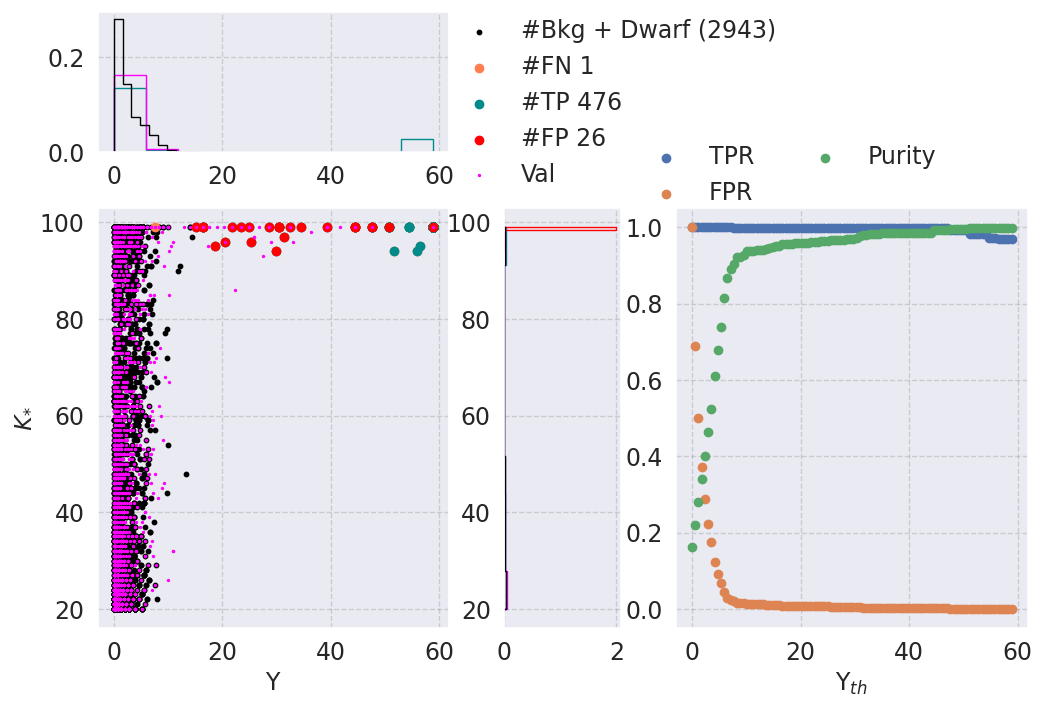

In [56]:
i = 150

upsilon = results[i]['stats']['Upsilon_i_plus']
kstar = results[i]['stats']['kstar_plus']
upsilon_na = result_dictionary_na['stats']['Upsilon_i_plus']
kstar_na = result_dictionary_na['stats']['kstar_plus']

try:
    #ind = np.asarray(results[i]['unique_elements_overdensities'][list(results[i]['unique_elements_overdensities'].keys())[0]])
    obs = np.loadtxt('../data/mocks/obs.lib' + str(ifile) + '/UFGX_TEST' + str(ifile) + '_lib/obs_' + str(int(results[i]['Ids'])) + '.dat')
    glon_dw = (obs[:,2] * 180/np.pi - 90) + glon[0] # Just to center the dwarf galaxy
    glat_dw = (obs[:,3] * 180/np.pi - 30) + glat[0]
    pmlon_dw = obs[:,5] / 1e3
    pmlat_dw = obs[:,6] / 1e3
    dw_data = np.vstack((glon_dw, glat_dw, pmlon_dw, pmlat_dw)).T
    full = np.vstack((bkg_data, dw_data))
    clusters = EagleEye.partitian_function(ref, full, results[i], results[i]['Upsilon_star_plus'][qt],
                                       results_sim[i]['Upsilon_star_minus'][qt],K_M=K_M)
    IV_IE_dict = EagleEye.IV_IE_get_dict(clusters, results[i], full, ref, Upsilon_star = [10])
    ind = np.asarray(IV_IE_dict['OVER_clusters'][0]['From_test'])
    print('Using eq.')
except:
    ind = np.asarray(np.where(upsilon >= np.quantile(upsilon, 0.8))[0])
    #ind = np.asarray(np.where(upsilon > 10)[0])
#ind = results[i]['overdensities'][10]
bkg_ind = np.delete(np.arange(len(upsilon)), ind)

try:
    upsilon_val = results[i]['stats']['Upsilon_i_Val_plus']
    kstar_val = results[i]['stats']['kstar_Val_plus']
    validation = len(upsilon_val)
except:
    validation = None
TP = len(np.where(ind >= results[i]['bkg'])[0]) # True positives
FP = len(np.where(ind < results[i]['bkg'])[0]) # False positives
TN = len(np.where(bkg_ind < results[i]['bkg'])[0]) # True negative
FN = len(np.where(bkg_ind >= results[i]['bkg'])[0]) # False negative

up_range = np.linspace(np.min(upsilon), np.max(upsilon), nups)

statistic, p_value = ks_2samp(upsilon, upsilon_na)

fig,ax = plt.subplots(2,3, gridspec_kw = {'width_ratios':[3,1,3], 'height_ratios':[1,3]},
                     #sharex = 'col', sharey = 'row',
                      figsize = (12,8))

#plt.subplots_adjust()
ax[0,0].hist(upsilon, histtype = 'step', density = True, color = 'darkcyan')
if validation is not None: ax[0,0].hist(upsilon_val, histtype = 'step', density = True, color = 'magenta')
#ax[0,0].hist(upsilons[i][-len(dw_data):], histtype = 'step', density = True, color = 'red')
ax[0,0].hist(upsilon_na, histtype = 'step', density = True, color = 'black')

ax[0,1].set_axis_off()

ax[1,0].scatter(upsilon, kstar, label = f'#Bkg + Dwarf ({len(upsilon)})', color = 'black', s = 10)
ax[1,0].scatter(upsilon[-results[i]['nstars']:], kstar[-results[i]['nstars']:], label = f'#FN {FN}', color = 'coral')
ax[1,0].scatter(upsilon[ind], kstar[ind], color = 'darkcyan', #marker = 'o',s=52, facecolors='none', 
                label = f"#TP {len(np.where(ind >= results[i]['bkg'])[0])}")
ax[1,0].scatter(upsilon[ind[np.where(ind < results[i]['bkg'])[0]]], kstar[ind[np.where(ind < results[i]['bkg'])[0]]], color = 'red', 
                label = f"#FP {len(np.where(ind < results[i]['bkg'])[0])}")
if validation is not None: ax[1,0].scatter(upsilon_val, kstar_val, label = 'Val', color = 'magenta', s = 2)
ax[1,0].legend(loc = 'upper right', bbox_to_anchor = (1.99,1.5), frameon = False)
#ax[1,0].axvline(x = up_th)

ax[1,1].hist(kstar, histtype = 'step', density = True, color = 'darkcyan', orientation='horizontal')
if validation is not None: ax[1,1].hist(kstar_val, histtype = 'step', density = True, color = 'magenta', orientation='horizontal')
ax[1,1].hist(kstar[-len(dw_data):], histtype = 'step', density = True, color = 'red', orientation='horizontal')
ax[1,1].hist(kstar_na, histtype = 'step', density = True, color = 'black', orientation='horizontal')

ax[1,0].set_xlabel('$\\Upsilon$')
ax[1,0].set_ylabel('$K_{*}$')

#ax[1,0].text(0.45, 0.6,'Gal ID: {}'.format(Ids[i]), transform = ax[1,0].transAxes)
#ax[1,0].text(0.45, 0.5,'# Dwarf stars: {}'.format(nstars[i]), transform = ax[1,0].transAxes)
#ax[1,0].text(0.45, 0.4,'# Bkg stars: {} ({:.2f})'.format(bkg[i], nstars[i] / bkg[i]), transform = ax[1,0].transAxes)
#ax[1,0].text(0.45, 0.3,'(l,b) = ({:.0f}° ; {:.0f}°)'.format(glons[i], glats[i]), transform = ax[1,0].transAxes)
#ax[1,0].text(0.45, 0.2,'Pval = {:.1f}'.format(p_value), transform = ax[1,0].transAxes)

ax[0,2].set_axis_off()
ax[1,2].scatter(up_range, (1-aux_FNR[i,:]), label = 'TPR')
ax[1,2].scatter(up_range, aux_FPR[i,:], label = 'FPR')
ax[1,2].scatter(up_range, aux_pur[i,:], label = 'Purity')
ax[1,2].set_xlabel('$\\Upsilon_{th}$')
ax[1,2].legend(loc = 'upper right', bbox_to_anchor = (0.80,1.20), frameon = False, ncol = 2)

#plt.savefig(f'../graph/gal_{Ids[i]}_{bkg[i]}.pdf', bbox_inches='tight')


In [67]:
# get the distribution of Upsilon_i^+
over_clusters = IV_IE_dict.get("OVER_clusters", {})

# Suppose these are your arrays of Upsilon_i^+ for all test points and for the "OVER" subset
data_all = result_dictionary['stats']['Upsilon_i_plus']
all_overdensities = [
    idx 
    for cluster_data in over_clusters.values() 
    for idx in cluster_data.get('From_test', [])
]
all_eualized = [x for x in range(full.shape[0]) if x not in all_overdensities ]
NUMBER_CORES = 10
PARTITION_SIZE = 100

Upsilon_post_IE = EagleEye.pval_post_equalization(
    full, 
    ref, 
    all_eualized,
    K_M,
    NUMBER_CORES,
    PARTITION_SIZE
    )

In [68]:
Upsilon_post_IE

array([ 1.35,  0.29,  1.46, ..., 63.93, 63.93, 63.93])

Text(0, 0.5, '$Log_{10}(N_{*}/\\Delta \\mu)$')

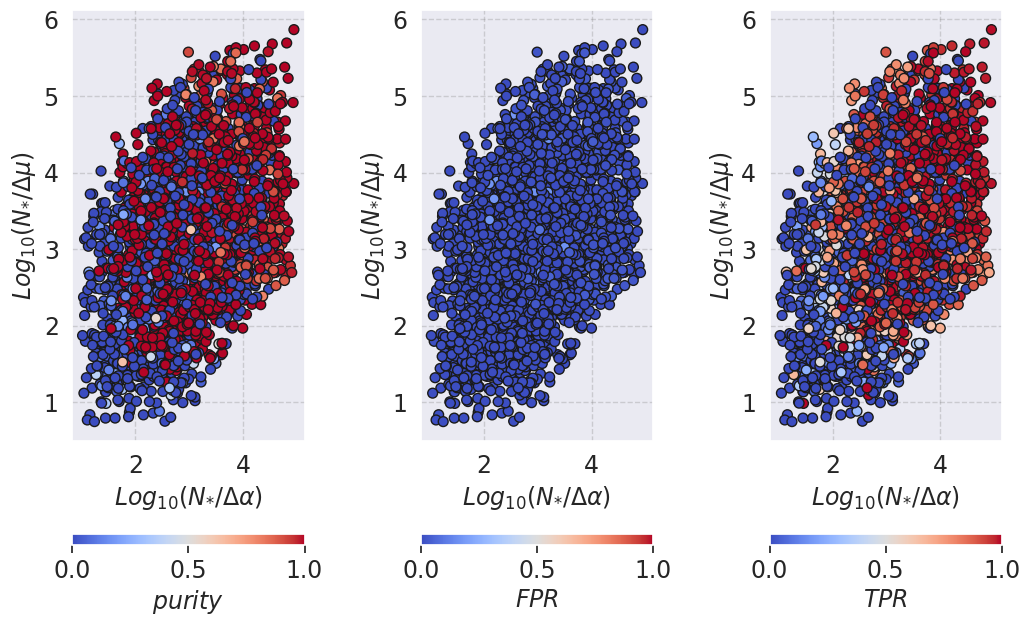

In [64]:
fig, ax = plt.subplots(1,3, figsize = (12,8))
plt.subplots_adjust(wspace = 0.5)

sc0 = ax[0].scatter(np.log10(np.asarray(nstars) / np.asarray(ang_sizes)), np.log10(np.asarray(nstars) / np.asarray(vpec_sizes)), c=stats[:,0], cmap='coolwarm', edgecolor='k', s=50,
                   vmin = 0, vmax = 1)
plt.colorbar(sc0, label='$purity$', orientation = 'horizontal')

ax[0].set_xlabel('$Log_{10}(N_{*}/\Delta \\alpha)$')
ax[0].set_ylabel('$Log_{10}(N_{*}/\Delta \mu)$')

sc1 = ax[1].scatter(np.log10(np.asarray(nstars) / np.asarray(ang_sizes)), np.log10(np.asarray(nstars) / np.asarray(vpec_sizes)), c=stats[:,1], cmap='coolwarm', edgecolor='k', s=50,
                   vmin = 0, vmax = 1)
plt.colorbar(sc1, label='$FPR$', orientation = 'horizontal')

ax[1].set_xlabel('$Log_{10}(N_{*}/\Delta \\alpha)$')
ax[1].set_ylabel('$Log_{10}(N_{*}/\Delta \mu)$')

sc2 = ax[2].scatter(np.log10(np.asarray(nstars) / np.asarray(ang_sizes)), np.log10(np.asarray(nstars) / np.asarray(vpec_sizes)), c=stats[:,2], cmap='coolwarm', edgecolor='k', s=50,
                   vmin = 0, vmax = 1)
plt.colorbar(sc2, label='$TPR$', orientation = 'horizontal')

ax[2].set_xlabel('$Log_{10}(N_{*}/\Delta \\alpha)$')
ax[2].set_ylabel('$Log_{10}(N_{*}/\Delta \mu)$')
#plt.yscale('log')
#plt.xscale('log')

#plt.savefig(f'../graph/purity_{bkg[0]}_EEv7_ref:sim+eq+cl.pdf')

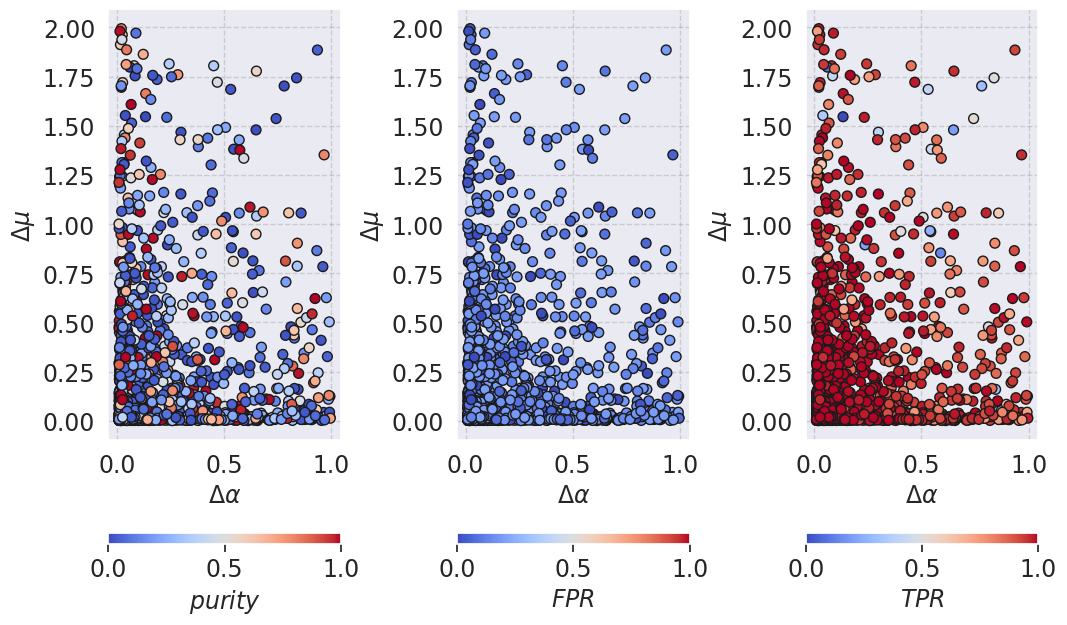

In [324]:
fig, ax = plt.subplots(1,3, figsize = (12,8))
plt.subplots_adjust(wspace = 0.5)

sc0 = ax[0].scatter((ang_sizes), (vpec_sizes), c=stats[:,0], cmap='coolwarm', edgecolor='k', s=50,
                   vmin = 0, vmax = 1)
plt.colorbar(sc0, label='$purity$', orientation = 'horizontal')

ax[0].set_xlabel('$\Delta \\alpha$')
ax[0].set_ylabel('$\Delta \mu$')

sc1 = ax[1].scatter((ang_sizes), (vpec_sizes), c=stats[:,1], cmap='coolwarm', edgecolor='k', s=50,
                   vmin = 0, vmax = 1)
plt.colorbar(sc1, label='$FPR$', orientation = 'horizontal')

ax[1].set_xlabel('$\Delta \\alpha$')
ax[1].set_ylabel('$\Delta \mu$')

sc2 = ax[2].scatter((ang_sizes), (vpec_sizes), c=stats[:,2], cmap='coolwarm', edgecolor='k', s=50,
                   vmin = 0, vmax = 1)
plt.colorbar(sc2, label='$TPR$', orientation = 'horizontal')

ax[2].set_xlabel('$\Delta \\alpha$')
ax[2].set_ylabel('$\Delta \mu$')
plt.savefig(f'../graph/purity2_{bkg[0]}_EEv7_ref:shuffle.pdf')


In [65]:
mean_pur, x_edges, y_edges, _ = binned_statistic_2d(np.log10(nstars / ang_sizes), np.log10(nstars / vpec_sizes), stats[:,0], statistic='mean', bins=20)
mean_FPR, _, _, _ = binned_statistic_2d(np.log10(nstars / ang_sizes), np.log10(nstars / vpec_sizes), stats[:,1], statistic='mean', bins=[x_edges,y_edges])
mean_TPR, _, _, _ = binned_statistic_2d(np.log10(nstars / ang_sizes), np.log10(nstars / vpec_sizes), stats[:,2], statistic='mean', bins=[x_edges,y_edges])

X_edges, Y_edges = np.meshgrid(x_edges, y_edges)

X_centers = 0.5 * (x_edges[:-1] + x_edges[1:])  # Centros de los bins en X
Y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])  # Centros de los bins en Y
X, Y = np.meshgrid(X_centers, Y_centers)

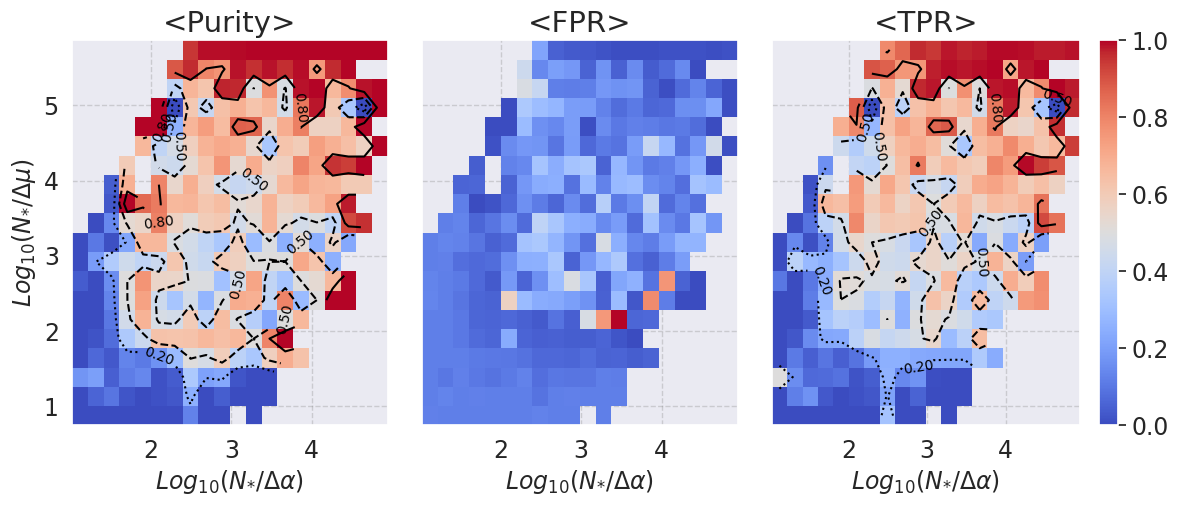

In [66]:
fig,ax = plt.subplots(1,3, figsize = (14,5), sharex = True, sharey = True, gridspec_kw = {'width_ratios':[0.82,0.82,1]})
plt.subplots_adjust(wspace = 0.1)

ax[0].pcolormesh(X_edges, Y_edges, mean_pur, cmap="coolwarm", shading='auto')
contours = ax[0].contour(X, Y, mean_pur, levels=[0.2, 0.5, 0.8], colors='black', linestyles = [':','--','solid'], origin='upper')
ax[0].clabel(contours, inline=True, fontsize=10, fmt="%.2f")
ax[0].set_xlabel('$Log_{10}(N_{*}/\Delta \\alpha)$')
ax[0].set_ylabel('$Log_{10}(N_{*}/\Delta \mu)$')
ax[0].set_title('<Purity>')

ax[1].pcolormesh(X_edges, Y_edges, mean_FPR, cmap="coolwarm", shading='auto')
contours = ax[1].contour(X, Y, mean_FPR, levels=[0.2, 0.5, 0.8], colors='black', linestyles = [':','--','solid'], origin='upper')
ax[1].clabel(contours, inline=True, fontsize=10, fmt="%.2f")
ax[1].set_xlabel('$Log_{10}(N_{*}/\Delta \\alpha)$')
ax[1].set_title('<FPR>')

cmap = ax[2].pcolormesh(X_edges, Y_edges, mean_TPR, cmap="coolwarm", shading='auto')
contours = ax[2].contour(X, Y, mean_TPR, levels=[0.2, 0.5, 0.8], colors='black', linestyles = [':','--','solid'], origin='upper')
ax[2].clabel(contours, inline=True, fontsize=10, fmt="%.2f")
ax[2].set_xlabel('$Log_{10}(N_{*}/\Delta \\alpha)$')
ax[2].set_title('<TPR>')
plt.colorbar(cmap, ax=ax[2])

#plt.savefig(f'../graph/statsHeatmap_{bkg[0]}_ref:sim+eq+cl_EEv7.pdf')

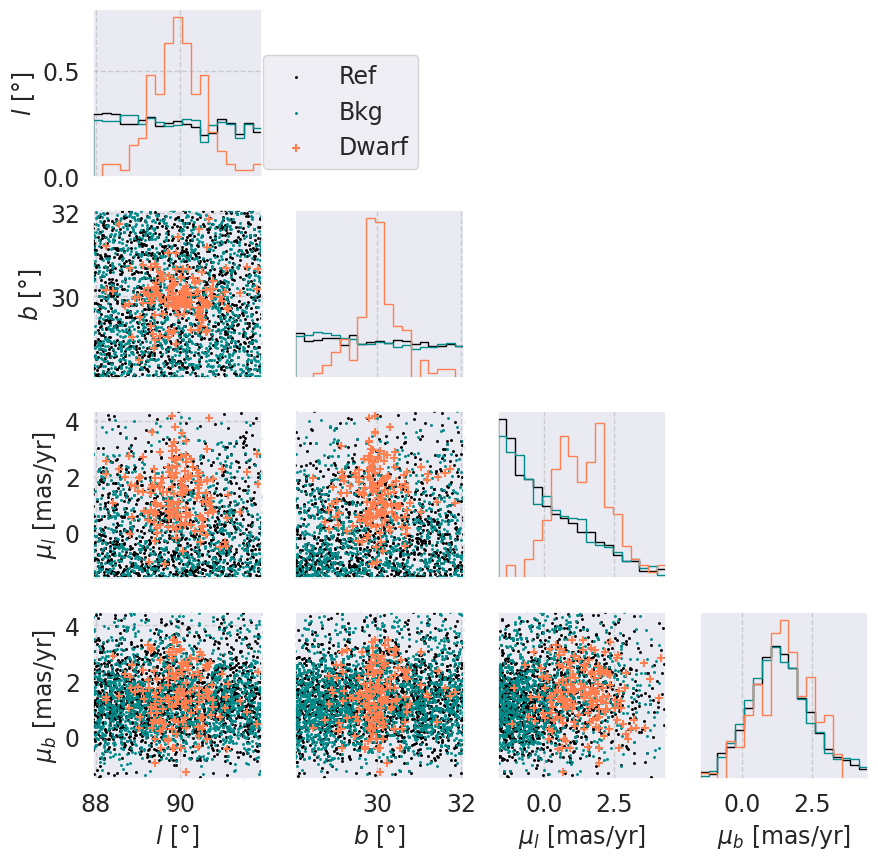

In [218]:
fig, ax  = plt.subplots(4,4, figsize = (10,10), sharex = 'col')

plt.subplots_adjust(hspace = 0.2, wspace = 0.2)

ax = plotDwarf(ax, dw_data, bkg_data, ref)

#plt.savefig('../graph/gal_{}_4d.pdf'.format(Id), bbox_inches='tight')

In [168]:
glat, glon = np.degrees(hp.pix2ang(nside, np.arange(NPIX)))
glat = 90 - glat

for ipur in range(nups):
#ipur = 0
    pur = aux_pur[:,ipur]
    mapa = np.zeros(NPIX)  # Array 1D de ejemplo
    mapa[np.where(np.abs(glat) > 20)[0]] = pur
    
    # Graficar el mapa en coordenadas Mollweide
    hp.mollview(mapa, title="", unit="Purity", cmap="viridis")
    
    plt.text(0, 1.1, "$\\Upsilon = ${:.2f}".format(up_range[ipur]), fontsize=12, color='black', ha='center')
    
    plt.savefig('../graph/960622/gif/Moolview_{}_pur.png'.format(ipur), bbox_inches='tight')
    plt.close()

In [251]:
aux_pur.shape

(16, 100)

Text(0, 1.1, '$\\Upsilon = $210.19')

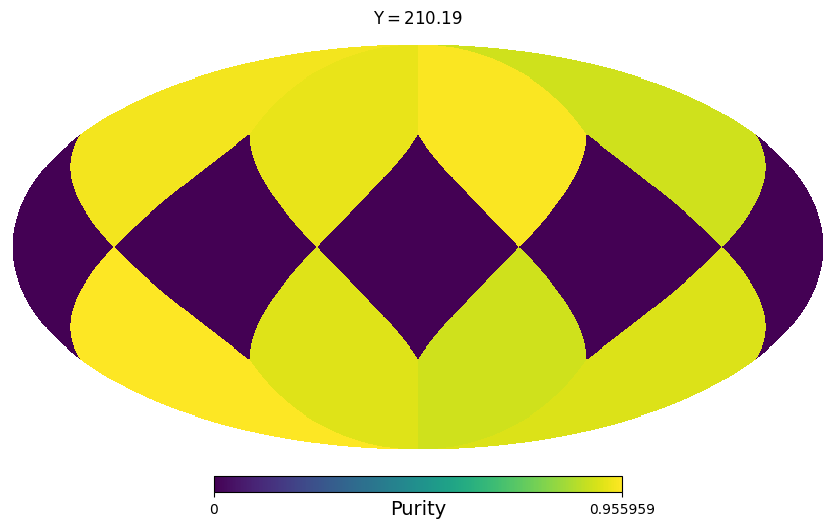

In [255]:
glat, glon = np.degrees(hp.pix2ang(nside, np.arange(NPIX)))
glat = 90 - glat

ipur = 60
pur = aux_pur[:8,ipur]
mapa = np.zeros(NPIX)  # Array 1D de ejemplo
mapa[np.where(np.abs(glat) > 20)[0]] = pur

# Graficar el mapa en coordenadas Mollweide
hp.mollview(mapa, title="", unit="Purity", cmap="viridis")

plt.text(0, 1.1, "$\\Upsilon = ${:.2f}".format(up_range[ipur]), fontsize=12, color='black', ha='center')

# Deprecated

In [ ]:
obs = np.loadtxt('../data/mocks/obs.lib96/UFGX_TEST96_lib/obs_960005.dat') # just to have something for the function to work
full_aux, ref, dw_data = LoadBkg(obs, glon_center = 90, glat_center = 30,
                             eps_lat = 0, eps_lon = 0, row_limit = None, size = 5)
bkg_data = full_aux[:-len(dw_data)]

In [ ]:
niter = 1#len(glat) #10 # Number of iterations per galaxy

Props = np.zeros(((len(data) * niter), 3)) # Let's initialize the properties array

Ids        = []
ang_sizes  = []
vpec_sizes = []
nstars     = []
pur        = []
falseNegR  = []
falsePosR  = []
dang       = []
dvpec      = []
bkg        = []
glats      = []
glons      = []

indices      = []
upsilons     = []
upsilons_na  = []
kstars       = []
kstars_na    = []
upsilons_val = []
kstars_val   = []

results = []
results_na = []

start0 = time()

counter = 0
for igal in tqdm(range(0, len(data))):
    start = time()
    for iiter in range(niter):
        if data[igal,12] < 40000:
            
            Ids.append(int(data[igal,0]))
            
            obs = np.loadtxt('../data/mocks/obs.lib' + str(ifile) + '/UFGX_TEST' + str(ifile) + '_lib/obs_' + str(int(Ids[counter])) + '.dat')
            print(len(obs))

            if niter > 1:
                full, ref, dw_data = LoadBkg(obs, glon_center = glon[iiter], glat_center = glat[iiter],
                                             eps_lat = 0, eps_lon = 0, row_limit = None, size = 3)
            else:
                glon_dw = (obs[:,2] * 180/np.pi - 90) + 90 # Just to center the dwarf galaxy
                glat_dw = (obs[:,3] * 180/np.pi - 30) + 30
                pmlon_dw = obs[:,5] / 1e3
                pmlat_dw = obs[:,6] / 1e3
                dw_data = np.vstack((glon_dw, glat_dw, pmlon_dw, pmlat_dw)).T
                full = np.vstack((bkg_data, dw_data))

            nstars.append( len(obs) )
            ang_sizes.append( data[igal,13] )
            vpec_sizes.append( data[igal,14] )
            bkg.append((len(full) - len(dw_data)))
            glons.append(glon[iiter])
            glats.append(glat[iiter])
            
            ind = np.arange(len(full))[-len(dw_data):]
    
            # Begin calls to EagleEye (version 7)
            try:
                result_dictionary = EagleEye.Soar(
                    ref, full, result_dict_in = {}, K_M = K_M, critical_quantiles = None,
                    num_cores=NUM_CORES, validation=int(np.min((len(full), len(ref)))), partition_size=100,Upsilon_stars=[10] )
            except:
                result_dictionary = EagleEye.Soar(
                    ref, full, result_dict_in = {}, K_M = K_M, critical_quantiles = None,
                    num_cores=NUM_CORES, validation=int(np.min((len(full), len(ref)))), partition_size=100,Upsilon_stars=None)

            
            result_dictionary[i]['Ids'] = int(data[igal,0])
            result_dictionary[i]['ang_sizes'] = data[igal,13]
            result_dictionary[i]['vpec_sizes'] = data[igal,14]
            result_dictionary[i]['nstars'] = len(obs)
            result_dictionary[i]['bkg'] = (len(full) - len(dw_data))
            result_dictionary[i]['glat'] = glat[iiter]
            result_dictionary[i]['glon'] = glon[iiter]
            
            results.append(result_dictionary)
    
            #&result_dictionary_na = EagleEye.Soar(
            #&    ref, full[:-len(dw_data)], result_dict_in = {}, K_M = K_M, critical_quantiles = None,
            #&    num_cores=NUM_CORES, validation=None, partition_size=100, Upsilon_stars=[10] )
            #results_na.append(result_dictionary_na)
            # ---------------------------------------------------------------------------------
    
            # Begin calls to EagleEye (new version)
            #%binary_sequences = From_data_to_binary.create_binary_array_cdist(full, ref, num_neighbors = K_M, 
            #%                                                                 num_cores = NUM_CORES, validation = validation, partition_size = 10)
            #%stats = EagleEye.calculate_p_values(binary_sequences, kstar_range = kstar_range, validation = validation, num_cores = NUM_CORES)
            #%upsilon, kstar, upsilon_val, kstar_val = stats['Upsilon_i'],stats['kstar_'],stats['Upsilon_i_Val'],stats['kstar_Val']
            #%
            #%binary_sequences_na = From_data_to_binary.create_binary_array_cdist(full[:-len(dw_data)], ref, num_neighbors = K_M, 
            #%                                                                 num_cores = NUM_CORES, validation = validation, partition_size = 10)
            #%stats_na = EagleEye.calculate_p_values(binary_sequences_na, kstar_range = kstar_range, validation = validation, num_cores = NUM_CORES)
            #%upsilon_na, kstar_na, upsilon_val_na, kstar_val_na = stats_na['Upsilon_i'],stats_na['kstar_'],stats_na['Upsilon_i_Val'],stats_na['kstar_Val']
            
            #%upsilons.append(upsilon)
            #%upsilons_na.append(upsilon_na)
            #%kstars.append(kstar)
            #%kstars_na.append(kstar_na)
            #%upsilons_val.append(upsilon_val)
            #%kstars_val.append(kstar_val)
            #%up_th = np.quantile(upsilon, 0.8)
            #%indices.append(np.where(upsilon >= up_th)[0])
            #%pur.append(purity(upsilon, ind, up_th = up_th))
            #%falseNegR.append(FNR(upsilon, ind, up_th = up_th))
            #%falsePosR.append(FPR(upsilon, ind, up_th = up_th))
            #%aux1, aux2 = Delta(full, upsilon, ind, up_th = up_th)
            #%dang.append(aux1)
            #%dvpec.append(aux2)
            # ---------------------------------------------------------------------------------
            
            counter = counter + 1
        stop = time()
        print('It takes {:.2f} hs to analyze a dwarf with {} stars at {} positions'.format((stop-start)/3600, len(dw_data), niter))

#Ids        = np.asarray(Ids)
#ang_sizes  = np.asarray(ang_sizes)
#vpec_sizes = np.asarray(vpec_sizes)
#nstars     = np.asarray(nstars)
#bkg        = np.asarray(bkg)
#glats      = np.asarray(glats)
#glons      = np.asarray(glons)

#%pur        = np.asarray(pur)
#%falseNegR  = np.asarray(falseNegR)
#%falsePosR  = np.asarray(falsePosR)
#%dang       = np.asarray(dang)
#%dvpec      = np.asarray(dvpec)